___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Assignment-1 (ANN)<br><br>Churn Prediction for Bank Customer<br><h1>

# Ammar Summary

- Read about the problem
- import libraries
- import dataset
- Try to undetstand the dataset
    - Check Null values
    - Check duplicate observations
    - Check dupliocate CustmerId OR RowNumber since they should be unique
    - Drop:
        - CustmerID
        - RowNumber
        - Surname, surname may worth a trial since maybe some members of a family follow have the same behaviour
    - Convert some cateogrical variables to their proper type since they were exist as numerical
    - See the distriubtion of our target classes. Two classes but 80:20 (imbalance)
    - See the relationship between each couple of the variables using pairplot, and using different color for each class
        - It seems that there are no unique areas for class 1 (most parts are also covered by class 0)
        - No Association between each pair of variables
    - Check correlation between each 2 variables
        - No strong linear correlation between any pair of variables (including the target)
    - For Cateogrical features, bar plots were done
        - The most useful insight from these barplots is that when NumofProduct is 3 or 4, the closed account are more than the open
    - We Check the box plots of the numeircal variables for each class
        - EstimatedSalary will not help much alone to distinguish between the two calsses
        - CreditScore in a smaller degree also seems will not help that much
        - Age have many outlier (old people) which does not seem error values, maybe those people opened the account than maybe even forget to use it! etc. Therefore, we will keep them but will use Robust scaler instead of MinMAx or standard scaler
    - Data PreProcessing:
        - We split hte data into train & test iwth stratfying our target since it is imbalanced
        - We create a pipline that do one-hot encoding for the two cateogrical variables (Gender, Geography) & Robust scaling which is used due to the high number of extreme values in age
        - We Fit_transform the trianing  and just transform the testing to prevernt data leakage
    - Build models (11 models were built): (The model to not be useless, it should give accuracy higher than predciting the most frequnet class which is around 80%)
        - 1- Without class weight
        - 2- With class weight (no tuining just use the method used in Tensorflow documentation https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) --> No big differnece
        - 3- with Class wieght but With higher learning rate (0.01) --> worse reuslt and very oscilating loss
        - 4- Add dropout to preventr overfitting and with default learning rate again --> Similar train/testing score. However, underfitting situation
        - 5- Add early stopping to prevent overfitting and with default learning rate again --> IT stooped after the 45th epoch and no need for comleting the training until the 1000th epoch
        - 6- Change themonitoring from loss_val to val_recall
            - We have to change the metric from accuracy to recall as well
            - The aim is still to minimize the loss function but now we monitor the recall isntead of the accuracy
            - The eraly stopping now is based on recall's validaiton  improvement
        - The prevous models were static (pre-defined layers and neurons)
        - Now will emntion the models that uses Hypaprameter tuning for:
            - Number of hidden layers
            - Number of neurons of rach
            - Dropout rate for each
            - The optimizer
            - The learning rate
        - 7- Accuracy -->  Accuracy(85%)
        - 8- Accuracy with undersmapling --> Accuracy(84%)  (undersampling is not suggested)
        - 9- Recall --> Accuracy (24%) --> It almost predicted everyting as class 1
        - 10 - PrecisionAtRecall we were looking for the best percision when recall is >=0.7 -->  Accuracy (87%)
            - The weird thign is that the recall were less than 70%, maybe it do that per mini-batch
        - 11- SensitivityAtSpecificity   we were looking for the best percision when Specificity is >=0.7 -->  Accuracy (87%)
    - For the final model, they were mutliple models with accuracy is 87% which is > 80% (the null accuracy), I'll choose the PrecisionAtRecall model since it is easy to interpret (similar to F1)
    - We save the model and scaler to be applied during the inference
    - We selected a random point and it was misclassfied, which confrims that out model btter than the null accuracy but stil need further improvements, by applyting imbalanced-data techniques like oversampling for the minroity class 

# Dataset Info

We have a dataset in which there are details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

The features in the given dataset are:
- **rownumber:** Row Numbers from 1 to 10000.
- **customerid:** A unique ID that identifies each customer.
- **surname:** The customer’s surname.
- **creditscore:** A credit score is a number between 300–850 that depicts a consumer's creditworthiness.
- **geography:** The country from which the customer belongs to.
- **Gender:** The customer’s gender: Male, Female
- **Age:** The customer’s current age, in years, at the time of being customer.
- **tenure:** The number of years for which the customer has been with the bank.
- **balance:** Bank balance of the customer.
- **numofproducts:** the number of bank products the customer is utilising.
- **hascrcard:** The number of credit cards given to the customer by the bank.
- **isactivemember:** Binary Flag for indicating if the client is active or not with the bank before the moment where the client exits the company (recorded in the variable "exited")
- **exited:** Binary flag 1 if the customer closed account with bank and 0 if the customer is retained.

In [1]:
try:
    import jupyter_black
    jupyter_black.load()
except ImportError:
    print('You can safely ignore this.')

You can safely ignore this.


In [2]:
import os

# Set tensorflow log level to ignore INFOs.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [3]:
# Get tensorflow version
import tensorflow as tf
tf.__version__

'2.10.0'

In [4]:


# List cuda-capable gpu's that are attached to this session
if tf.config.list_physical_devices("GPU"):
    print("GPU support is enabled for this session.")
else:
    print("This session will run on CPU.")
    


GPU support is enabled for this session.


# Improt Libraries & Data

In [38]:
import pandas as pd  # For manipulating dataframes
import numpy as np   # For arrays and matmetical stuff
import matplotlib.pyplot as plt # For visulaization
import seaborn as sns # For visulaization

# For data preprocessing [splitting, tranformation, encoding, make pipelines]
from sklearn.model_selection import train_test_split # splitting
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler  # Robust sclaer [used for numeric features]

# for evaluating classificaiton probelms
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay



# For the DNN model [create & monitor]
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam   # Optimizers
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras  #live change for the loss plot after each epoch
 
# For DNN hyperparamter tuning 
import optuna


%matplotlib inline

#plt.rcParams["figure.figsize"] = (10,6)
# To ignore warining
import warnings
warnings.filterwarnings('ignore')

# To change maximum rows to 50
pd.set_option('display.max_rows', 50)

# Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Check for missing values
3. Drop the features that not suitable for modelling
4. Implement basic visualization steps such as histogram, countplot, heatmap
5. Convert categorical variables to dummy variables

In [6]:
# Import the dataset
df=pd.read_csv("Churn_Modelling.csv")

In [7]:
# Look at the dataset
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [9]:
# Check number os nulls
df.isna().sum().sum()

0

In [10]:
# Check number of duplicate observations
df.duplicated().sum()

0

In [11]:
# CustmerID & Rownumber have to be unique (no duplicates)
# if it is not that case, we should remove the observations
print(df["CustomerId"].duplicated().sum())
print(df["RowNumber"].duplicated().sum())


0
0


In [12]:
# drop
# row number --> index
# customerid -->  id 
# Surname --> jsut a name
df.drop(['RowNumber','CustomerId', "Surname"],axis=1,inplace=True)


In [13]:
# let's covnert the type of the categorical variables into objects instead of numeric
df["NumOfProducts"] = df["NumOfProducts"].astype("object")
df["HasCrCard"] = df["HasCrCard"].astype("object")
df["IsActiveMember"] = df["IsActiveMember"].astype("object")

# Print descriptive statistics of the numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [14]:
# Print some statistics of the cateogrical variables
df.describe(include="O").T

,count,unique,top,freq
Geography,10000,3,France,5014
Gender,10000,2,Male,5457
NumOfProducts,10000,4,1,5084
HasCrCard,10000,2,1,7055
IsActiveMember,10000,2,1,5151


<Axes: xlabel='percent', ylabel='Exited'>

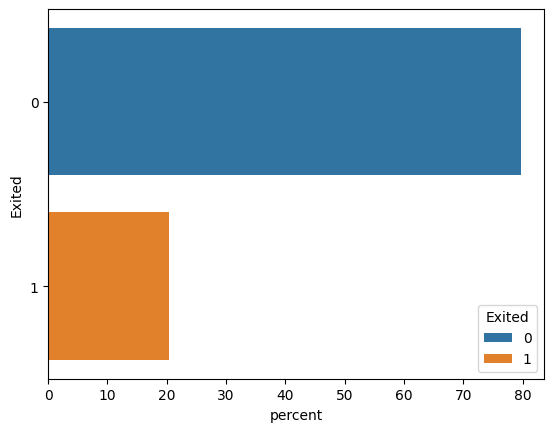

In [15]:
# Count the Observations of the target per class
sns.countplot(y=df["Exited"], hue = df["Exited"], stat= "percent")

**most observations (80%) are 0, whcih means we have imbalance data where the majority are still did not close their accoutns**

----------------------------------------------------------------





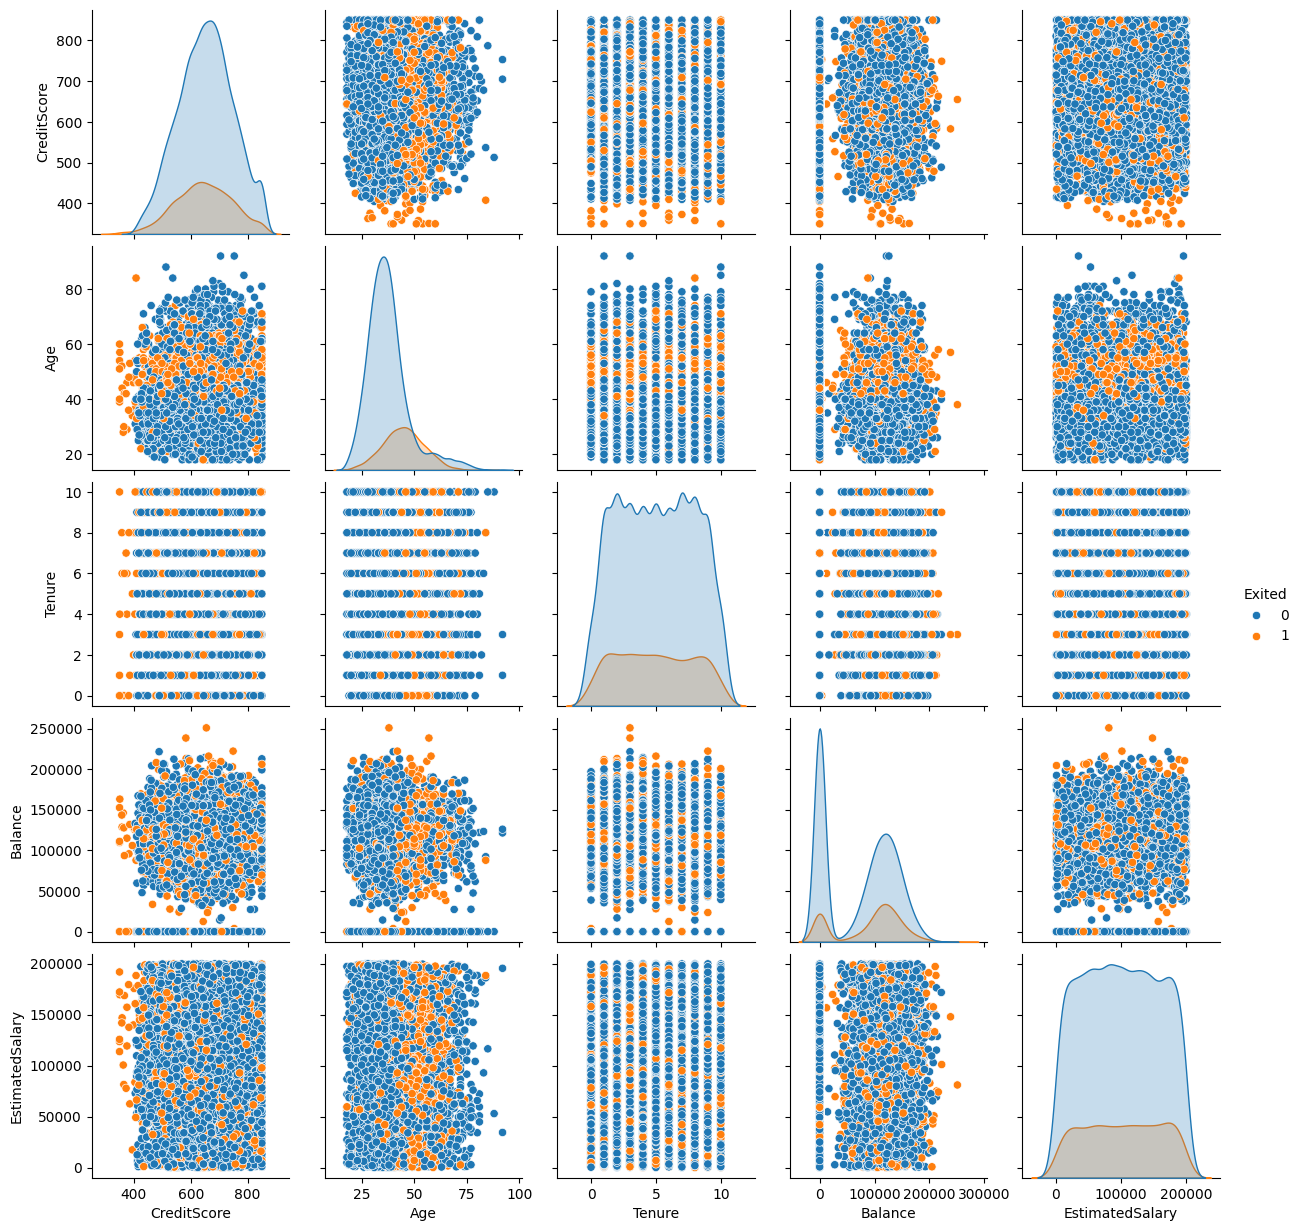

In [16]:
# Extract all numeric columns & the target (Exited)
list_num = df.describe().columns.to_list()

# Create scatter plot between each  two numeric feature and use Exited -the target- to map plot aspects to different colors. 
sns.pairplot(data= df.loc[:,list_num], hue="Exited")
plt.show()

- It seems there is no unique areas for class 1 (most parts are also covered by class 0)
- It seems there is no assiociation between the numeric features

---------

In [17]:
# Calculate the correlation matrix
correlation_matrix = df.corr(numeric_only=True)

pd.set_option("display.max_rows", None)
correlation_matrix
# Display the correlation matrix with colors
# print(correlation_matrix.style.background_gradient(cmap='coolwarm'))


def color_red(val):
    if (val > 0.90 and val < 1) or (val < -0.90 and val > -1):
        color = "red"
    else:
        color = "black"
    return f"color: {color}"


pd.DataFrame(correlation_matrix).corr().style.applymap(color_red)

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited
CreditScore,1.000000,-0.273923,-0.185052,-0.217991,-0.203044,-0.342544
Age,-0.273923,1.000000,-0.284076,-0.197917,-0.283852,0.350724
Tenure,-0.185052,-0.284076,1.000000,-0.260840,-0.180591,-0.314242
Balance,-0.217991,-0.197917,-0.260840,1.000000,-0.210277,-0.024196
EstimatedSalary,-0.203044,-0.283852,-0.180591,-0.210277,1.000000,-0.262778
Exited,-0.342544,0.350724,-0.314242,-0.024196,-0.262778,1.000000


<Axes: >

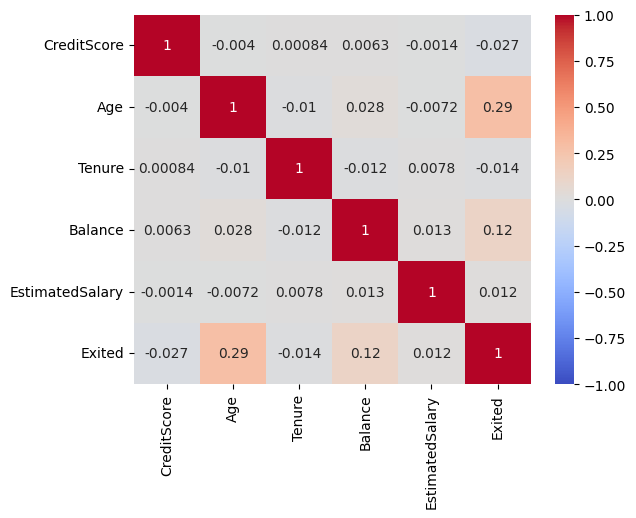

In [18]:
sns.heatmap(df.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap="coolwarm")

**There is no linear correlaiton between the numeric feautre (good)**

-----------------------------

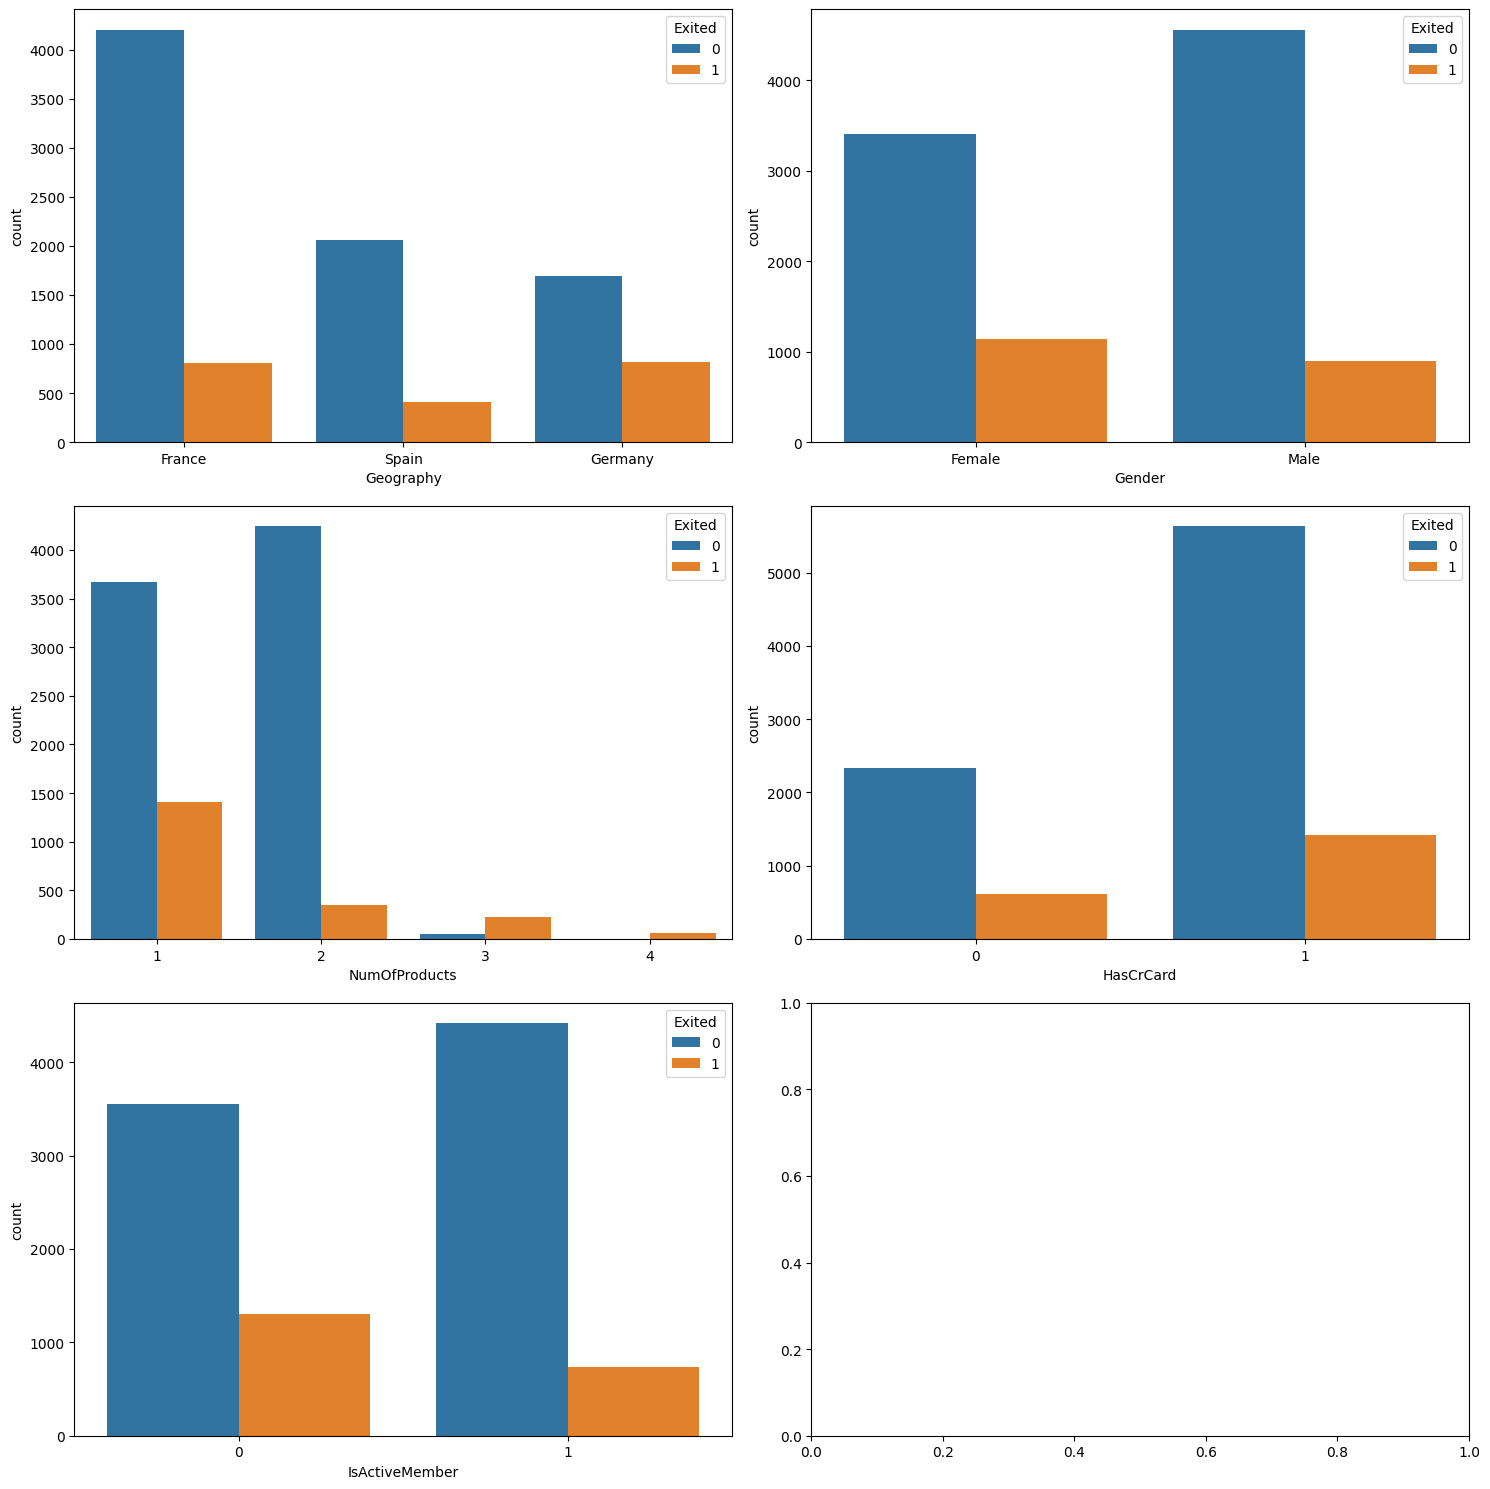

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a list of the categorical columns in the DataFrame
list_cat = df.describe(include="O").columns.to_list()

# Create a new DataFrame with only the categorical columns
df_plot = df.loc[:, list_cat]

# Create a figure with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Iterate over the column names in the DataFrame and create a countplot for each column
for i, column in enumerate(df_plot.columns):
    ax = axes[i // 2, i % 2]
    sns.countplot(data=df_plot, x=column, hue=df['Exited'], ax=ax)

# Adjust the subplot layout
fig.tight_layout()

# Display the plots
plt.show()


**The most useful insight from these barplots is that when NumofProduct is 3 or 4, the closed account are more than the open**

-----------

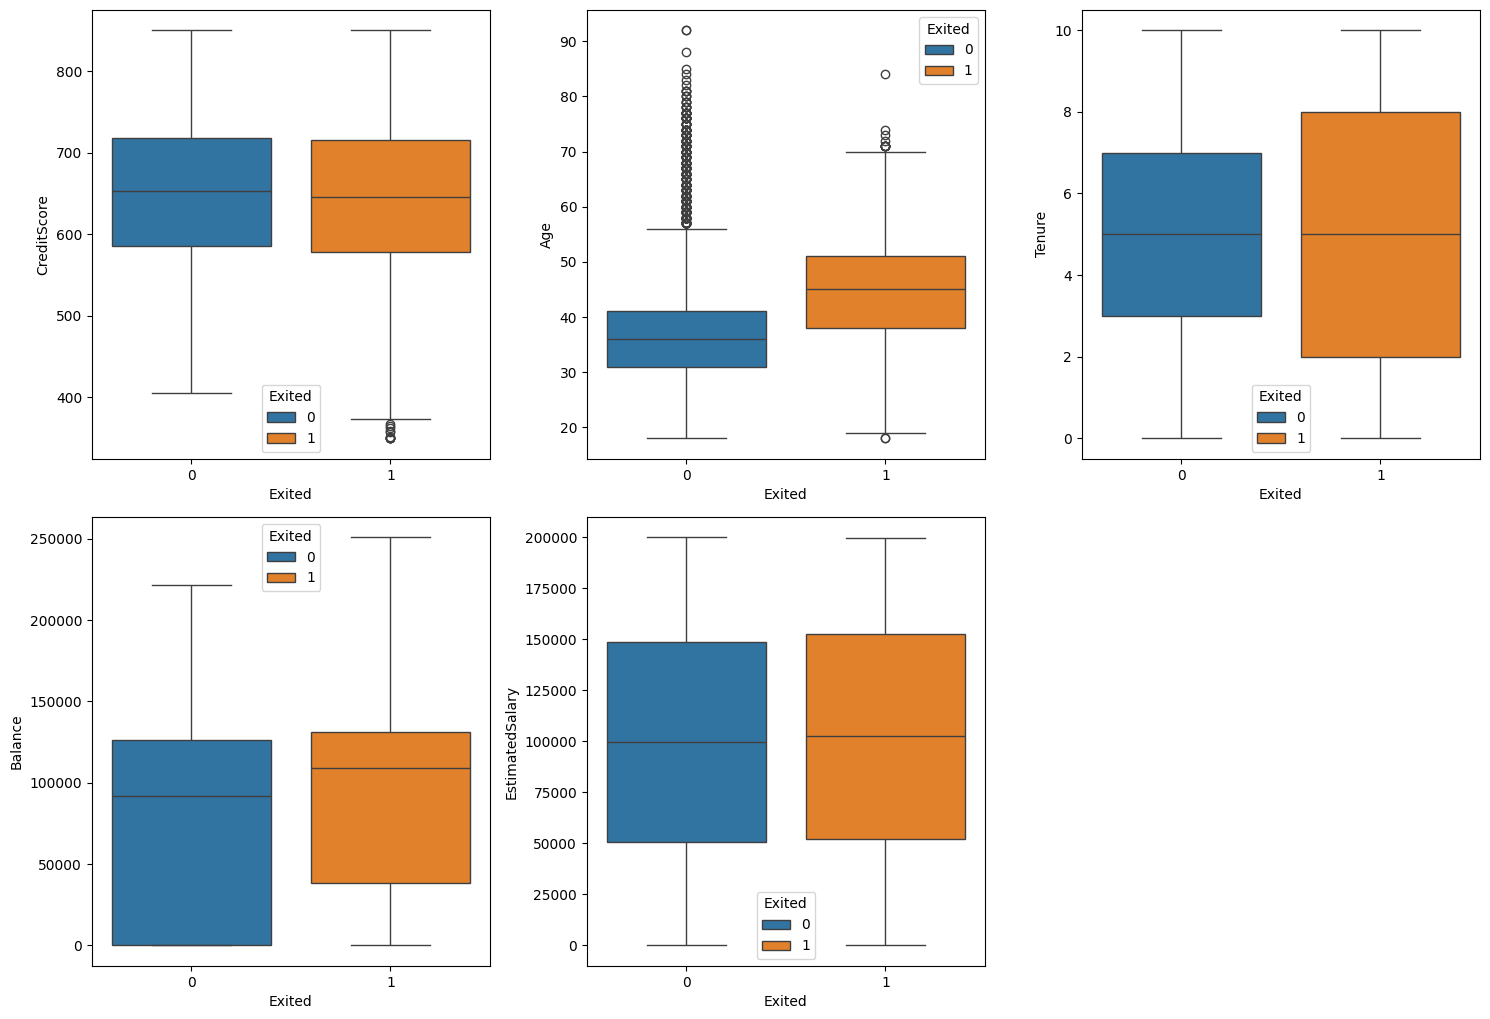

In [20]:
# Here we could see the most distinguishing features and potential outliers

fig = plt.figure(figsize=(15,20))

for i, col in enumerate(df.loc[:,list_num[:-1]]):
        plt.subplot(4,3,i+1)
        ax = sns.boxplot(x="Exited", y=df[col], data=df, hue="Exited")

plt.tight_layout();

- EstimatedSalary will not help much alone to distinguish between the two calsses
- CreditScore in a smaller degree also seems will not help that muh
- Age have many outlier [old people] which does not seem error values, maybe those people opened the account than maybe even forget to use it! etc. Therefore, we will keep them but will use Robust scaler instead of MinMAx or standard scaler

# Preprocessing of Data
- Train | Test Split, Scalling

In [21]:
X = df.drop("Exited", axis="columns")
y = df["Exited"]

In [22]:
seed = 42
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed, stratify = y # since classes are imbalanced
)

In [23]:
# Check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(7000, 10)
(7000,)
(3000, 10)
(3000,)


- Do encoding for the categorical features
- Do scaling

In [24]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

# Column to encode
cat_onehot = ['Geography', 'Gender']

column_trans = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_onehot),
    remainder="passthrough",
    verbose_feature_names_out=False,
)  

column_trans = column_trans.set_output(transform="pandas")

In [25]:
# We will use Robust scaler since Age has many outliers 

from sklearn.preprocessing import RobustScaler
RS = RobustScaler()

In [26]:
from sklearn.pipeline import Pipeline


operations = [("encoder", column_trans), ("scaler", RS)]

pipe_model = Pipeline(steps=operations)


In [27]:
X_train = pipe_model.fit_transform(X_train)
X_test = pipe_model.transform(X_test)

# Modelling & Model Performance

**(a model to not be useless, it should give accuracy higher than predciting the most frequnet class which is around 80%)**

## without class_weigth

### Create The Model

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation


# First way to create the model using the Sequential API
tf.random.set_seed(seed)
model = Sequential(
    [
        Input(shape= X_train.shape[1]),  # Number of unputs [feature]
        Dense(units=16, activation="relu"),
        Dense(units=16, activation="relu"),
        Dense(units=16, activation="relu"),
        Dense(units=1, activation='sigmoid'),  #  1 neuron and Sigmoid because it is a bianry classification problem
    ]
)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                224       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Wights then biases, layer by layer
model.weights

[<tf.Variable 'dense/kernel:0' shape=(13, 16) dtype=float32, numpy=
 array([[ 0.11856043,  0.34935385, -0.20368966, -0.16737276,  0.1467036 ,
          0.03802308, -0.21672909,  0.26425576, -0.1898126 ,  0.15923321,
          0.3440758 , -0.37807277,  0.01196244,  0.0145438 ,  0.43949312,
         -0.34355217],
        [-0.07211137,  0.21158773,  0.27211785, -0.06834611,  0.15285254,
         -0.16227165, -0.28865612, -0.42752114,  0.3455016 ,  0.05871952,
         -0.36222076,  0.41639072,  0.45009023,  0.33851612, -0.16376203,
         -0.16834944],
        [ 0.00136447,  0.30864275,  0.40158325,  0.3439632 ,  0.1265688 ,
          0.21166462, -0.4194168 , -0.3576068 ,  0.3973148 ,  0.20051032,
         -0.10063517,  0.16947359,  0.04243284,  0.35814643,  0.3806169 ,
          0.11594135],
        [ 0.16610926,  0.29425138,  0.07020867,  0.17142302, -0.18648511,
         -0.36975685, -0.11921254,  0.09323955, -0.2896846 , -0.11815777,
          0.30831444, -0.21634561,  0.43718278,  

In [31]:
# Complie requires two things:
# The optimzing algortihm 
# The loss function we need to minimize
# the metric is optional, it wil lmake sense of the reuslt since loss is hard to be interpreted
model.compile(optimizer='Adam',loss='binary_crossentropy', metrics='accuracy')

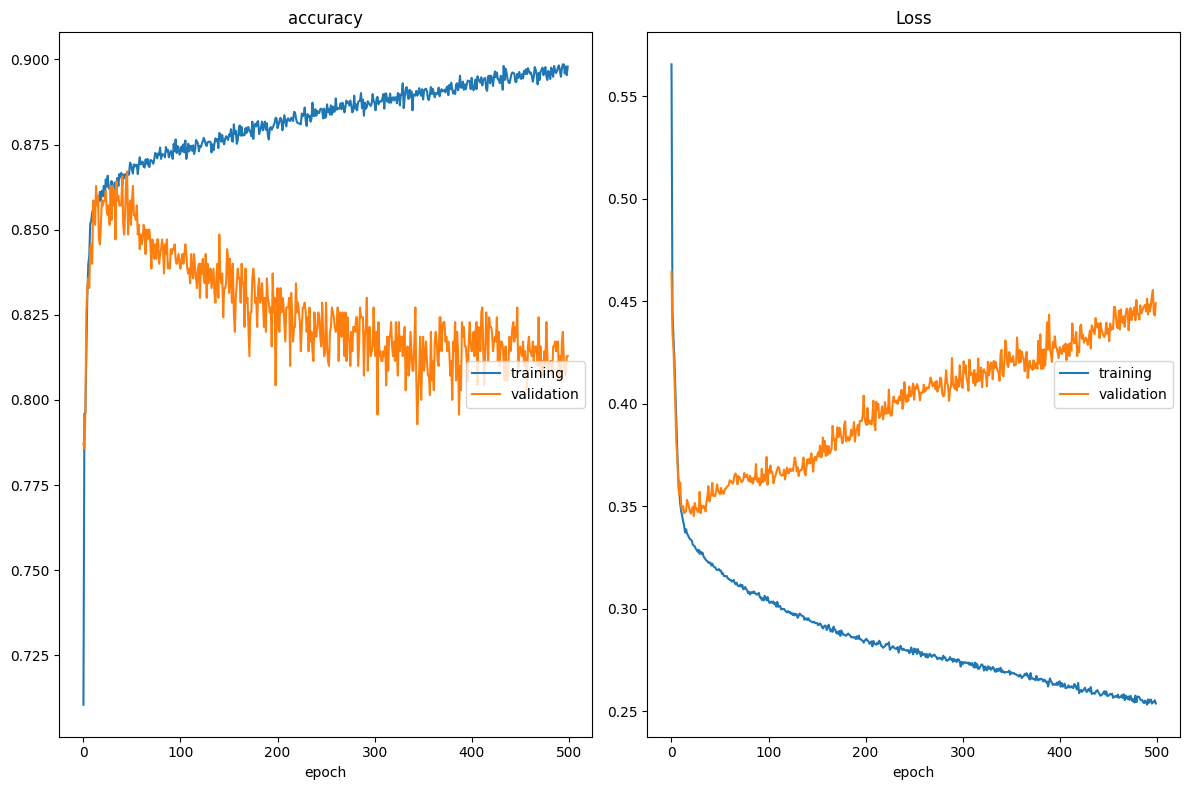

accuracy
	training         	 (min:    0.710, max:    0.899, cur:    0.898)
	validation       	 (min:    0.786, max:    0.867, cur:    0.813)
Loss
	training         	 (min:    0.253, max:    0.566, cur:    0.254)
	validation       	 (min:    0.345, max:    0.464, cur:    0.449)
197/197 [==============================] - 1s 7ms/step - loss: 0.2538 - accuracy: 0.8979 - val_loss: 0.4491 - val_accuracy: 0.8129


In [32]:
#  live training loss plot 
from livelossplot import PlotLossesKeras


# We are readt to fit the data
model.fit(
    x=X_train, y=y_train, validation_split=0.1, batch_size=32, epochs=500, verbose=1,
    callbacks=[PlotLossesKeras()] # This will update the plot per epoch
    
)

# Since this is without early stopping, we will just use 500 epoch

**It is clearly that we start to overfit before even the 70th epoch**

------------------

In [33]:
# You can still access all the losses
loss_df = pd.DataFrame(model.history.history)
display(loss_df.head())
print(loss_df.shape)

,loss,accuracy,val_loss,val_accuracy
0,0.565556,0.710476,0.464460,0.787143
1,0.445275,0.796032,0.434540,0.785714
2,0.432407,0.796191,0.427198,0.795714
3,0.421698,0.813016,0.413309,0.825714
4,0.406026,0.830476,0.399097,0.832857


(500, 4)


### Evaluate The Model

- Plot the model history to observe the changing of metrics
- Make prediction to see "confusion matrix" and "classification report"
- Check ROC (Receiver Operating Curve) and AUC (Area Under Curve) for the model

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train) > 0.5
    y_pred = model.predict(X_test) > 0.5
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [35]:
eval_metric(model, X_train, y_train, X_test, y_test)

94/94 [==============================] - 0s 1ms/step
Test_Set
[[2225  164]
 [ 324  287]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2389
           1       0.64      0.47      0.54       611

    accuracy                           0.84      3000
   macro avg       0.75      0.70      0.72      3000
weighted avg       0.82      0.84      0.83      3000


Train_Set
[[5393  181]
 [ 571  855]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      5574
           1       0.83      0.60      0.69      1426

    accuracy                           0.89      7000
   macro avg       0.86      0.78      0.81      7000
weighted avg       0.89      0.89      0.89      7000



In [36]:
# The accuracy if we just predcit all by the most frequent class, so don't get excited by anything near 80%
y.value_counts()[0]/ (y.value_counts()[0] + y.value_counts()[1])

0.7963

94/94 [==============================] - 0s 2ms/step


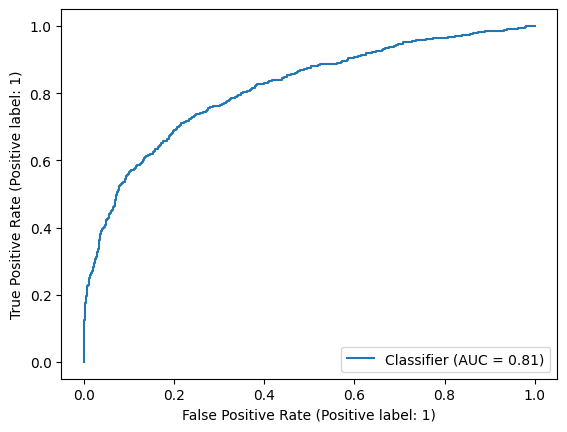

In [39]:
# ROC curve as the question satted, even though it is clearly imbalanced which means Precsion Vs Recall curve is better
y_pred_proba = model.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

## with class_weigth

Investigate how the "class_weight" hyper-parameter is used in a Neural Network.

-----

- Class weight can be adjusted so the model  "pay more attention" to examples from an under-represented class.
- This that this does not increase in any way the amount of information of your dataset.
-  In the end, using class weights is more or less equivalent to changing the output bias or to changing the threshold

### Create The Model

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation


# First way to create the model using the Sequential API
tf.random.set_seed(seed)
model_Class = Sequential(
    [
        Input(shape= X_train.shape[1]),  # Number of unputs [feature]
        Dense(units=16, activation="relu"),
        Dense(units=16, activation="relu"),
        Dense(units=16, activation="relu"),
        Dense(units=1, activation='sigmoid'),  #  1 neuron and Sigmoid because it is a bianry classification problem
    ]
)

In [41]:
# Check weights
model_Class.weights

[<tf.Variable 'dense_4/kernel:0' shape=(13, 16) dtype=float32, numpy=
 array([[ 3.85718286e-01, -2.43963763e-01, -3.08664083e-01,
         -4.08957213e-01, -1.34308428e-01, -3.82810473e-01,
         -1.20777309e-01,  2.96260357e-01,  1.48738444e-01,
          2.43990779e-01,  2.03531861e-01, -9.97797251e-02,
          3.69171798e-01,  2.72023499e-01,  1.87162280e-01,
         -4.52886641e-01],
        [-3.67075056e-01,  2.97346175e-01,  3.84620667e-01,
         -1.12380087e-02, -1.25483364e-01, -2.50060439e-01,
          3.15781593e-01, -2.37674937e-01,  2.09613800e-01,
         -2.63724178e-01,  6.61684871e-02, -3.84216368e-01,
         -2.81889558e-01, -1.42902434e-02,  1.33664131e-01,
         -1.58918917e-01],
        [-4.16926205e-01,  1.35871172e-01,  2.45657384e-01,
         -9.24171805e-02, -5.87009490e-02,  1.14096522e-01,
         -8.23200047e-02, -1.02340162e-01, -1.53009981e-01,
         -2.28799641e-01,  1.45859003e-01,  1.41733885e-01,
          1.14058912e-01,  2.9848831

In [42]:
neg = y.value_counts()[0]
pos = y.value_counts()[1]
total = neg + pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.63
Weight for class 1: 2.45


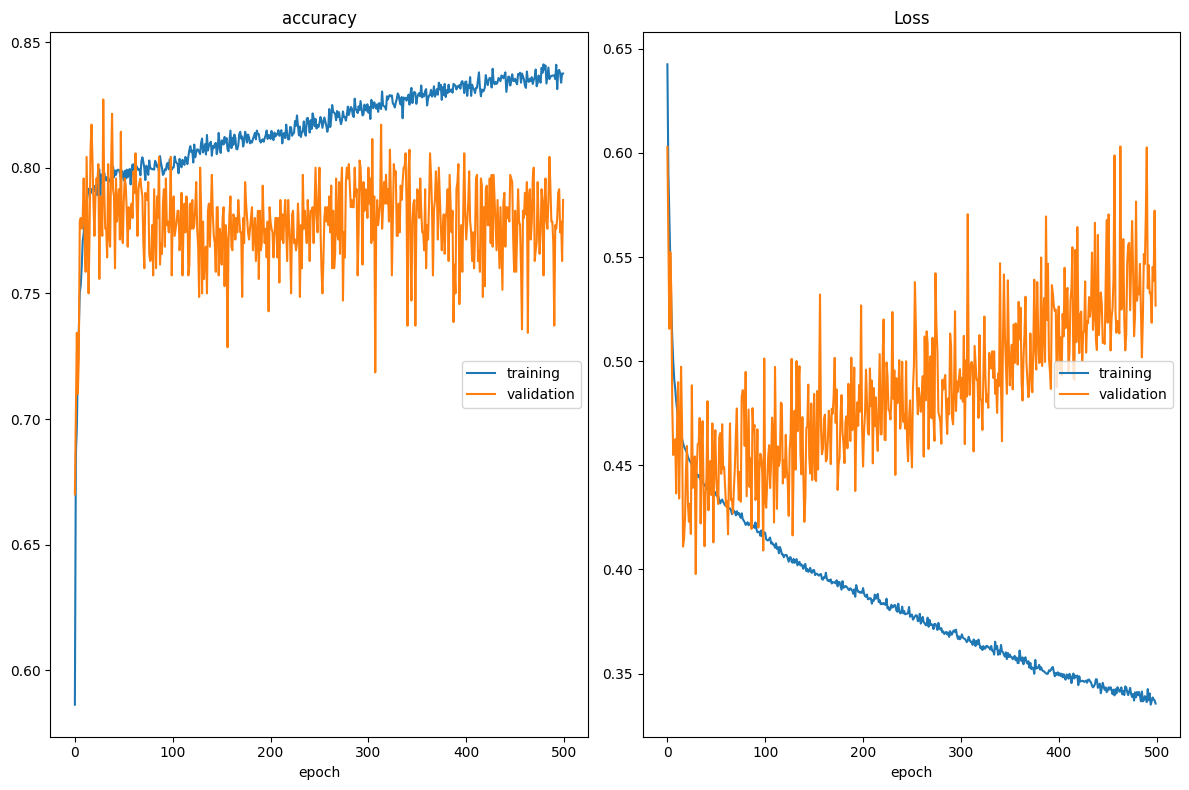

accuracy
	training         	 (min:    0.586, max:    0.841, cur:    0.837)
	validation       	 (min:    0.670, max:    0.827, cur:    0.787)
Loss
	training         	 (min:    0.335, max:    0.643, cur:    0.336)
	validation       	 (min:    0.398, max:    0.603, cur:    0.527)
197/197 [==============================] - 1s 7ms/step - loss: 0.3356 - accuracy: 0.8375 - val_loss: 0.5266 - val_accuracy: 0.7871


In [43]:
# Complie requires two things:
# The optimzing algortihm 
# The loss function we need to minimize
# the metric is optional, it wil lmake sense of the reuslt since loss is hard to be interpreted
model_Class.compile(optimizer='Adam',loss='binary_crossentropy', metrics='accuracy')

#  live training loss plot 
from livelossplot import PlotLossesKeras


# We are readt to fit the data
model_Class.fit(
    x=X_train, y=y_train, validation_split=0.1, batch_size=32, epochs=500, verbose=1,
    class_weight=class_weight,    # Don't forget to add it here
    callbacks=[PlotLossesKeras()] 
    
)

# Since this is without early stopping, we will just use 500 epoch

### Evaluate The Model

- Plot the model history to observe the changing of metrics
- Make prediction to see "confusion matrix" and "classification report"
- Check ROC (Receiver Operating Curve) and AUC (Area Under Curve) for the model

In [44]:
eval_metric(model_Class, X_train, y_train, X_test, y_test)

94/94 [==============================] - 0s 2ms/step
Test_Set
[[1921  468]
 [ 194  417]]
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      2389
           1       0.47      0.68      0.56       611

    accuracy                           0.78      3000
   macro avg       0.69      0.74      0.71      3000
weighted avg       0.82      0.78      0.79      3000


Train_Set
[[4685  889]
 [ 230 1196]]
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      5574
           1       0.57      0.84      0.68      1426

    accuracy                           0.84      7000
   macro avg       0.76      0.84      0.79      7000
weighted avg       0.88      0.84      0.85      7000



- Same as the equal weight, overfitted before the 100th epoch
- More fluctuating, especially the validation set
- No improtvemnt in F1 of minority class, maybe the threshold can be changed to do so. However, I'll nor do that here since there is no early stopping


94/94 [==============================] - 0s 1ms/step


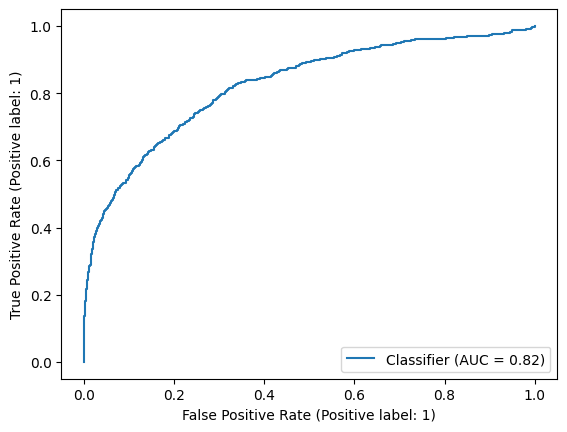

In [45]:
# ROC curve as the question satted, even though it is clearly imbalanced which means Precsion Vs Recall curve is better
y_pred_proba = model_Class.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

## Implementation Different Methods to Develop The Model

- Implement the following methods on model creating with "class_weight" parameter
- Create and evaluate model for each method

### Increase The Learning Rate and Observe The Results

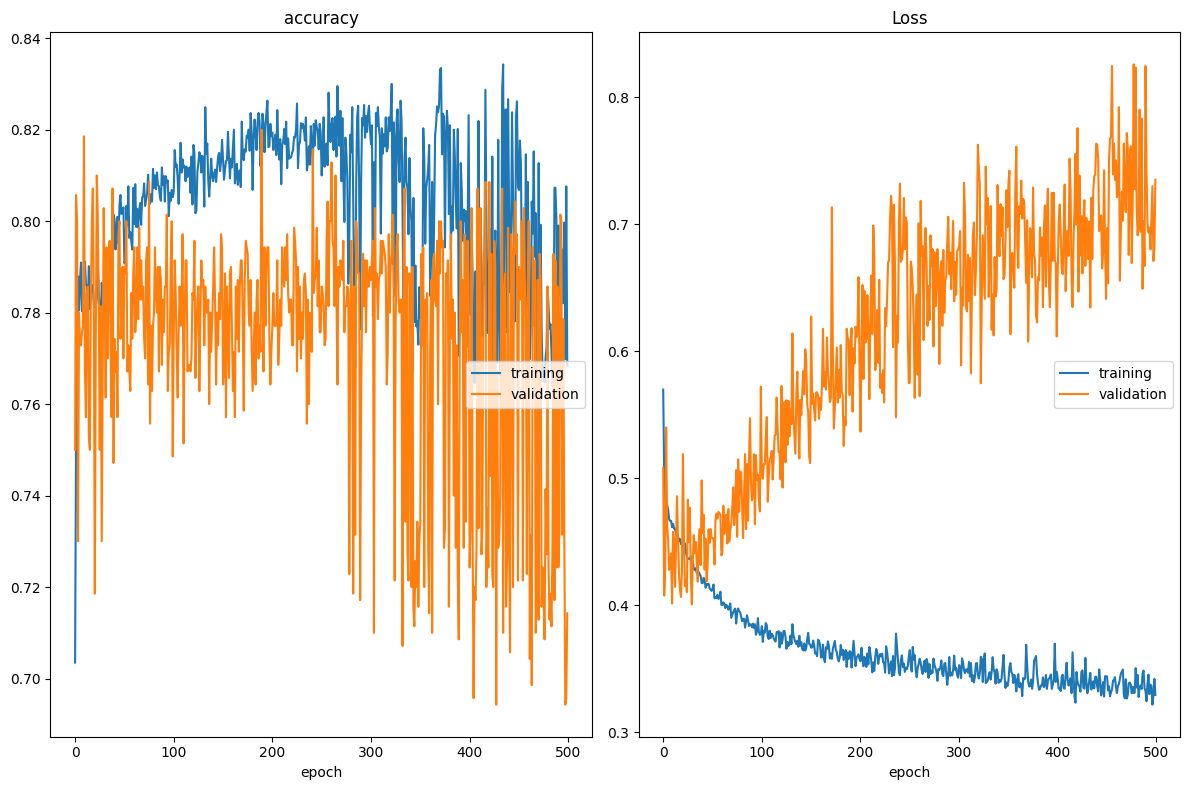

accuracy
	training         	 (min:    0.703, max:    0.834, cur:    0.768)
	validation       	 (min:    0.694, max:    0.820, cur:    0.714)
Loss
	training         	 (min:    0.322, max:    0.570, cur:    0.329)
	validation       	 (min:    0.401, max:    0.826, cur:    0.735)
197/197 [==============================] - 1s 7ms/step - loss: 0.3293 - accuracy: 0.7684 - val_loss: 0.7350 - val_accuracy: 0.7143


In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from keras.optimizers import Adam


# First way to create the model using the Sequential API
tf.random.set_seed(seed)
model_Class_LR = Sequential(
    [
        Input(shape= X_train.shape[1]),  # Number of unputs [feature]
        Dense(units=16, activation="relu"),
        Dense(units=16, activation="relu"),
        Dense(units=16, activation="relu"),
        Dense(units=1, activation='sigmoid'),  #  1 neuron and Sigmoid because it is a bianry classification problem
    ]
)

neg = y.value_counts()[0]
pos = y.value_counts()[1]
total = neg + pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


# Complie
Optimizer = Adam(learning_rate=0.01)    # Default learning_rate=0.001 
model_Class_LR.compile(optimizer=Optimizer,loss='binary_crossentropy', metrics='accuracy')

#  live training loss plot 
from livelossplot import PlotLossesKeras


# We are readt to fit the data
model_Class_LR.fit(
    x=X_train, y=y_train, validation_split=0.1, batch_size=32, epochs=500, verbose=1,
    class_weight=class_weight,    # Don't forget to add it here
    callbacks=[PlotLossesKeras()] 
    
)

# Since this is without early stopping, we will just use 500 epoch

- fluctuate more
- Validation loss increases quickly which indicates that the learning rate is high and need to be reduced
- Overfitted and the training accuracy is almost just as the baseline model

In [47]:
eval_metric(model_Class_LR, X_train, y_train, X_test, y_test)

94/94 [==============================] - 0s 1ms/step
Test_Set
[[1662  727]
 [ 124  487]]
              precision    recall  f1-score   support

           0       0.93      0.70      0.80      2389
           1       0.40      0.80      0.53       611

    accuracy                           0.72      3000
   macro avg       0.67      0.75      0.66      3000
weighted avg       0.82      0.72      0.74      3000


Train_Set
[[4066 1508]
 [ 103 1323]]
              precision    recall  f1-score   support

           0       0.98      0.73      0.83      5574
           1       0.47      0.93      0.62      1426

    accuracy                           0.77      7000
   macro avg       0.72      0.83      0.73      7000
weighted avg       0.87      0.77      0.79      7000



94/94 [==============================] - 0s 1ms/step


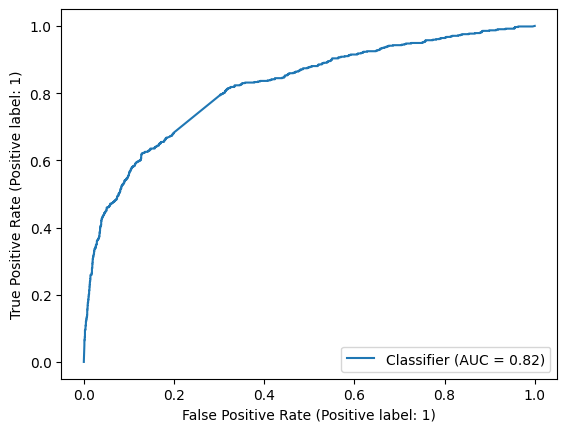

In [48]:
# ROC curve as the question satted, even though it is clearly imbalanced which means Precsion Vs Recall curve is better
y_pred_proba = model_Class_LR.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

-----------

### Add Dropout Layer

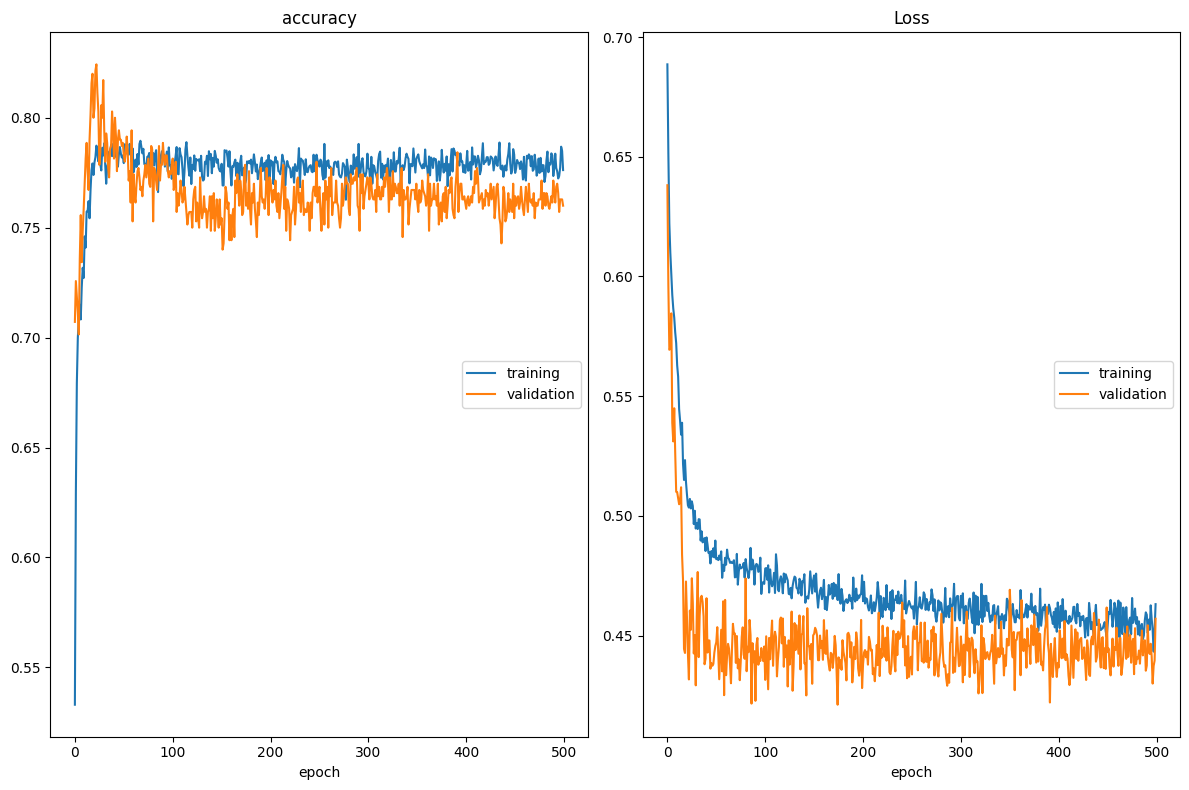

accuracy
	training         	 (min:    0.533, max:    0.790, cur:    0.776)
	validation       	 (min:    0.701, max:    0.824, cur:    0.760)
Loss
	training         	 (min:    0.443, max:    0.689, cur:    0.463)
	validation       	 (min:    0.421, max:    0.638, cur:    0.457)
197/197 [==============================] - 1s 7ms/step - loss: 0.4631 - accuracy: 0.7762 - val_loss: 0.4570 - val_accuracy: 0.7600


In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout


# In each minibatch during the training, 0.2 of the nuerons will set to be = 0, it helps to redcue the overfitting potential 
tf.random.set_seed(seed)
model_Class_DO = Sequential(
    [
        Input(shape= X_train.shape[1]),  # Number of unputs [feature]
        Dense(units=16, activation="relu"),
        Dropout(0.2),
        Dense(units=16, activation="relu"),
        Dropout(0.2),
        Dense(units=16, activation="relu"),
        Dropout(0.2),
        Dense(units=1, activation='sigmoid'),  #  1 neuron and Sigmoid because it is a bianry classification problem
    ]
)

neg = y.value_counts()[0]
pos = y.value_counts()[1]
total = neg + pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


# Complie
model_Class_DO.compile(optimizer="Adam",loss='binary_crossentropy', metrics='accuracy')

#  live training loss plot 
from livelossplot import PlotLossesKeras


# We are readt to fit the data
model_Class_DO.fit(
    x=X_train, y=y_train, validation_split=0.1, batch_size=32, epochs=500, verbose=1,
    class_weight=class_weight,    # Don't forget to add it here
    callbacks=[PlotLossesKeras()] 
    
)

# Since this is without early stopping, we will just use 500 epoch

In [50]:
eval_metric(model_Class_DO, X_train, y_train, X_test, y_test)

94/94 [==============================] - 0s 1ms/step
Test_Set
[[1778  611]
 [ 118  493]]
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      2389
           1       0.45      0.81      0.57       611

    accuracy                           0.76      3000
   macro avg       0.69      0.78      0.70      3000
weighted avg       0.84      0.76      0.78      3000


Train_Set
[[4255 1319]
 [ 237 1189]]
              precision    recall  f1-score   support

           0       0.95      0.76      0.85      5574
           1       0.47      0.83      0.60      1426

    accuracy                           0.78      7000
   macro avg       0.71      0.80      0.72      7000
weighted avg       0.85      0.78      0.80      7000



- Similar train/testing score. However, underfitting situation

---------------

94/94 [==============================] - 0s 1ms/step


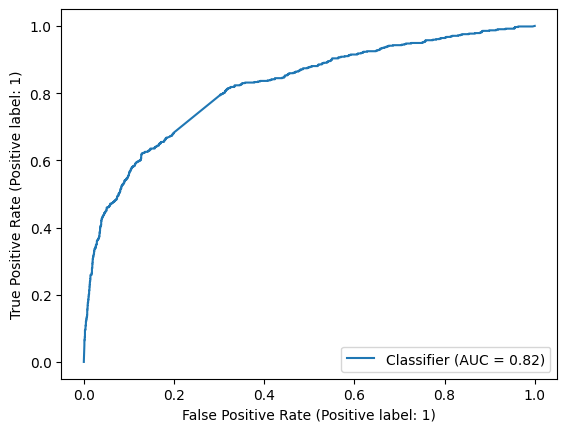

In [51]:
# ROC curve as the question satted, even though it is clearly imbalanced which means Precsion Vs Recall curve is better
y_pred_proba = model_Class_LR.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

### Add Early Stop

**Stop training when a monitored metric has stopped improving**

#### Monitor the "val_loss" as metric

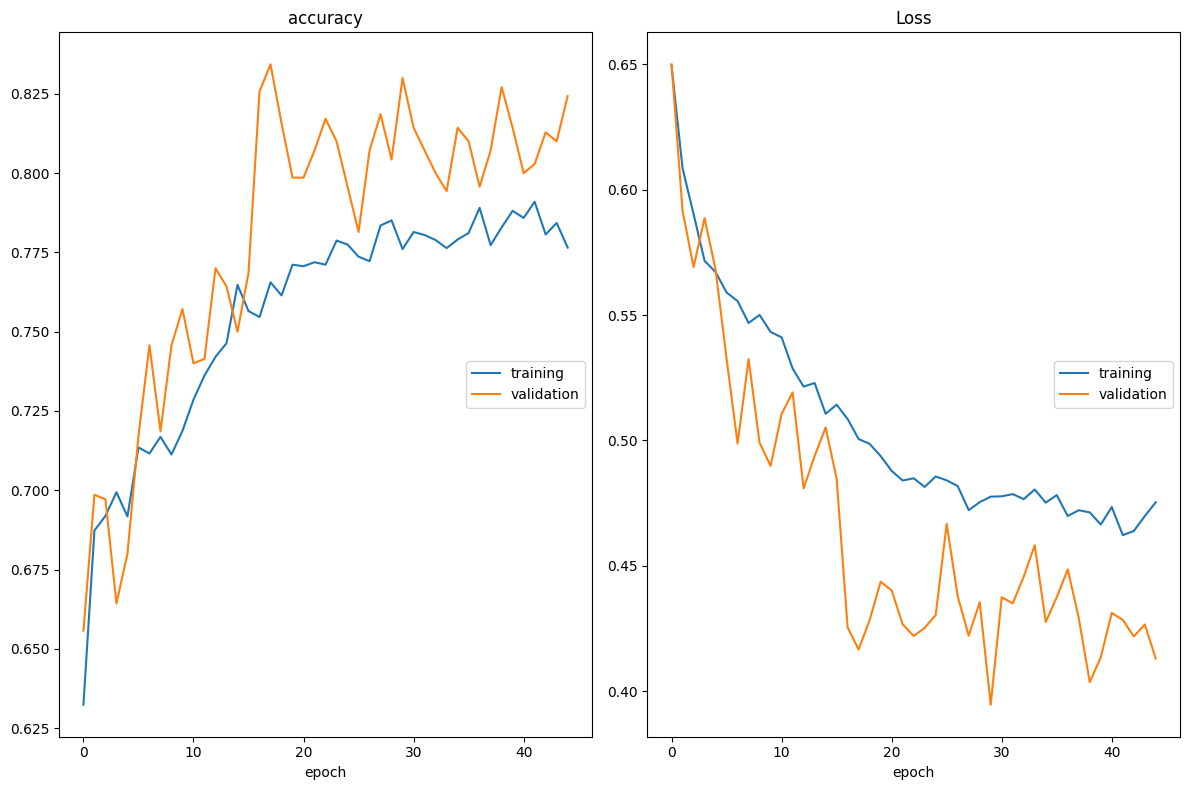

accuracy
	training         	 (min:    0.632, max:    0.791, cur:    0.777)
	validation       	 (min:    0.656, max:    0.834, cur:    0.824)
Loss
	training         	 (min:    0.462, max:    0.649, cur:    0.475)
	validation       	 (min:    0.395, max:    0.650, cur:    0.413)
Restoring model weights from the end of the best epoch: 30.
197/197 [==============================] - 1s 7ms/step - loss: 0.4754 - accuracy: 0.7765 - val_loss: 0.4130 - val_accuracy: 0.8243
Epoch 45: early stopping


In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping


# In each minibatch during the training, 0.2 of the nuerons will set to be = 0, it helps to redcue the overfitting potential 
tf.random.set_seed(seed)
model_val_loss = Sequential(
    [
        Input(shape= X_train.shape[1]),  # Number of unputs [feature]
        Dense(units=16, activation="relu"),
        Dropout(0.2),
        Dense(units=16, activation="relu"),
        #Dropout(0.2),
        Dense(units=16, activation="relu"),
        #Dropout(0.2),
        Dense(units=1, activation='sigmoid'),  #  1 neuron and Sigmoid because it is a bianry classification problem
    ]
)

neg = y.value_counts()[0]
pos = y.value_counts()[1]
total = neg + pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


# Complie
model_val_loss.compile(optimizer="Adam",loss='binary_crossentropy', metrics='accuracy')

#  live training loss plot 
from livelossplot import PlotLossesKeras

# Stop training when a monitored metric has stopped improving.
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True
)



# We are readt to fit the data
model_val_loss.fit(
    x=X_train, y=y_train, validation_split=0.1, batch_size=32, epochs=1000, verbose=1,  # 1000 epoch since there is early stopping
    class_weight=class_weight,    
    callbacks=[PlotLossesKeras(), early_stop]  # We add the erarly stop
    
)

# Since this is without early stopping, we will just use 500 epoch

YOu can see the greatness of the early stopping, after the 30th epoch, 15 successive epochs have not reached a lower validation loss. Therefore, we did not contine the training to finisgh the pre-specificed number of epochs (1000)

In [53]:
eval_metric(model_val_loss, X_train, y_train, X_test, y_test)

94/94 [==============================] - 0s 1ms/step
Test_Set
[[2165  224]
 [ 216  395]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2389
           1       0.64      0.65      0.64       611

    accuracy                           0.85      3000
   macro avg       0.77      0.78      0.78      3000
weighted avg       0.85      0.85      0.85      3000


Train_Set
[[5029  545]
 [ 547  879]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5574
           1       0.62      0.62      0.62      1426

    accuracy                           0.84      7000
   macro avg       0.76      0.76      0.76      7000
weighted avg       0.84      0.84      0.84      7000



94/94 [==============================] - 0s 1ms/step


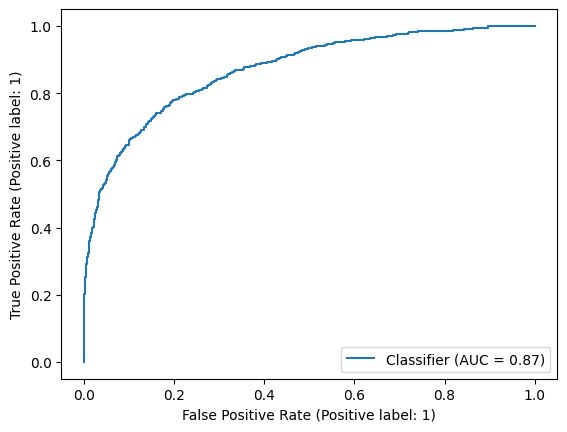

In [54]:
# ROC curve as the question satted, even though it is clearly imbalanced which means Precsion Vs Recall curve is better
y_pred_proba = model_val_loss.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

#### Monitor the "val_recall" as metric

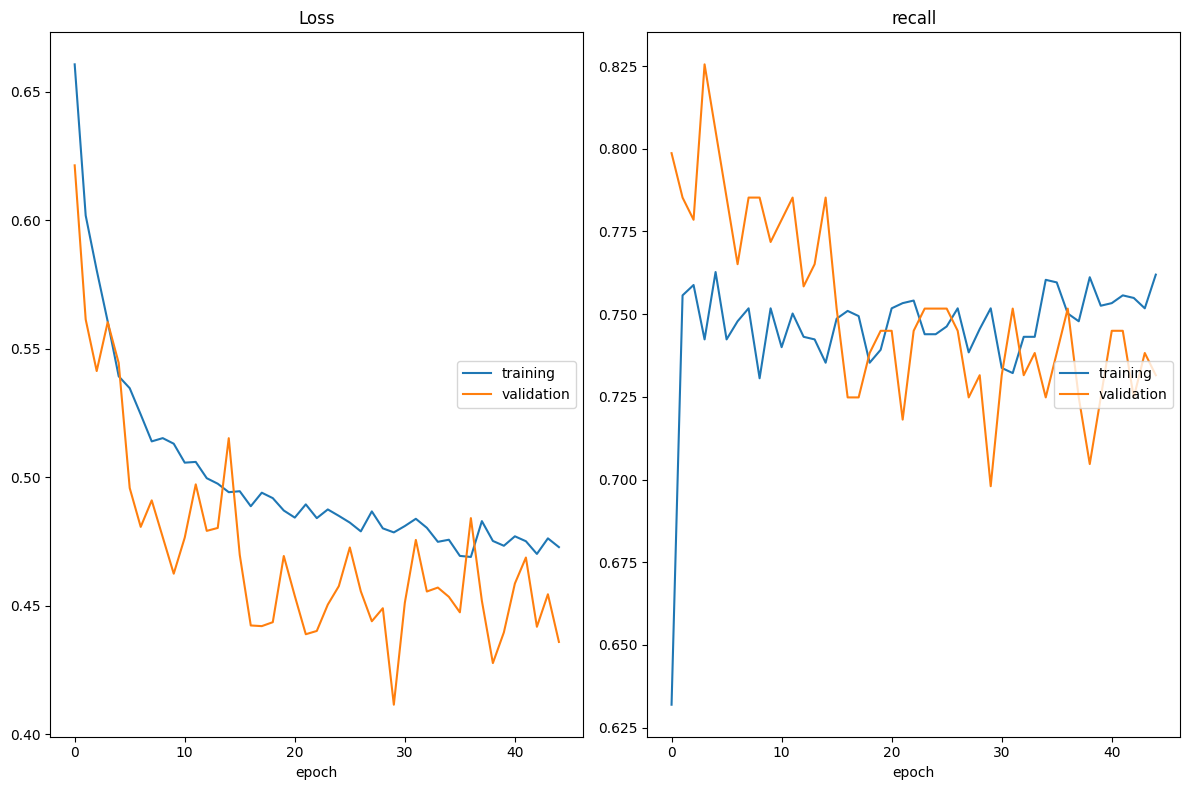

Loss
	training         	 (min:    0.469, max:    0.661, cur:    0.473)
	validation       	 (min:    0.411, max:    0.621, cur:    0.436)
recall
	training         	 (min:    0.632, max:    0.763, cur:    0.762)
	validation       	 (min:    0.698, max:    0.826, cur:    0.732)
Restoring model weights from the end of the best epoch: 30.
197/197 [==============================] - 1s 7ms/step - loss: 0.4728 - recall: 0.7619 - val_loss: 0.4359 - val_recall: 0.7315
Epoch 45: early stopping


In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping


# In each minibatch during the training, 0.2 of the nuerons will set to be = 0, it helps to redcue the overfitting potential 
tf.random.set_seed(seed)
model_val_recall = Sequential(
    [
        Input(shape= X_train.shape[1]),  # Number of unputs [feature]
        Dense(units=16, activation="relu"),
        Dropout(0.2),
        Dense(units=16, activation="relu"),
        #Dropout(0.2),
        Dense(units=16, activation="relu"),
        #Dropout(0.2),
        Dense(units=1, activation='sigmoid'),  #  1 neuron and Sigmoid because it is a bianry classification problem
    ]
)

neg = y.value_counts()[0]
pos = y.value_counts()[1]
total = neg + pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


# Complie
model_val_recall.compile(optimizer="Adam",loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall()])
# Recall not accuracy


#  live training loss plot 
from livelossplot import PlotLossesKeras

# Stop training when a monitored metric has stopped improving.
early_stop = EarlyStopping(
    monitor="val_recall", mode="min", verbose=1, patience=15, restore_best_weights=True
)



# We are readt to fit the data
model_val_recall.fit(
    x=X_train, y=y_train, validation_split=0.1, batch_size=32, epochs=1000, verbose=1,  # 1000 epoch since there is early stopping
    class_weight=class_weight,    
    callbacks=[PlotLossesKeras(), early_stop]  # We add the erarly stop
    
)

# Since this is without early stopping, we will just use 500 epoch

In [56]:
eval_metric(model_val_recall, X_train, y_train, X_test, y_test)

94/94 [==============================] - 0s 1ms/step
Test_Set
[[2070  319]
 [ 179  432]]
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      2389
           1       0.58      0.71      0.63       611

    accuracy                           0.83      3000
   macro avg       0.75      0.79      0.76      3000
weighted avg       0.85      0.83      0.84      3000


Train_Set
[[4794  780]
 [ 456  970]]
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      5574
           1       0.55      0.68      0.61      1426

    accuracy                           0.82      7000
   macro avg       0.73      0.77      0.75      7000
weighted avg       0.84      0.82      0.83      7000



94/94 [==============================] - 0s 2ms/step


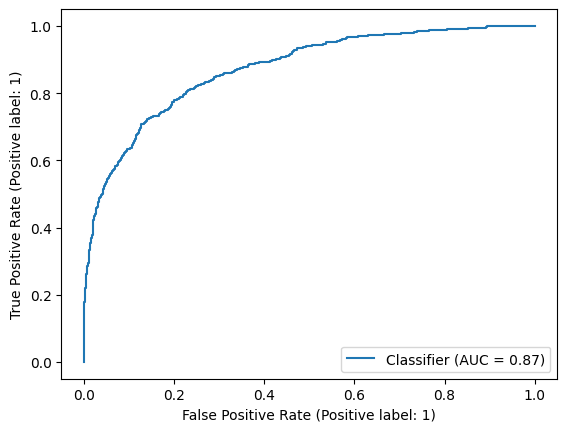

In [57]:
# ROC curve as the question satted, even though it is clearly imbalanced which means Precsion Vs Recall curve is better
y_pred_proba = model_val_recall.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

**Not useless model, but not very good**
<br><br>
**NOTES:**
- We have to change the metric from accuracy to recall as well
- The aim is still to minimize the loss function but now we monitor the recall isntead of the accuracy
- The eraly stopping now is based on recall's validaiton  improvement

---------------------

## Optuna

In [58]:
#!pip install optuna

In [59]:
import optuna


trial_metric = "accuracy"
batch_size = 32


def create_model(trial):
    tf.random.set_seed(42)
    # Some hyperparameters we want to optimize
    n_units1 = trial.suggest_int("n_units1", 8, 1024)
    n_units2 = trial.suggest_int("n_units2", 8, 1024)
    n_units3 = trial.suggest_int("n_units3", 0, 1024)
    DO_rate1 = trial.suggest_float("DO_rate1", 0, 1)
    DO_rate2 = trial.suggest_float("DO_rate2", 0, 1)
    DO_rate3 = trial.suggest_float("DO_rate3", 0, 1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1.3e-1)


    
    tf.random.set_seed(42)
    model = Sequential(
    [
        Input(shape= X_train.shape[1]),  # Number of unputs [feature]
        Dense(n_units1, activation="relu"),
        Dropout(DO_rate1),
        Dense(n_units2, activation="relu"),
        Dropout(DO_rate2),
        Dense(n_units3, activation="relu"),
        Dropout(DO_rate3),
        Dense(units=1, activation='sigmoid'),  #  1 neuron and Sigmoid because it is a bianry classification problem
    ]
)


    
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=[trial_metric],
    )
    return model


def objective(trial):

    # weight_for_0 = (1 / neg) * (total / 2.0)
    # weight_for_1 = (1 / pos) * (total / 2.0)
    # class_weight = {0: weight_for_0, 1: weight_for_1}


    early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True)

    
    model = create_model(trial)
    w0 = trial.suggest_loguniform("w0", 0.0001, 100)
    w1 = trial.suggest_loguniform("w1", 0.0001, 100)
    model.fit(
        X_train,
        y_train,
        validation_split=0.1,
        batch_size=batch_size,
        epochs=1000,
        callbacks=[early_stop],
        class_weight={0: w0, 1: w1},
        verbose=0,
    )
    score = model.evaluate(X_test, y_test, verbose=0)[1]
    return score

In [60]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
study.best_params

[I 2023-10-29 23:10:23,865] A new study created in memory with name: no-name-7bab0b40-4655-4bda-bebf-0c9cc8b17aa2


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-29 23:10:50,592] Trial 0 finished with value: 0.7963333129882812 and parameters: {'n_units1': 936, 'n_units2': 674, 'n_units3': 330, 'DO_rate1': 0.16769194380846297, 'DO_rate2': 0.7829571321665905, 'DO_rate3': 0.18050526465444627, 'learning_rate': 2.696681276362548e-05, 'w0': 0.6134753074166932, 'w1': 0.0001909050647732908}. Best is trial 0 with value: 0.7963333129882812.


Restoring model weights from the end of the best epoch: 46.
Epoch 61: early stopping


[I 2023-10-29 23:12:31,224] Trial 1 finished with value: 0.20366667211055756 and parameters: {'n_units1': 531, 'n_units2': 748, 'n_units3': 762, 'DO_rate1': 0.8519919204865565, 'DO_rate2': 0.8104582961129285, 'DO_rate3': 0.32825137573837404, 'learning_rate': 0.05627105177676166, 'w0': 0.11795901891266795, 'w1': 13.354555935014764}. Best is trial 0 with value: 0.7963333129882812.


Restoring model weights from the end of the best epoch: 390.
Epoch 405: early stopping


[I 2023-10-29 23:19:25,033] Trial 2 finished with value: 0.8636666536331177 and parameters: {'n_units1': 246, 'n_units2': 271, 'n_units3': 782, 'DO_rate1': 0.5887830340921407, 'DO_rate2': 0.5840246274746508, 'DO_rate3': 0.5046922843497159, 'learning_rate': 1.194656509459227e-05, 'w0': 0.15195861612986433, 'w1': 0.12244862191287725}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 6.
Epoch 21: early stopping


[I 2023-10-29 23:19:51,350] Trial 3 finished with value: 0.7963333129882812 and parameters: {'n_units1': 85, 'n_units2': 603, 'n_units3': 752, 'DO_rate1': 0.1655885693770086, 'DO_rate2': 0.9703274767550247, 'DO_rate3': 0.5344508854314215, 'learning_rate': 0.0005050494782565451, 'w0': 0.17238434972751682, 'w1': 0.006461594258767182}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-29 23:20:08,412] Trial 4 finished with value: 0.20366667211055756 and parameters: {'n_units1': 291, 'n_units2': 522, 'n_units3': 24, 'DO_rate1': 0.35527870285704977, 'DO_rate2': 0.7598215607694239, 'DO_rate3': 0.3497622697743389, 'learning_rate': 3.514872797897994e-05, 'w0': 0.0002541136626547029, 'w1': 0.04535014967753299}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-29 23:20:38,996] Trial 5 finished with value: 0.8320000171661377 and parameters: {'n_units1': 734, 'n_units2': 303, 'n_units3': 767, 'DO_rate1': 0.03155444601232271, 'DO_rate2': 0.3503542707958074, 'DO_rate3': 0.1870884285860559, 'learning_rate': 0.00037120291418993865, 'w0': 0.0003345058140902279, 'w1': 0.0013496188697063117}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 37.
Epoch 52: early stopping


[I 2023-10-29 23:21:27,147] Trial 6 finished with value: 0.8166666626930237 and parameters: {'n_units1': 307, 'n_units2': 422, 'n_units3': 60, 'DO_rate1': 0.5310042869232956, 'DO_rate2': 0.8001503775508862, 'DO_rate3': 0.4354358706077317, 'learning_rate': 0.0003124288592888682, 'w0': 0.0020596562701313704, 'w1': 0.0001689433612864735}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-29 23:21:54,658] Trial 7 finished with value: 0.7963333129882812 and parameters: {'n_units1': 966, 'n_units2': 601, 'n_units3': 689, 'DO_rate1': 0.17244109316675071, 'DO_rate2': 0.32019834149769033, 'DO_rate3': 0.1970277180583303, 'learning_rate': 2.43305622968689e-05, 'w0': 57.63240926965322, 'w1': 0.002066006105092996}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 26.
Epoch 41: early stopping


[I 2023-10-29 23:22:33,845] Trial 8 finished with value: 0.7963333129882812 and parameters: {'n_units1': 88, 'n_units2': 902, 'n_units3': 780, 'DO_rate1': 0.7199393200828482, 'DO_rate2': 0.7043747051553001, 'DO_rate3': 0.489234214884693, 'learning_rate': 1.8964708956604076e-05, 'w0': 2.3111788251930934, 'w1': 0.29656569535208754}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 238.
Epoch 253: early stopping


[I 2023-10-29 23:26:34,542] Trial 9 finished with value: 0.7963333129882812 and parameters: {'n_units1': 558, 'n_units2': 882, 'n_units3': 297, 'DO_rate1': 0.8404348068033763, 'DO_rate2': 0.972987977325022, 'DO_rate3': 0.5792346651594902, 'learning_rate': 1.1984930208177662e-05, 'w0': 0.028764131630461282, 'w1': 0.011276571406969874}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 14.
Epoch 29: early stopping


[I 2023-10-29 23:27:00,893] Trial 10 finished with value: 0.20600000023841858 and parameters: {'n_units1': 308, 'n_units2': 31, 'n_units3': 1011, 'DO_rate1': 0.6001293603078194, 'DO_rate2': 0.05303752394789818, 'DO_rate3': 0.8813557000796505, 'learning_rate': 0.006033865509384023, 'w0': 0.009423060900449715, 'w1': 0.4921098608909581}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 82.
Epoch 97: early stopping


[I 2023-10-29 23:28:29,733] Trial 11 finished with value: 0.33033332228660583 and parameters: {'n_units1': 732, 'n_units2': 241, 'n_units3': 1015, 'DO_rate1': 0.028959228299702496, 'DO_rate2': 0.47875953047028463, 'DO_rate3': 0.05008913765268119, 'learning_rate': 0.00014627513772771895, 'w0': 0.0002178832601164436, 'w1': 2.6173275387279507}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 33.
Epoch 48: early stopping


[I 2023-10-29 23:29:15,004] Trial 12 finished with value: 0.5320000052452087 and parameters: {'n_units1': 731, 'n_units2': 304, 'n_units3': 570, 'DO_rate1': 0.41664946220020377, 'DO_rate2': 0.443643638551528, 'DO_rate3': 0.007553368340616401, 'learning_rate': 0.0019239612532609706, 'w0': 0.002788419668665434, 'w1': 0.08735250747208949}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-29 23:29:31,144] Trial 13 finished with value: 0.20366667211055756 and parameters: {'n_units1': 785, 'n_units2': 124, 'n_units3': 870, 'DO_rate1': 0.9733658206196992, 'DO_rate2': 0.27968146697805296, 'DO_rate3': 0.6785500970462459, 'learning_rate': 0.00011601457606905623, 'w0': 0.00010230253535104733, 'w1': 89.84052390211843}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 37.
Epoch 52: early stopping


[I 2023-10-29 23:30:27,281] Trial 14 finished with value: 0.8130000233650208 and parameters: {'n_units1': 395, 'n_units2': 356, 'n_units3': 549, 'DO_rate1': 0.3719158538846984, 'DO_rate2': 0.5890764347213566, 'DO_rate3': 0.713303817300055, 'learning_rate': 0.00010010407426283735, 'w0': 0.02720414185061967, 'w1': 0.0016506687747161505}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 66.
Epoch 81: early stopping


[I 2023-10-29 23:31:40,455] Trial 15 finished with value: 0.612666666507721 and parameters: {'n_units1': 608, 'n_units2': 171, 'n_units3': 410, 'DO_rate1': 0.6405618489322573, 'DO_rate2': 0.5779703497252788, 'DO_rate3': 0.28507263190074783, 'learning_rate': 0.0007479699091670828, 'w0': 0.0011426562955968323, 'w1': 0.027377454878661826}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 44.
Epoch 59: early stopping


[I 2023-10-29 23:32:37,206] Trial 16 finished with value: 0.5163333415985107 and parameters: {'n_units1': 174, 'n_units2': 412, 'n_units3': 905, 'DO_rate1': 0.4701523235010537, 'DO_rate2': 0.3496144315733917, 'DO_rate3': 0.41878673854393056, 'learning_rate': 0.001910286177052937, 'w0': 0.008246842440195691, 'w1': 0.22815699004995457}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-29 23:32:52,033] Trial 17 finished with value: 0.7963333129882812 and parameters: {'n_units1': 408, 'n_units2': 8, 'n_units3': 637, 'DO_rate1': 0.26222998887995824, 'DO_rate2': 0.19212473883724246, 'DO_rate3': 0.15194611339536046, 'learning_rate': 6.197953204872411e-05, 'w0': 0.831146866099976, 'w1': 0.001464554587908113}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-29 23:33:07,999] Trial 18 finished with value: 0.20366667211055756 and parameters: {'n_units1': 845, 'n_units2': 224, 'n_units3': 844, 'DO_rate1': 0.047809245091254615, 'DO_rate2': 0.4340659769379057, 'DO_rate3': 0.2876356975332349, 'learning_rate': 1.091855255745053e-05, 'w0': 0.0006456974932452451, 'w1': 0.9335132567212535}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-29 23:33:59,513] Trial 19 finished with value: 0.3853333294391632 and parameters: {'n_units1': 653, 'n_units2': 467, 'n_units3': 441, 'DO_rate1': 0.3190867703155152, 'DO_rate2': 0.5793319948410098, 'DO_rate3': 0.40168365455602373, 'learning_rate': 0.00021002476729230674, 'w0': 0.0007857882665548903, 'w1': 0.08862567641911133}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 39.
Epoch 54: early stopping


[I 2023-10-29 23:34:55,635] Trial 20 finished with value: 0.8403333425521851 and parameters: {'n_units1': 439, 'n_units2': 304, 'n_units3': 665, 'DO_rate1': 0.4960436219128338, 'DO_rate2': 0.2265355485372039, 'DO_rate3': 0.5991394595664798, 'learning_rate': 5.337024573002391e-05, 'w0': 0.006217900338055719, 'w1': 0.01522399793466827}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 39.
Epoch 54: early stopping


[I 2023-10-29 23:35:54,646] Trial 21 finished with value: 0.8600000143051147 and parameters: {'n_units1': 426, 'n_units2': 324, 'n_units3': 634, 'DO_rate1': 0.4529946818307584, 'DO_rate2': 0.22906916953810008, 'DO_rate3': 0.6039734975640648, 'learning_rate': 5.094684644779229e-05, 'w0': 0.009457016928855751, 'w1': 0.01618482298431045}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 39.
Epoch 54: early stopping


[I 2023-10-29 23:36:44,972] Trial 22 finished with value: 0.809333324432373 and parameters: {'n_units1': 436, 'n_units2': 134, 'n_units3': 643, 'DO_rate1': 0.5013422156162822, 'DO_rate2': 0.12087130537790773, 'DO_rate3': 0.6050280652650806, 'learning_rate': 5.536336514477677e-05, 'w0': 0.0053875465701127, 'w1': 0.021599203306018937}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 91.
Epoch 106: early stopping


[I 2023-10-29 23:38:31,316] Trial 23 finished with value: 0.8183333277702332 and parameters: {'n_units1': 197, 'n_units2': 329, 'n_units3': 589, 'DO_rate1': 0.5668793074923419, 'DO_rate2': 0.20924187718631018, 'DO_rate3': 0.6620346837288982, 'learning_rate': 4.3673331593311626e-05, 'w0': 0.029472792986999705, 'w1': 0.10140757204362479}. Best is trial 2 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 37.
Epoch 52: early stopping


[I 2023-10-29 23:39:20,645] Trial 24 finished with value: 0.8659999966621399 and parameters: {'n_units1': 446, 'n_units2': 215, 'n_units3': 466, 'DO_rate1': 0.4502136077486117, 'DO_rate2': 0.01318515843730858, 'DO_rate3': 0.7645324066314703, 'learning_rate': 7.758532354505954e-05, 'w0': 0.014126238634971576, 'w1': 0.007820795379491142}. Best is trial 24 with value: 0.8659999966621399.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-29 23:39:41,058] Trial 25 finished with value: 0.7963333129882812 and parameters: {'n_units1': 12, 'n_units2': 95, 'n_units3': 178, 'DO_rate1': 0.40088326994582635, 'DO_rate2': 0.05477178582028726, 'DO_rate3': 0.771388836580474, 'learning_rate': 1.18053796895658e-05, 'w0': 0.03901615103330727, 'w1': 0.006533949301160835}. Best is trial 24 with value: 0.8659999966621399.


Restoring model weights from the end of the best epoch: 34.
Epoch 49: early stopping


[I 2023-10-29 23:40:50,034] Trial 26 finished with value: 0.8606666922569275 and parameters: {'n_units1': 204, 'n_units2': 1021, 'n_units3': 454, 'DO_rate1': 0.6471993369810478, 'DO_rate2': 0.0028667938278018057, 'DO_rate3': 0.7956888633550177, 'learning_rate': 9.822473294166686e-05, 'w0': 0.10577235563319377, 'w1': 0.045365791413304504}. Best is trial 24 with value: 0.8659999966621399.


Restoring model weights from the end of the best epoch: 41.
Epoch 56: early stopping


[I 2023-10-29 23:42:00,458] Trial 27 finished with value: 0.8426666855812073 and parameters: {'n_units1': 174, 'n_units2': 1020, 'n_units3': 491, 'DO_rate1': 0.6608801412356115, 'DO_rate2': 0.004765141594929527, 'DO_rate3': 0.9145292930146063, 'learning_rate': 0.00011924418375616878, 'w0': 0.22231219743445074, 'w1': 0.06265490555351189}. Best is trial 24 with value: 0.8659999966621399.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-29 23:42:18,069] Trial 28 finished with value: 0.20366667211055756 and parameters: {'n_units1': 254, 'n_units2': 823, 'n_units3': 345, 'DO_rate1': 0.5509713784665525, 'DO_rate2': 0.11340497730042369, 'DO_rate3': 0.8660484308996766, 'learning_rate': 1.8617749438371406e-05, 'w0': 0.10691660335494456, 'w1': 1.0728547298760596}. Best is trial 24 with value: 0.8659999966621399.


Restoring model weights from the end of the best epoch: 8.
Epoch 23: early stopping


[I 2023-10-29 23:42:42,141] Trial 29 finished with value: 0.7963333129882812 and parameters: {'n_units1': 229, 'n_units2': 691, 'n_units3': 275, 'DO_rate1': 0.6814458785643028, 'DO_rate2': 0.0033419285307685655, 'DO_rate3': 0.9975315695820348, 'learning_rate': 2.730558731264145e-05, 'w0': 0.6270656475595471, 'w1': 0.00036352747754209033}. Best is trial 24 with value: 0.8659999966621399.


Restoring model weights from the end of the best epoch: 28.
Epoch 43: early stopping


[I 2023-10-29 23:43:21,506] Trial 30 finished with value: 0.8226666450500488 and parameters: {'n_units1': 356, 'n_units2': 212, 'n_units3': 477, 'DO_rate1': 0.5931607791585403, 'DO_rate2': 0.10518258340649413, 'DO_rate3': 0.7810756308428624, 'learning_rate': 0.0002319445135716309, 'w0': 0.05740293821472807, 'w1': 0.21742542259922748}. Best is trial 24 with value: 0.8659999966621399.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-29 23:44:08,266] Trial 31 finished with value: 0.8386666774749756 and parameters: {'n_units1': 512, 'n_units2': 549, 'n_units3': 374, 'DO_rate1': 0.43618388749162895, 'DO_rate2': 0.1730859303978939, 'DO_rate3': 0.7426750365679837, 'learning_rate': 7.709504124288681e-05, 'w0': 0.012657784350537533, 'w1': 0.03642876318206877}. Best is trial 24 with value: 0.8659999966621399.


Restoring model weights from the end of the best epoch: 58.
Epoch 73: early stopping


[I 2023-10-29 23:45:16,881] Trial 32 finished with value: 0.859666645526886 and parameters: {'n_units1': 500, 'n_units2': 399, 'n_units3': 520, 'DO_rate1': 0.47061542956565305, 'DO_rate2': 0.14816592078939217, 'DO_rate3': 0.6332955478831254, 'learning_rate': 2.7088651245480668e-05, 'w0': 0.019278326797700467, 'w1': 0.007259900067549977}. Best is trial 24 with value: 0.8659999966621399.


Restoring model weights from the end of the best epoch: 26.
Epoch 41: early stopping


[I 2023-10-29 23:45:53,784] Trial 33 finished with value: 0.7963333129882812 and parameters: {'n_units1': 119, 'n_units2': 253, 'n_units3': 205, 'DO_rate1': 0.7433372588214832, 'DO_rate2': 0.0683550666688791, 'DO_rate3': 0.5349047528363321, 'learning_rate': 4.128364062171018e-05, 'w0': 0.07606773236744611, 'w1': 0.016546282250496286}. Best is trial 24 with value: 0.8659999966621399.


Restoring model weights from the end of the best epoch: 37.
Epoch 52: early stopping


[I 2023-10-29 23:47:20,699] Trial 34 finished with value: 0.8143333196640015 and parameters: {'n_units1': 366, 'n_units2': 1001, 'n_units3': 602, 'DO_rate1': 0.5390797473560822, 'DO_rate2': 0.0014640244450250701, 'DO_rate3': 0.6954891522132282, 'learning_rate': 7.679004972208293e-05, 'w0': 0.17645898680709265, 'w1': 0.004513712040202727}. Best is trial 24 with value: 0.8659999966621399.


Restoring model weights from the end of the best epoch: 66.
Epoch 81: early stopping


[I 2023-10-29 23:49:26,825] Trial 35 finished with value: 0.6633333563804626 and parameters: {'n_units1': 467, 'n_units2': 742, 'n_units3': 694, 'DO_rate1': 0.6157312590223867, 'DO_rate2': 0.2484448285354458, 'DO_rate3': 0.8203779190573959, 'learning_rate': 3.591348347677492e-05, 'w0': 0.003233561907634402, 'w1': 0.03476994191364501}. Best is trial 24 with value: 0.8659999966621399.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-29 23:50:07,270] Trial 36 finished with value: 0.7053333520889282 and parameters: {'n_units1': 327, 'n_units2': 64, 'n_units3': 426, 'DO_rate1': 0.4502475022529364, 'DO_rate2': 0.1668537827782242, 'DO_rate3': 0.7314548116976324, 'learning_rate': 0.00015005900360989203, 'w0': 0.015437003341216091, 'w1': 0.12728524943986377}. Best is trial 24 with value: 0.8659999966621399.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-29 23:50:37,514] Trial 37 finished with value: 0.8690000176429749 and parameters: {'n_units1': 235, 'n_units2': 454, 'n_units3': 727, 'DO_rate1': 0.5180467139147478, 'DO_rate2': 0.2637577157807773, 'DO_rate3': 0.5285671275471984, 'learning_rate': 0.00042047558188139535, 'w0': 0.07103375906543534, 'w1': 0.048018861203974264}. Best is trial 37 with value: 0.8690000176429749.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-29 23:51:05,767] Trial 38 finished with value: 0.840666651725769 and parameters: {'n_units1': 129, 'n_units2': 500, 'n_units3': 806, 'DO_rate1': 0.5296291674265731, 'DO_rate2': 0.2804055498755724, 'DO_rate3': 0.48948677777716987, 'learning_rate': 0.0003546967621772196, 'w0': 0.2590305218731041, 'w1': 0.057550450176855374}. Best is trial 37 with value: 0.8690000176429749.


Restoring model weights from the end of the best epoch: 11.
Epoch 26: early stopping


[I 2023-10-29 23:51:30,205] Trial 39 finished with value: 0.8133333325386047 and parameters: {'n_units1': 269, 'n_units2': 550, 'n_units3': 742, 'DO_rate1': 0.7062279800416418, 'DO_rate2': 0.08094518579986146, 'DO_rate3': 0.5276275492029057, 'learning_rate': 0.0006469303644782898, 'w0': 0.0692330420600697, 'w1': 0.0030852766646259446}. Best is trial 37 with value: 0.8690000176429749.


Restoring model weights from the end of the best epoch: 6.
Epoch 21: early stopping


[I 2023-10-29 23:51:50,403] Trial 40 finished with value: 0.7963333129882812 and parameters: {'n_units1': 73, 'n_units2': 629, 'n_units3': 935, 'DO_rate1': 0.6322503074091974, 'DO_rate2': 0.40794813797255347, 'DO_rate3': 0.6417053033126837, 'learning_rate': 0.00023149718623339155, 'w0': 0.4174611019078464, 'w1': 0.009013542527384419}. Best is trial 37 with value: 0.8690000176429749.


Restoring model weights from the end of the best epoch: 150.
Epoch 165: early stopping


[I 2023-10-29 23:54:27,187] Trial 41 finished with value: 0.8456666469573975 and parameters: {'n_units1': 237, 'n_units2': 377, 'n_units3': 741, 'DO_rate1': 0.5576679201318757, 'DO_rate2': 0.14225830981315588, 'DO_rate3': 0.5601426689049783, 'learning_rate': 1.726562216624196e-05, 'w0': 0.10262679111448596, 'w1': 0.017888179875162228}. Best is trial 37 with value: 0.8690000176429749.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-29 23:54:58,944] Trial 42 finished with value: 0.8656666874885559 and parameters: {'n_units1': 574, 'n_units2': 465, 'n_units3': 540, 'DO_rate1': 0.4928842542498366, 'DO_rate2': 0.3162338871153315, 'DO_rate3': 0.45728581665089496, 'learning_rate': 8.520994507539648e-05, 'w0': 0.0590923475208716, 'w1': 0.051816350219440595}. Best is trial 37 with value: 0.8690000176429749.


Restoring model weights from the end of the best epoch: 37.
Epoch 52: early stopping


[I 2023-10-29 23:55:50,107] Trial 43 finished with value: 0.8569999933242798 and parameters: {'n_units1': 565, 'n_units2': 480, 'n_units3': 515, 'DO_rate1': 0.5067025893990923, 'DO_rate2': 0.3817296773344019, 'DO_rate3': 0.48635047780933566, 'learning_rate': 8.571397932137372e-05, 'w0': 0.135234797018142, 'w1': 0.03762544322859703}. Best is trial 37 with value: 0.8690000176429749.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-29 23:56:32,502] Trial 44 finished with value: 0.8206666707992554 and parameters: {'n_units1': 603, 'n_units2': 275, 'n_units3': 729, 'DO_rate1': 0.5930308974049397, 'DO_rate2': 0.31124511296955265, 'DO_rate3': 0.4682185353107367, 'learning_rate': 0.00016705002838461732, 'w0': 0.0361532545445085, 'w1': 0.15151381724305818}. Best is trial 37 with value: 0.8690000176429749.


Restoring model weights from the end of the best epoch: 9.
Epoch 24: early stopping


[I 2023-10-29 23:57:01,463] Trial 45 finished with value: 0.8693333268165588 and parameters: {'n_units1': 671, 'n_units2': 453, 'n_units3': 465, 'DO_rate1': 0.7450561229288069, 'DO_rate2': 0.3546123360843694, 'DO_rate3': 0.3645477948532762, 'learning_rate': 0.000428101457055558, 'w0': 0.06074089550830468, 'w1': 0.054480569871791874}. Best is trial 45 with value: 0.8693333268165588.


Restoring model weights from the end of the best epoch: 61.
Epoch 76: early stopping


[I 2023-10-29 23:58:39,394] Trial 46 finished with value: 0.765999972820282 and parameters: {'n_units1': 649, 'n_units2': 421, 'n_units3': 822, 'DO_rate1': 0.7460196788454285, 'DO_rate2': 0.35273782579313573, 'DO_rate3': 0.44810650863182083, 'learning_rate': 0.0003008109476512574, 'w0': 0.048210984682494566, 'w1': 0.3481144751914384}. Best is trial 45 with value: 0.8693333268165588.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-29 23:59:14,723] Trial 47 finished with value: 0.8603333234786987 and parameters: {'n_units1': 828, 'n_units2': 582, 'n_units3': 384, 'DO_rate1': 0.7860805503151043, 'DO_rate2': 0.5002041757248709, 'DO_rate3': 0.37647387206324373, 'learning_rate': 0.00041075298326971084, 'w0': 0.026393002447381225, 'w1': 0.07014466802199043}. Best is trial 45 with value: 0.8693333268165588.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-29 23:59:47,674] Trial 48 finished with value: 0.7210000157356262 and parameters: {'n_units1': 653, 'n_units2': 456, 'n_units3': 556, 'DO_rate1': 0.3563752722921134, 'DO_rate2': 0.26698288468975995, 'DO_rate3': 0.3474850861187907, 'learning_rate': 0.0005709080134840434, 'w0': 0.016315235000812518, 'w1': 0.1478437113894474}. Best is trial 45 with value: 0.8693333268165588.


Restoring model weights from the end of the best epoch: 16.
Epoch 31: early stopping


[I 2023-10-30 00:00:22,281] Trial 49 finished with value: 0.812333345413208 and parameters: {'n_units1': 915, 'n_units2': 181, 'n_units3': 960, 'DO_rate1': 0.400659521147683, 'DO_rate2': 0.30927728368804497, 'DO_rate3': 0.41138963397275546, 'learning_rate': 0.0009428398696859702, 'w0': 1.3310327011774503, 'w1': 0.0039428271388638626}. Best is trial 45 with value: 0.8693333268165588.


Restoring model weights from the end of the best epoch: 21.
Epoch 36: early stopping


[I 2023-10-30 00:01:02,066] Trial 50 finished with value: 0.8140000104904175 and parameters: {'n_units1': 700, 'n_units2': 354, 'n_units3': 257, 'DO_rate1': 0.4961668996152414, 'DO_rate2': 0.19998815740719242, 'DO_rate3': 0.5420915501414317, 'learning_rate': 0.0014279044007373585, 'w0': 0.25831402561827993, 'w1': 0.01116165412930522}. Best is trial 45 with value: 0.8693333268165588.


Restoring model weights from the end of the best epoch: 40.
Epoch 55: early stopping


[I 2023-10-30 00:02:00,778] Trial 51 finished with value: 0.8700000047683716 and parameters: {'n_units1': 298, 'n_units2': 528, 'n_units3': 343, 'DO_rate1': 0.6398459570009787, 'DO_rate2': 0.3734665037231651, 'DO_rate3': 0.44530108102624144, 'learning_rate': 0.00011013090629629137, 'w0': 0.07588095782124031, 'w1': 0.061620572338329654}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 26.
Epoch 41: early stopping


[I 2023-10-30 00:02:47,305] Trial 52 finished with value: 0.8606666922569275 and parameters: {'n_units1': 294, 'n_units2': 642, 'n_units3': 322, 'DO_rate1': 0.6803765934974189, 'DO_rate2': 0.3384480761046703, 'DO_rate3': 0.44688968464356893, 'learning_rate': 0.00014647247591621828, 'w0': 0.05511343955412118, 'w1': 0.026935839336223975}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 00:03:18,850] Trial 53 finished with value: 0.8663333058357239 and parameters: {'n_units1': 348, 'n_units2': 529, 'n_units3': 120, 'DO_rate1': 0.5697433522782277, 'DO_rate2': 0.3734589798068211, 'DO_rate3': 0.511493615787961, 'learning_rate': 0.00042680331945202116, 'w0': 0.1526748494941493, 'w1': 0.06531497067911657}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 12.
Epoch 27: early stopping


[I 2023-10-30 00:03:46,871] Trial 54 finished with value: 0.8199999928474426 and parameters: {'n_units1': 360, 'n_units2': 524, 'n_units3': 95, 'DO_rate1': 0.5938600041390749, 'DO_rate2': 0.3808560417255811, 'DO_rate3': 0.5028796438971744, 'learning_rate': 0.00041933293661532286, 'w0': 0.3780374838062336, 'w1': 0.05710980191949236}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 00:04:18,121] Trial 55 finished with value: 0.8363333344459534 and parameters: {'n_units1': 545, 'n_units2': 452, 'n_units3': 20, 'DO_rate1': 0.5692057248258752, 'DO_rate2': 0.28809953078267886, 'DO_rate3': 0.3734307858859359, 'learning_rate': 0.0008747175989880973, 'w0': 0.15547120994520375, 'w1': 0.02487505565317108}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 8.
Epoch 23: early stopping


[I 2023-10-30 00:04:49,476] Trial 56 finished with value: 0.8686666488647461 and parameters: {'n_units1': 1024, 'n_units2': 578, 'n_units3': 97, 'DO_rate1': 0.613755930968263, 'DO_rate2': 0.25595002351012597, 'DO_rate3': 0.3279484683249549, 'learning_rate': 0.00026823025415471653, 'w0': 0.07515447842667965, 'w1': 0.07260225327401611}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 00:05:23,782] Trial 57 finished with value: 0.8009999990463257 and parameters: {'n_units1': 989, 'n_units2': 582, 'n_units3': 94, 'DO_rate1': 0.6272642532331878, 'DO_rate2': 0.23005505973123477, 'DO_rate3': 0.31094120153414934, 'learning_rate': 0.0004880715157130924, 'w0': 0.022052308434814455, 'w1': 0.11481144675457268}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 00:06:09,310] Trial 58 finished with value: 0.8373333215713501 and parameters: {'n_units1': 1023, 'n_units2': 720, 'n_units3': 139, 'DO_rate1': 0.666824753579586, 'DO_rate2': 0.25920757749790957, 'DO_rate3': 0.2500809586885697, 'learning_rate': 0.00024973320160441044, 'w0': 0.08132023889676028, 'w1': 0.011894410637716691}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 19.
Epoch 34: early stopping


[I 2023-10-30 00:06:50,139] Trial 59 finished with value: 0.7846666574478149 and parameters: {'n_units1': 488, 'n_units2': 625, 'n_units3': 241, 'DO_rate1': 0.7096808373063337, 'DO_rate2': 0.4654343496121418, 'DO_rate3': 0.3831826656841584, 'learning_rate': 0.00029676885253589403, 'w0': 0.03375869913607072, 'w1': 0.1923229995899598}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 29.
Epoch 44: early stopping


[I 2023-10-30 00:07:51,830] Trial 60 finished with value: 0.8659999966621399 and parameters: {'n_units1': 885, 'n_units2': 664, 'n_units3': 156, 'DO_rate1': 0.8077755031723792, 'DO_rate2': 0.4143209234578521, 'DO_rate3': 0.424336720077424, 'learning_rate': 0.00018051691210293027, 'w0': 0.13911247966843318, 'w1': 0.07709686439600959}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 37.
Epoch 52: early stopping


[I 2023-10-30 00:09:09,791] Trial 61 finished with value: 0.8700000047683716 and parameters: {'n_units1': 916, 'n_units2': 794, 'n_units3': 51, 'DO_rate1': 0.8331585012236611, 'DO_rate2': 0.3875521742454774, 'DO_rate3': 0.4222108639796842, 'learning_rate': 0.0001657139779664301, 'w0': 0.1252211877144984, 'w1': 0.10177666910732325}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 55.
Epoch 70: early stopping


[I 2023-10-30 00:10:59,328] Trial 62 finished with value: 0.8396666646003723 and parameters: {'n_units1': 988, 'n_units2': 821, 'n_units3': 58, 'DO_rate1': 0.887450361273711, 'DO_rate2': 0.36999642837182967, 'DO_rate3': 0.34027698702742765, 'learning_rate': 0.00012267001728634682, 'w0': 0.0961182257061275, 'w1': 0.34378637875994955}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 18.
Epoch 33: early stopping


[I 2023-10-30 00:11:43,678] Trial 63 finished with value: 0.8640000224113464 and parameters: {'n_units1': 772, 'n_units2': 813, 'n_units3': 62, 'DO_rate1': 0.6448643144051517, 'DO_rate2': 0.3163254113726043, 'DO_rate3': 0.57950780121838, 'learning_rate': 0.00018716473067235132, 'w0': 0.0421901839374072, 'w1': 0.08269557843684307}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 00:12:16,578] Trial 64 finished with value: 0.8576666712760925 and parameters: {'n_units1': 954, 'n_units2': 547, 'n_units3': 116, 'DO_rate1': 0.531368013701606, 'DO_rate2': 0.3954178974108913, 'DO_rate3': 0.41807588103293075, 'learning_rate': 0.0005438202476469978, 'w0': 0.010563119172111854, 'w1': 0.025426205676451773}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 00:13:10,005] Trial 65 finished with value: 0.8363333344459534 and parameters: {'n_units1': 921, 'n_units2': 958, 'n_units3': 220, 'DO_rate1': 0.5971385584182214, 'DO_rate2': 0.3522800429476321, 'DO_rate3': 0.47165728313023253, 'learning_rate': 0.0002904924102552295, 'w0': 0.2964673945412408, 'w1': 0.041314215373207265}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 00:13:58,601] Trial 66 finished with value: 0.70333331823349 and parameters: {'n_units1': 327, 'n_units2': 773, 'n_units3': 50, 'DO_rate1': 0.571862466997324, 'DO_rate2': 0.4359132888377242, 'DO_rate3': 0.5200421474711632, 'learning_rate': 0.00041169388315799517, 'w0': 0.02332531122061895, 'w1': 0.1780178855665627}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 00:14:33,267] Trial 67 finished with value: 0.8646666407585144 and parameters: {'n_units1': 404, 'n_units2': 524, 'n_units3': 299, 'DO_rate1': 0.6174617972333533, 'DO_rate2': 0.23812662108449545, 'DO_rate3': 0.3656233464319726, 'learning_rate': 0.00012648277428772354, 'w0': 0.1885038640358466, 'w1': 0.10242022523770097}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 45.
Epoch 60: early stopping


[I 2023-10-30 00:15:33,571] Trial 68 finished with value: 0.7873333096504211 and parameters: {'n_units1': 1024, 'n_units2': 690, 'n_units3': 3, 'DO_rate1': 0.6813935730446762, 'DO_rate2': 0.19296420759413405, 'DO_rate3': 0.31669639645907716, 'learning_rate': 0.0007216659157689341, 'w0': 0.07373546965627277, 'w1': 0.5884664819709016}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 58.
Epoch 73: early stopping


[I 2023-10-30 00:16:43,041] Trial 69 finished with value: 0.8629999756813049 and parameters: {'n_units1': 874, 'n_units2': 599, 'n_units3': 199, 'DO_rate1': 0.7570085247325548, 'DO_rate2': 0.28943592656569916, 'DO_rate3': 0.40064835807588683, 'learning_rate': 6.448225039085056e-05, 'w0': 0.04471273747822983, 'w1': 0.018885563824808955}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 37.
Epoch 52: early stopping


[I 2023-10-30 00:17:35,833] Trial 70 finished with value: 0.8186666369438171 and parameters: {'n_units1': 471, 'n_units2': 887, 'n_units3': 406, 'DO_rate1': 0.859255101011444, 'DO_rate2': 0.34895831250869924, 'DO_rate3': 0.5029857795107107, 'learning_rate': 0.00023052494280610463, 'w0': 0.4351198398072668, 'w1': 0.03701543542194804}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 00:18:16,216] Trial 71 finished with value: 0.8610000014305115 and parameters: {'n_units1': 895, 'n_units2': 670, 'n_units3': 140, 'DO_rate1': 0.7818928257271894, 'DO_rate2': 0.4037087989886164, 'DO_rate3': 0.423685518834396, 'learning_rate': 0.0001807840257272858, 'w0': 0.15491726752764245, 'w1': 0.0741971886300136}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 20.
Epoch 35: early stopping


[I 2023-10-30 00:18:58,686] Trial 72 finished with value: 0.8613333106040955 and parameters: {'n_units1': 826, 'n_units2': 487, 'n_units3': 168, 'DO_rate1': 0.8132649477946845, 'DO_rate2': 0.4898971580160297, 'DO_rate3': 0.4376679551285714, 'learning_rate': 0.00018680104790583983, 'w0': 0.1316141376586477, 'w1': 0.09136545091532777}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 19.
Epoch 34: early stopping


[I 2023-10-30 00:19:41,692] Trial 73 finished with value: 0.8420000076293945 and parameters: {'n_units1': 863, 'n_units2': 564, 'n_units3': 146, 'DO_rate1': 0.716072763807085, 'DO_rate2': 0.4151804132685058, 'DO_rate3': 0.34303673247567495, 'learning_rate': 9.708470096780883e-05, 'w0': 0.09264904873713058, 'w1': 0.2575958742832844}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 00:20:17,940] Trial 74 finished with value: 0.8583333492279053 and parameters: {'n_units1': 771, 'n_units2': 667, 'n_units3': 97, 'DO_rate1': 0.8373338396926914, 'DO_rate2': 0.4293653304187389, 'DO_rate3': 0.47507978284120006, 'learning_rate': 0.00036365913452935983, 'w0': 0.12542332314502905, 'w1': 0.057662864874038815}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 47.
Epoch 62: early stopping


[I 2023-10-30 00:22:05,633] Trial 75 finished with value: 0.8646666407585144 and parameters: {'n_units1': 955, 'n_units2': 789, 'n_units3': 470, 'DO_rate1': 0.8982997232981019, 'DO_rate2': 0.37783369409213885, 'DO_rate3': 0.386136422121158, 'learning_rate': 0.00014925971938607407, 'w0': 0.059553372337744555, 'w1': 0.12623610955766823}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 41.
Epoch 56: early stopping


[I 2023-10-30 00:23:16,555] Trial 76 finished with value: 0.8339999914169312 and parameters: {'n_units1': 278, 'n_units2': 855, 'n_units3': 354, 'DO_rate1': 0.6969232080523462, 'DO_rate2': 0.4569508166878507, 'DO_rate3': 0.5497477222616329, 'learning_rate': 0.00011057508296472347, 'w0': 0.19904822218306112, 'w1': 0.03310902931071893}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 26.
Epoch 41: early stopping


[I 2023-10-30 00:23:55,628] Trial 77 finished with value: 0.8683333396911621 and parameters: {'n_units1': 378, 'n_units2': 387, 'n_units3': 36, 'DO_rate1': 0.6508027132670284, 'DO_rate2': 0.5148995425854892, 'DO_rate3': 0.42642811035978817, 'learning_rate': 0.0002874611889514871, 'w0': 0.017297948657818602, 'w1': 0.011681652483304697}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 19.
Epoch 34: early stopping


[I 2023-10-30 00:24:30,632] Trial 78 finished with value: 0.8656666874885559 and parameters: {'n_units1': 440, 'n_units2': 441, 'n_units3': 35, 'DO_rate1': 0.65810719378079, 'DO_rate2': 0.5169421260711938, 'DO_rate3': 0.45497340441065026, 'learning_rate': 0.00028115683624766195, 'w0': 0.007321583990360342, 'w1': 0.011195133003892768}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 23.
Epoch 38: early stopping


[I 2023-10-30 00:25:13,143] Trial 79 finished with value: 0.8663333058357239 and parameters: {'n_units1': 377, 'n_units2': 393, 'n_units3': 586, 'DO_rate1': 0.6170124711207491, 'DO_rate2': 0.2570332158272281, 'DO_rate3': 0.27810105567669946, 'learning_rate': 0.0004853288403365244, 'w0': 0.013430092669601013, 'w1': 0.019231980713536274}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 17.
Epoch 32: early stopping


[I 2023-10-30 00:25:50,084] Trial 80 finished with value: 0.8646666407585144 and parameters: {'n_units1': 325, 'n_units2': 392, 'n_units3': 709, 'DO_rate1': 0.6240550729640214, 'DO_rate2': 0.26328315175237377, 'DO_rate3': 0.2631981764386025, 'learning_rate': 0.0004936848247166485, 'w0': 0.017644366685793347, 'w1': 0.02447415137173592}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 14.
Epoch 29: early stopping


[I 2023-10-30 00:26:22,087] Trial 81 finished with value: 0.8659999966621399 and parameters: {'n_units1': 365, 'n_units2': 350, 'n_units3': 590, 'DO_rate1': 0.5497525186481114, 'DO_rate2': 0.29546232922858306, 'DO_rate3': 0.30539376255836537, 'learning_rate': 0.0006603729137241806, 'w0': 0.011357710752012482, 'w1': 0.0070377545051101}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 00:26:52,491] Trial 82 finished with value: 0.8659999966621399 and parameters: {'n_units1': 207, 'n_units2': 434, 'n_units3': 444, 'DO_rate1': 0.5164936976646173, 'DO_rate2': 0.33077507807027845, 'DO_rate3': 0.35647663566027793, 'learning_rate': 0.0003416889808600234, 'w0': 0.030698906118256604, 'w1': 0.013982614526367378}. Best is trial 51 with value: 0.8700000047683716.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 00:27:28,770] Trial 83 finished with value: 0.871999979019165 and parameters: {'n_units1': 378, 'n_units2': 507, 'n_units3': 499, 'DO_rate1': 0.5686142784327087, 'DO_rate2': 0.2509911272483231, 'DO_rate3': 0.3950821004776877, 'learning_rate': 0.0002316409236156651, 'w0': 0.013336276670532365, 'w1': 0.009334590590313862}. Best is trial 83 with value: 0.871999979019165.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 00:28:21,644] Trial 84 finished with value: 0.7223333120346069 and parameters: {'n_units1': 390, 'n_units2': 501, 'n_units3': 651, 'DO_rate1': 0.5809809802374549, 'DO_rate2': 0.2168521185578493, 'DO_rate3': 0.3944810579958869, 'learning_rate': 0.0002451146714124719, 'w0': 0.005409364068082853, 'w1': 0.05131737131190069}. Best is trial 83 with value: 0.871999979019165.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 00:28:54,207] Trial 85 finished with value: 0.8723333477973938 and parameters: {'n_units1': 305, 'n_units2': 384, 'n_units3': 613, 'DO_rate1': 0.6467164597885521, 'DO_rate2': 0.25730929748803866, 'DO_rate3': 0.3286707286932481, 'learning_rate': 0.00047149500901027375, 'w0': 0.02074597181834495, 'w1': 0.01628845557014792}. Best is trial 85 with value: 0.8723333477973938.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 00:29:42,401] Trial 86 finished with value: 0.8573333621025085 and parameters: {'n_units1': 339, 'n_units2': 331, 'n_units3': 616, 'DO_rate1': 0.6511113611938779, 'DO_rate2': 0.29654380670919167, 'DO_rate3': 0.3334627539151486, 'learning_rate': 0.00034211989100518125, 'w0': 0.023563473983260877, 'w1': 0.04464246132430309}. Best is trial 85 with value: 0.8723333477973938.


Restoring model weights from the end of the best epoch: 26.
Epoch 41: early stopping


[I 2023-10-30 00:30:24,052] Trial 87 finished with value: 0.8516666889190674 and parameters: {'n_units1': 305, 'n_units2': 281, 'n_units3': 510, 'DO_rate1': 0.5512302663152873, 'DO_rate2': 0.33444983998080346, 'DO_rate3': 0.41027464110924805, 'learning_rate': 0.00022993724717121402, 'w0': 0.04013435117312566, 'w1': 0.009257173667080357}. Best is trial 85 with value: 0.8723333477973938.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 00:30:52,175] Trial 88 finished with value: 0.8513333201408386 and parameters: {'n_units1': 258, 'n_units2': 414, 'n_units3': 76, 'DO_rate1': 0.6765442209244149, 'DO_rate2': 0.2229584877802581, 'DO_rate3': 0.5086512980639617, 'learning_rate': 0.0010126860781130577, 'w0': 0.04771757919108922, 'w1': 0.0154241030385895}. Best is trial 85 with value: 0.8723333477973938.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 00:31:19,850] Trial 89 finished with value: 0.8036666512489319 and parameters: {'n_units1': 228, 'n_units2': 507, 'n_units3': 6, 'DO_rate1': 0.5872427522753353, 'DO_rate2': 0.270846758829999, 'DO_rate3': 0.44028778531403323, 'learning_rate': 0.0006409188672698196, 'w0': 0.07956069979946147, 'w1': 0.004960998075572703}. Best is trial 85 with value: 0.8723333477973938.


Restoring model weights from the end of the best epoch: 13.
Epoch 28: early stopping


[I 2023-10-30 00:31:52,053] Trial 90 finished with value: 0.8669999837875366 and parameters: {'n_units1': 278, 'n_units2': 372, 'n_units3': 771, 'DO_rate1': 0.7352335595076746, 'DO_rate2': 0.24882358955231829, 'DO_rate3': 0.37330658285644713, 'learning_rate': 0.0004531176826181151, 'w0': 0.03050236350348236, 'w1': 0.031176977825138747}. Best is trial 85 with value: 0.8723333477973938.


Restoring model weights from the end of the best epoch: 13.
Epoch 28: early stopping


[I 2023-10-30 00:32:22,832] Trial 91 finished with value: 0.8700000047683716 and parameters: {'n_units1': 183, 'n_units2': 381, 'n_units3': 774, 'DO_rate1': 0.7284253217825082, 'DO_rate2': 0.2440824078961315, 'DO_rate3': 0.35179889448464446, 'learning_rate': 0.0008122954262653374, 'w0': 0.030660593450674622, 'w1': 0.030017894845957665}. Best is trial 85 with value: 0.8723333477973938.


Restoring model weights from the end of the best epoch: 17.
Epoch 32: early stopping


[I 2023-10-30 00:32:57,570] Trial 92 finished with value: 0.8653333187103271 and parameters: {'n_units1': 146, 'n_units2': 374, 'n_units3': 775, 'DO_rate1': 0.7182602993436468, 'DO_rate2': 0.24143075502604583, 'DO_rate3': 0.36367897293773516, 'learning_rate': 0.000878899062426257, 'w0': 0.018514792417953216, 'w1': 0.023611999454125482}. Best is trial 85 with value: 0.8723333477973938.


Restoring model weights from the end of the best epoch: 23.
Epoch 38: early stopping


[I 2023-10-30 00:33:37,252] Trial 93 finished with value: 0.8690000176429749 and parameters: {'n_units1': 155, 'n_units2': 306, 'n_units3': 879, 'DO_rate1': 0.7333383985402917, 'DO_rate2': 0.1783223954012652, 'DO_rate3': 0.39150318431951764, 'learning_rate': 0.0005539319921227238, 'w0': 0.02892749344734853, 'w1': 0.03505730955754813}. Best is trial 85 with value: 0.8723333477973938.


Restoring model weights from the end of the best epoch: 40.
Epoch 55: early stopping


[I 2023-10-30 00:34:34,657] Trial 94 finished with value: 0.8463333249092102 and parameters: {'n_units1': 70, 'n_units2': 310, 'n_units3': 872, 'DO_rate1': 0.7028643951000012, 'DO_rate2': 0.20121566084551273, 'DO_rate3': 0.3204003039524795, 'learning_rate': 0.0011615322671371213, 'w0': 0.009035129362827923, 'w1': 0.04454972757910525}. Best is trial 85 with value: 0.8723333477973938.


Restoring model weights from the end of the best epoch: 14.
Epoch 29: early stopping


[I 2023-10-30 00:35:09,066] Trial 95 finished with value: 0.8690000176429749 and parameters: {'n_units1': 209, 'n_units2': 471, 'n_units3': 811, 'DO_rate1': 0.6439304400671884, 'DO_rate2': 0.18681863016868006, 'DO_rate3': 0.3960001001662545, 'learning_rate': 0.0006021280039336354, 'w0': 0.026271297858292957, 'w1': 0.020240433569240726}. Best is trial 85 with value: 0.8723333477973938.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 00:35:43,585] Trial 96 finished with value: 0.846666693687439 and parameters: {'n_units1': 151, 'n_units2': 475, 'n_units3': 807, 'DO_rate1': 0.6910528038464026, 'DO_rate2': 0.16764723807305706, 'DO_rate3': 0.34773725622979845, 'learning_rate': 0.0007986970535502276, 'w0': 0.0617384011066707, 'w1': 0.02035137125299592}. Best is trial 85 with value: 0.8723333477973938.


Restoring model weights from the end of the best epoch: 13.
Epoch 28: early stopping


[I 2023-10-30 00:36:16,109] Trial 97 finished with value: 0.8679999709129333 and parameters: {'n_units1': 179, 'n_units2': 417, 'n_units3': 853, 'DO_rate1': 0.7649899612806822, 'DO_rate2': 0.17676854712581092, 'DO_rate3': 0.3933606659682847, 'learning_rate': 0.0005857980092842268, 'w0': 0.033391968230265634, 'w1': 0.032444201517129546}. Best is trial 85 with value: 0.8723333477973938.


Restoring model weights from the end of the best epoch: 51.
Epoch 66: early stopping


[I 2023-10-30 00:37:25,597] Trial 98 finished with value: 0.8343333601951599 and parameters: {'n_units1': 102, 'n_units2': 444, 'n_units3': 671, 'DO_rate1': 0.6699722862642614, 'DO_rate2': 0.2159443090151013, 'DO_rate3': 0.4045447096369645, 'learning_rate': 0.0007410039781053229, 'w0': 0.04371595557393349, 'w1': 0.14383792714831667}. Best is trial 85 with value: 0.8723333477973938.


Restoring model weights from the end of the best epoch: 24.
Epoch 39: early stopping


[I 2023-10-30 00:38:07,428] Trial 99 finished with value: 0.8353333473205566 and parameters: {'n_units1': 36, 'n_units2': 338, 'n_units3': 893, 'DO_rate1': 0.7488387324150707, 'DO_rate2': 0.28231783917201564, 'DO_rate3': 0.299746621139927, 'learning_rate': 0.0013923756823039412, 'w0': 0.025970941737712413, 'w1': 0.10464436110794802}. Best is trial 85 with value: 0.8723333477973938.


{'n_units1': 305,
 'n_units2': 384,
 'n_units3': 613,
 'DO_rate1': 0.6467164597885521,
 'DO_rate2': 0.25730929748803866,
 'DO_rate3': 0.3286707286932481,
 'learning_rate': 0.00047149500901027375,
 'w0': 0.02074597181834495,
 'w1': 0.01628845557014792}

**Get best hyperarameters values**

In [61]:
# build model with optuna parameters
n_units1 = study.best_params["n_units1"]
n_units2 = study.best_params["n_units2"]
n_units3 = study.best_params["n_units3"]
DO_rate1 = study.best_params["DO_rate1"]
DO_rate2 = study.best_params["DO_rate2"]
DO_rate3 = study.best_params["DO_rate3"]
learning_rate = study.best_params["learning_rate"]
w0 = study.best_params["w0"]
w1 = study.best_params["w1"]



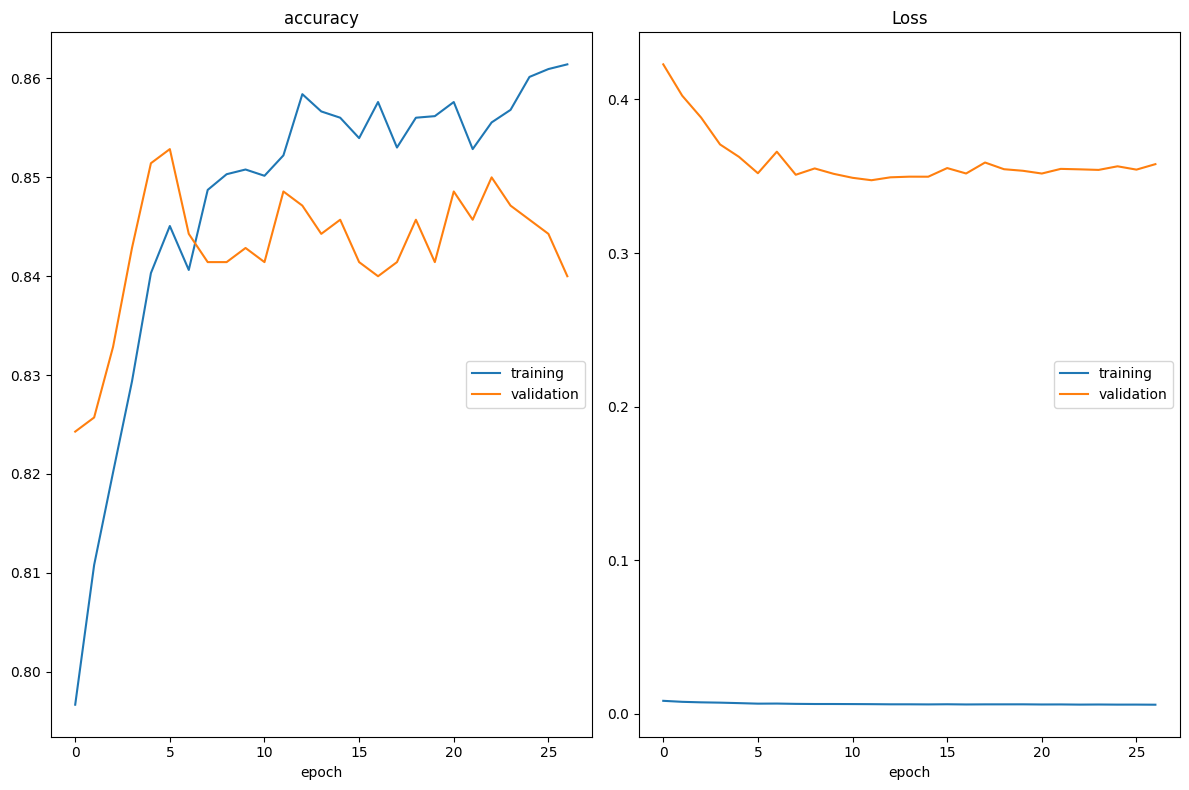

accuracy
	training         	 (min:    0.797, max:    0.861, cur:    0.861)
	validation       	 (min:    0.824, max:    0.853, cur:    0.840)
Loss
	training         	 (min:    0.006, max:    0.009, cur:    0.006)
	validation       	 (min:    0.347, max:    0.423, cur:    0.358)
Restoring model weights from the end of the best epoch: 12.
197/197 [==============================] - 2s 8ms/step - loss: 0.0060 - accuracy: 0.8614 - val_loss: 0.3579 - val_accuracy: 0.8400
Epoch 27: early stopping


In [62]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, Dense, Activation
# from keras.optimizers import Adam
# from tensorflow.keras.layers import Dropout
# from keras.callbacks import EarlyStopping


# # In each minibatch during the training, 0.2 of the nuerons will set to be = 0, it helps to redcue the overfitting potential 
# tf.random.set_seed(42)
# model_Optuna = Sequential(
#     [
#         Input(shape= X_train.shape[1]),  # Number of unputs [feature]
#         Dense(n_units1, activation="relu"),
#         Dropout(DO_rate1),
#         Dense(n_units2, activation="relu"),
#         Dropout(DO_rate2),
#         Dense(n_units3, activation="relu"),
#         Dropout(DO_rate3),
#         Dense(units=1, activation='sigmoid'),  #  1 neuron and Sigmoid because it is a bianry classification problem
#     ]
# )

# # # neg = y.value_counts()[0]
# # # pos = y.value_counts()[1]
# # # total = neg + pos

# # # # Scaling by total/2 helps keep the loss to a similar magnitude.
# # # # The sum of the weights of all examples stays the same.
# # # weight_for_0 = (1 / neg) * (total / 2.0)
# # # weight_for_1 = (1 / pos) * (total / 2.0)

# # # class_weight = {0: weight_for_0, 1: weight_for_1}

# # print('Weight for class 0: {:.2f}'.format(weight_for_0))
# # print('Weight for class 1: {:.2f}'.format(weight_for_1))


# # Complie
# model_Optuna.compile(optimizer=Adam(learning_rate=learning_rate),
#                      loss='binary_crossentropy',
#                      metrics='accuracy')

# #  live training loss plot 
# from livelossplot import PlotLossesKeras

# # Stop training when a monitored metric has stopped improving.
# early_stop = EarlyStopping(
#     monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True
# )



# # We are readt to fit the data
# model_Optuna.fit(
#     x=X_train, y=y_train, validation_split=0.1, batch_size=32, epochs=1000, verbose=1,  # 1000 epoch since there is early stopping
#     class_weight={0: w0, 1: w1},    
#     callbacks=[PlotLossesKeras(), early_stop]  # We add the erarly stop
    
# )

# # Since this is without early stopping, we will just use 500 epoch

### Evaluate The Model

- Plot the model history to observe the changing of metrics
- Make prediction to see "confusion matrix" and "classification report"
- Check ROC (Receiver Operating Curve) and AUC (Area Under Curve) for the model

In [63]:
# eval_metric(model_Optuna, X_train, y_train, X_test, y_test)

94/94 [==============================] - 0s 1ms/step
Test_Set
[[2319   70]
 [ 316  295]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2389
           1       0.81      0.48      0.60       611

    accuracy                           0.87      3000
   macro avg       0.84      0.73      0.76      3000
weighted avg       0.87      0.87      0.86      3000


Train_Set
[[5406  168]
 [ 789  637]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      5574
           1       0.79      0.45      0.57      1426

    accuracy                           0.86      7000
   macro avg       0.83      0.71      0.74      7000
weighted avg       0.86      0.86      0.85      7000



94/94 [==============================] - 0s 1ms/step


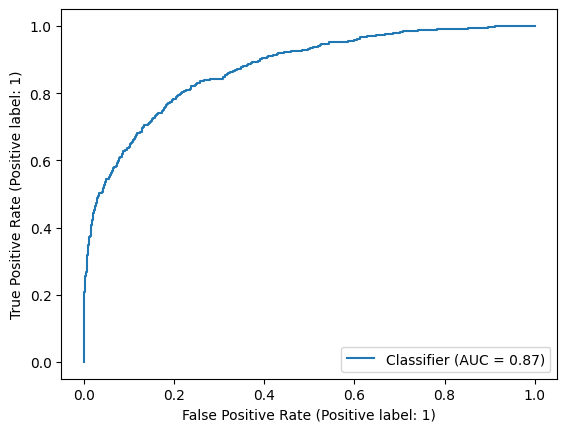

In [64]:
# ROC curve as the question satted, even though it is clearly imbalanced which means Precsion Vs Recall curve is better
y_pred_proba = model_Optuna.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

In [65]:
model_Optuna.weights

[<tf.Variable 'dense_424/kernel:0' shape=(13, 305) dtype=float32, numpy=
 array([[-0.08698772,  0.1211269 , -0.04916539, ...,  0.06060054,
         -0.0760825 , -0.04523483],
        [-0.10131939, -0.06577835,  0.12837245, ..., -0.10073584,
         -0.16269606, -0.10610969],
        [-0.04952975, -0.10807917,  0.05721261, ...,  0.07596669,
          0.04658866, -0.01394289],
        ...,
        [-0.0986232 , -0.0776123 ,  0.03339593, ...,  0.03009986,
         -0.10320338,  0.10002843],
        [ 0.10323076,  0.00565663, -0.05195935, ..., -0.10680505,
         -0.03663709,  0.08874001],
        [ 0.00357026,  0.02738268,  0.12006143, ..., -0.09042022,
         -0.07445388,  0.1271394 ]], dtype=float32)>,
 <tf.Variable 'dense_424/bias:0' shape=(305,) dtype=float32, numpy=
 array([-6.52205897e-03,  4.17119591e-03,  3.38781774e-02, -6.16842974e-03,
        -1.52094560e-02,  2.98499744e-02, -4.54470702e-02, -1.67351793e-02,
        -1.11252228e-02,  1.93734411e-02,  2.15536170e-02, -7.52

In [157]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping

trial_metric = "accuracy"
batch_size = 32


def create_model(trial):
   
    # Some hyperparameters we want to optimize
    first_hidden_layer = trial.suggest_int("input_layer_units", 8, 420)
    first_hidden_layer_dropout = trial.suggest_float("input_layer_dropout", 0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1.3e-1)
    optimizer = trial.suggest_categorical("optimizer", [Adam, Adadelta, RMSprop, Nadam])

    
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(first_hidden_layer, input_dim=X_train.shape[1], activation="relu"))
    
    # you can add the hidden layers automatically, see the example below:
    hidden_layers = trial.suggest_int("hidden_layers", 2, 6, log=True)
    for i in range(hidden_layers):
      hidden_layer_units = "hidden_layer_units_" + str(i)
      hidden_layer_units = trial.suggest_int(hidden_layer_units, 4, 128, log=True)
      dropout= "dropout_" + str(i)
      dropout = trial.suggest_float(dropout, 0, 0.5)
      
      model.add(Dense(hidden_layer_units, activation="relu"))
      model.add(Dropout(dropout))
    
    # we decided to use one neuron with sigmoid func in the output layer
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
      loss="binary_crossentropy",
      optimizer=optimizer(learning_rate=learning_rate),
      metrics=[trial_metric],
    )
    return model

def objective(trial):


    early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True)

    
    model = create_model(trial)
    w0 = trial.suggest_loguniform("w0", 0.00001, 100)
    w1 = trial.suggest_loguniform("w1", 0.001, 1000)
    model.fit(
        X_train,
        y_train,
        validation_split=0.1,
        batch_size=batch_size,
        epochs=1000,
        callbacks=[early_stop],
        class_weight={0: w0, 1: w1},
        verbose=0,
    )
    score = model.evaluate(X_test, y_test, verbose=0)[1]
    return score

In [158]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
study.best_params

[I 2023-10-30 15:22:21,582] A new study created in memory with name: no-name-bee9f1d0-9c56-4a49-96ef-e5f593f08e7e


Restoring model weights from the end of the best epoch: 120.
Epoch 135: early stopping


[I 2023-10-30 15:24:58,308] Trial 0 finished with value: 0.8456666469573975 and parameters: {'input_layer_units': 106, 'input_layer_dropout': 0.44813206625155655, 'learning_rate': 3.560299662390869e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 53, 'dropout_0': 0.45985377948257117, 'hidden_layer_units_1': 35, 'dropout_1': 0.10510024783528521, 'hidden_layer_units_2': 11, 'dropout_2': 0.234098547746308, 'hidden_layer_units_3': 13, 'dropout_3': 0.2730775023531368, 'hidden_layer_units_4': 99, 'dropout_4': 0.12260385137608665, 'w0': 0.16597288756965747, 'w1': 0.32609348364972296}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 15:25:14,794] Trial 1 finished with value: 0.20366667211055756 and parameters: {'input_layer_units': 185, 'input_layer_dropout': 0.4448261799130796, 'learning_rate': 0.013609777918495674, 'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'hidden_layers': 2, 'hidden_layer_units_0': 27, 'dropout_0': 0.059234735933689386, 'hidden_layer_units_1': 128, 'dropout_1': 0.44144059058591495, 'w0': 0.0006304029390418539, 'w1': 735.2205152348771}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 22.
Epoch 37: early stopping


[I 2023-10-30 15:26:04,387] Trial 2 finished with value: 0.3256666660308838 and parameters: {'input_layer_units': 300, 'input_layer_dropout': 0.07542467532312647, 'learning_rate': 0.0011145225388978972, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 3, 'hidden_layer_units_0': 123, 'dropout_0': 0.04635159714073617, 'hidden_layer_units_1': 15, 'dropout_1': 0.1592632254116546, 'hidden_layer_units_2': 8, 'dropout_2': 0.09574062832432612, 'w0': 0.48743264197507324, 'w1': 369.9189650794046}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 15:27:03,960] Trial 3 finished with value: 0.20366667211055756 and parameters: {'input_layer_units': 362, 'input_layer_dropout': 0.3458324231734315, 'learning_rate': 0.08757976239224277, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 124, 'dropout_0': 0.04960703803674965, 'hidden_layer_units_1': 8, 'dropout_1': 0.22077913450705972, 'hidden_layer_units_2': 35, 'dropout_2': 0.2126619162937915, 'hidden_layer_units_3': 17, 'dropout_3': 0.24912578182237521, 'hidden_layer_units_4': 6, 'dropout_4': 0.15589856021351522, 'w0': 0.006998365750944089, 'w1': 9.289615670722444}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 15:27:42,532] Trial 4 finished with value: 0.20366667211055756 and parameters: {'input_layer_units': 146, 'input_layer_dropout': 0.22110957594654707, 'learning_rate': 0.00029579442541048813, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 10, 'dropout_0': 0.3833415107065408, 'hidden_layer_units_1': 43, 'dropout_1': 0.0859814811846557, 'hidden_layer_units_2': 106, 'dropout_2': 0.4550547402086242, 'hidden_layer_units_3': 6, 'dropout_3': 0.13801906729279773, 'hidden_layer_units_4': 4, 'dropout_4': 0.4955282656510396, 'w0': 0.0014807072643645998, 'w1': 5.854506363277326}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 13.
Epoch 28: early stopping


[I 2023-10-30 15:28:19,715] Trial 5 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 76, 'input_layer_dropout': 0.119834819292236, 'learning_rate': 1.0657232065026212e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 3, 'hidden_layer_units_0': 81, 'dropout_0': 0.22863147344131574, 'hidden_layer_units_1': 4, 'dropout_1': 0.07741795083566266, 'hidden_layer_units_2': 8, 'dropout_2': 0.2668090561465472, 'w0': 0.03580565534130361, 'w1': 0.001637946490563683}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 15:28:38,954] Trial 6 finished with value: 0.20533333718776703 and parameters: {'input_layer_units': 181, 'input_layer_dropout': 0.10040396955737046, 'learning_rate': 4.351218953435238e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 2, 'hidden_layer_units_0': 20, 'dropout_0': 0.13123354855999225, 'hidden_layer_units_1': 21, 'dropout_1': 0.46351523102953984, 'w0': 0.023823036475525153, 'w1': 15.73609323101017}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 15:29:08,937] Trial 7 finished with value: 0.20366667211055756 and parameters: {'input_layer_units': 298, 'input_layer_dropout': 0.030378263949939754, 'learning_rate': 2.076789721518275e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 6, 'hidden_layer_units_0': 40, 'dropout_0': 0.4881859175653205, 'hidden_layer_units_1': 9, 'dropout_1': 0.4037159538915299, 'hidden_layer_units_2': 12, 'dropout_2': 0.3322042444779562, 'hidden_layer_units_3': 15, 'dropout_3': 0.15087000835550063, 'hidden_layer_units_4': 4, 'dropout_4': 0.04465973930312489, 'hidden_layer_units_5': 92, 'dropout_5': 0.06687067895383697, 'w0': 1.0290598134127444e-05, 'w1': 0.2676120304373703}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 50.
Epoch 65: early stopping


[I 2023-10-30 15:31:40,941] Trial 8 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 165, 'input_layer_dropout': 0.18874829410017663, 'learning_rate': 0.0029008925027863134, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 6, 'dropout_0': 0.3704790418612335, 'hidden_layer_units_1': 15, 'dropout_1': 0.04602073850473415, 'hidden_layer_units_2': 24, 'dropout_2': 0.3648429973228166, 'hidden_layer_units_3': 4, 'dropout_3': 0.13500235942252503, 'hidden_layer_units_4': 112, 'dropout_4': 0.32103746645974535, 'w0': 7.469217748684063, 'w1': 0.0024615540223204536}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 15:31:58,365] Trial 9 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 313, 'input_layer_dropout': 0.2528241902911967, 'learning_rate': 0.026563654576279273, 'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'hidden_layers': 2, 'hidden_layer_units_0': 7, 'dropout_0': 0.33196187493522505, 'hidden_layer_units_1': 11, 'dropout_1': 0.2782392648853318, 'w0': 6.636025554299685, 'w1': 0.007439013599069261}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 15:32:16,977] Trial 10 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 29, 'input_layer_dropout': 0.4787926432940004, 'learning_rate': 0.00012575293926163074, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 51, 'dropout_0': 0.4815550692702706, 'hidden_layer_units_1': 41, 'dropout_1': 0.01391056590330711, 'hidden_layer_units_2': 4, 'dropout_2': 0.025376310077263986, 'hidden_layer_units_3': 107, 'dropout_3': 0.41526248103241775, 'w0': 84.95205519238183, 'w1': 0.06457035103739768}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 15:32:43,142] Trial 11 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 46, 'input_layer_dropout': 0.363950754901631, 'learning_rate': 1.2778188629727085e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 65, 'dropout_0': 0.22856084139078958, 'hidden_layer_units_1': 4, 'dropout_1': 0.11476086135378478, 'hidden_layer_units_2': 8, 'dropout_2': 0.23007726774644255, 'w0': 0.18322417432317178, 'w1': 0.0012505638681449798}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 76.
Epoch 91: early stopping


[I 2023-10-30 15:34:31,603] Trial 12 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 91, 'input_layer_dropout': 0.16118136211144313, 'learning_rate': 1.05134777760759e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 72, 'dropout_0': 0.24210648112747524, 'hidden_layer_units_1': 4, 'dropout_1': 0.00163220752888954, 'hidden_layer_units_2': 4, 'dropout_2': 0.1759807710965408, 'hidden_layer_units_3': 44, 'dropout_3': 0.39320039580558236, 'w0': 0.0777278256663678, 'w1': 0.04173711694659041}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 15:34:59,344] Trial 13 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 98, 'input_layer_dropout': 0.4996874925461267, 'learning_rate': 6.551099168765413e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 3, 'hidden_layer_units_0': 30, 'dropout_0': 0.18391090838713592, 'hidden_layer_units_1': 6, 'dropout_1': 0.1424470078823203, 'hidden_layer_units_2': 13, 'dropout_2': 0.29830440010203196, 'w0': 0.5405077080694504, 'w1': 0.014765529116186856}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 15:35:18,204] Trial 14 finished with value: 0.20366667211055756 and parameters: {'input_layer_units': 102, 'input_layer_dropout': 0.2877222184857442, 'learning_rate': 0.00021705821528730757, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 76, 'dropout_0': 0.3124201088777586, 'hidden_layer_units_1': 32, 'dropout_1': 0.09672888605207355, 'hidden_layer_units_2': 8, 'dropout_2': 0.15522889954675742, 'hidden_layer_units_3': 10, 'dropout_3': 0.005089147456281973, 'w0': 0.00919162019255206, 'w1': 0.3977992526807568}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 15:35:35,052] Trial 15 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 243, 'input_layer_dropout': 0.13249583911457996, 'learning_rate': 4.5090212219862814e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 43, 'dropout_0': 0.26847421682347716, 'hidden_layer_units_1': 6, 'dropout_1': 0.20033385627264183, 'hidden_layer_units_2': 16, 'dropout_2': 0.2691321385665302, 'w0': 0.08763474797572152, 'w1': 0.0015044402749708724}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 6.
Epoch 21: early stopping


[I 2023-10-30 15:36:15,585] Trial 16 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 11, 'input_layer_dropout': 0.030922624932346376, 'learning_rate': 2.421713323152574e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 6, 'hidden_layer_units_0': 88, 'dropout_0': 0.42300946594866123, 'hidden_layer_units_1': 26, 'dropout_1': 0.061749642917341876, 'hidden_layer_units_2': 33, 'dropout_2': 0.37921102847942867, 'hidden_layer_units_3': 31, 'dropout_3': 0.48648172353378943, 'hidden_layer_units_4': 124, 'dropout_4': 0.011306941577495566, 'hidden_layer_units_5': 4, 'dropout_5': 0.42134350821945055, 'w0': 1.4061282004676543, 'w1': 0.06820080227167655}. Best is trial 0 with value: 0.8456666469573975.
[I 2023-10-30 15:54:36,882] Trial 17 finished with value: 0.2770000100135803 and parameters: {'input_layer_units': 242, 'input_layer_dropout': 0.4250684089133098, 'learning_rate': 1.0235648624781404e-05, 'optimizer': <class 'keras

Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 15:55:06,421] Trial 18 finished with value: 0.20366667211055756 and parameters: {'input_layer_units': 75, 'input_layer_dropout': 0.2860501220442242, 'learning_rate': 8.934434372082649e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 6, 'hidden_layer_units_0': 51, 'dropout_0': 0.17269523643653037, 'hidden_layer_units_1': 17, 'dropout_1': 0.26240014832935676, 'hidden_layer_units_2': 16, 'dropout_2': 0.14773022391200796, 'hidden_layer_units_3': 4, 'dropout_3': 0.26704419280697067, 'hidden_layer_units_4': 40, 'dropout_4': 0.20996747638857186, 'hidden_layer_units_5': 125, 'dropout_5': 0.4682541867324826, 'w0': 0.0018786301748793092, 'w1': 1.0394256774624804}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 6.
Epoch 21: early stopping


[I 2023-10-30 15:55:27,307] Trial 19 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 126, 'input_layer_dropout': 0.1997236025501886, 'learning_rate': 3.1598077570460144e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 4, 'dropout_0': 0.42509463597651265, 'hidden_layer_units_1': 22, 'dropout_1': 0.06289905935863968, 'hidden_layer_units_2': 6, 'dropout_2': 0.2343574183258499, 'w0': 0.17042347377775038, 'w1': 0.007445828134864165}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 15:55:44,516] Trial 20 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 419, 'input_layer_dropout': 0.14453642941372782, 'learning_rate': 0.00035183500765366855, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 91, 'dropout_0': 0.29626698499245185, 'hidden_layer_units_1': 12, 'dropout_1': 0.09815142693031602, 'hidden_layer_units_2': 10, 'dropout_2': 0.48887446356184466, 'hidden_layer_units_3': 26, 'dropout_3': 0.4959351037132037, 'w0': 2.1006306054557133, 'w1': 0.0010622989563117136}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 12.
Epoch 27: early stopping


[I 2023-10-30 15:56:46,277] Trial 21 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 169, 'input_layer_dropout': 0.18315240930824012, 'learning_rate': 0.002067332582656824, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 15, 'dropout_0': 0.3591524368215575, 'hidden_layer_units_1': 13, 'dropout_1': 0.038183425739230364, 'hidden_layer_units_2': 27, 'dropout_2': 0.34126470291114147, 'hidden_layer_units_3': 4, 'dropout_3': 0.17315425098666765, 'hidden_layer_units_4': 126, 'dropout_4': 0.33508557837158615, 'w0': 18.476168062814665, 'w1': 0.0038122483696818015}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 57.
Epoch 72: early stopping


[I 2023-10-30 15:59:18,196] Trial 22 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 62, 'input_layer_dropout': 0.22450890230856885, 'learning_rate': 0.0009679561471846289, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 29, 'dropout_0': 0.39321851786237727, 'hidden_layer_units_1': 18, 'dropout_1': 0.031385957232979864, 'hidden_layer_units_2': 24, 'dropout_2': 0.39351452348028404, 'hidden_layer_units_3': 11, 'dropout_3': 0.07866389126841393, 'hidden_layer_units_4': 54, 'dropout_4': 0.32561034038572606, 'w0': 1.8225462419792289, 'w1': 0.0233256570580009}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 54.
Epoch 69: early stopping


[I 2023-10-30 16:02:00,602] Trial 23 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 126, 'input_layer_dropout': 0.11748495638278457, 'learning_rate': 0.002360753854992593, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 4, 'dropout_0': 0.4469261955035032, 'hidden_layer_units_1': 7, 'dropout_1': 0.05751305118632449, 'hidden_layer_units_2': 17, 'dropout_2': 0.28361982602502345, 'hidden_layer_units_3': 6, 'dropout_3': 0.23251158969107877, 'hidden_layer_units_4': 53, 'dropout_4': 0.13129226397355134, 'hidden_layer_units_5': 14, 'dropout_5': 0.050516815175893015, 'w0': 83.6956979854405, 'w1': 0.003119102114162123}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 4.
Epoch 19: early stopping


[I 2023-10-30 16:02:45,038] Trial 24 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 211, 'input_layer_dropout': 0.1702014699526674, 'learning_rate': 2.6902962106412796e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 12, 'dropout_0': 0.36251988994594997, 'hidden_layer_units_1': 5, 'dropout_1': 0.002100596547671016, 'hidden_layer_units_2': 22, 'dropout_2': 0.3292048862721795, 'hidden_layer_units_3': 4, 'dropout_3': 0.20073956666666667, 'hidden_layer_units_4': 85, 'dropout_4': 0.27328772608797913, 'w0': 8.21375978669554, 'w1': 0.0033555351826661103}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 16:03:19,577] Trial 25 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 143, 'input_layer_dropout': 0.07853039358065586, 'learning_rate': 0.00013949676177802938, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 34, 'dropout_0': 0.4545623664006508, 'hidden_layer_units_1': 12, 'dropout_1': 0.13291657687687183, 'hidden_layer_units_2': 44, 'dropout_2': 0.3949767679054982, 'hidden_layer_units_3': 12, 'dropout_3': 0.3050861011954143, 'w0': 0.4789381518433382, 'w1': 0.018740135409975187}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 16:03:47,520] Trial 26 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 53, 'input_layer_dropout': 0.18362176045312076, 'learning_rate': 6.022351505015949e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 5, 'hidden_layer_units_0': 48, 'dropout_0': 0.4930589352886653, 'hidden_layer_units_1': 9, 'dropout_1': 0.06422599610832447, 'hidden_layer_units_2': 12, 'dropout_2': 0.2037198321653016, 'hidden_layer_units_3': 7, 'dropout_3': 0.12499860793186818, 'hidden_layer_units_4': 24, 'dropout_4': 0.1059011539054645, 'w0': 12.536814483939528, 'w1': 0.001011747675719989}. Best is trial 0 with value: 0.8456666469573975.


Restoring model weights from the end of the best epoch: 124.
Epoch 139: early stopping


[I 2023-10-30 16:09:12,437] Trial 27 finished with value: 0.8543333411216736 and parameters: {'input_layer_units': 220, 'input_layer_dropout': 0.24874258217980008, 'learning_rate': 1.824130419617459e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 23, 'dropout_0': 0.41019873028713266, 'hidden_layer_units_1': 4, 'dropout_1': 0.10649093122456493, 'hidden_layer_units_2': 17, 'dropout_2': 0.2517909160703133, 'hidden_layer_units_3': 16, 'dropout_3': 0.08311952344264611, 'hidden_layer_units_4': 85, 'dropout_4': 0.2082344932954654, 'hidden_layer_units_5': 30, 'dropout_5': 0.21519403638747853, 'w0': 0.05046495034990657, 'w1': 0.08143251077590952}. Best is trial 27 with value: 0.8543333411216736.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 16:09:33,340] Trial 28 finished with value: 0.21299999952316284 and parameters: {'input_layer_units': 220, 'input_layer_dropout': 0.3589540937257897, 'learning_rate': 1.79908518086587e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'hidden_layers': 6, 'hidden_layer_units_0': 23, 'dropout_0': 0.41260122796928345, 'hidden_layer_units_1': 4, 'dropout_1': 0.12374592257858702, 'hidden_layer_units_2': 18, 'dropout_2': 0.2434166557511607, 'hidden_layer_units_3': 19, 'dropout_3': 0.06520010776145685, 'hidden_layer_units_4': 70, 'dropout_4': 0.20666174327999817, 'hidden_layer_units_5': 30, 'dropout_5': 0.24009942804841866, 'w0': 0.058639707057968685, 'w1': 0.25155927021305574}. Best is trial 27 with value: 0.8543333411216736.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 16:09:48,579] Trial 29 finished with value: 0.7933333516120911 and parameters: {'input_layer_units': 219, 'input_layer_dropout': 0.42476311423593155, 'learning_rate': 4.154417032101403e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'hidden_layers': 2, 'hidden_layer_units_0': 25, 'dropout_0': 0.3455236254883604, 'hidden_layer_units_1': 5, 'dropout_1': 0.1692870592606351, 'w0': 0.008177673898582967, 'w1': 0.09654649833307594}. Best is trial 27 with value: 0.8543333411216736.


Restoring model weights from the end of the best epoch: 208.
Epoch 223: early stopping


[I 2023-10-30 16:14:06,617] Trial 30 finished with value: 0.8503333330154419 and parameters: {'input_layer_units': 264, 'input_layer_dropout': 0.31832067934879216, 'learning_rate': 1.726773324272593e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 36, 'dropout_0': 0.4092325826130875, 'hidden_layer_units_1': 113, 'dropout_1': 0.09325404322474327, 'hidden_layer_units_2': 11, 'dropout_2': 0.3043788817563793, 'hidden_layer_units_3': 14, 'dropout_3': 0.20595775652496745, 'hidden_layer_units_4': 33, 'dropout_4': 0.07532249616092146, 'hidden_layer_units_5': 31, 'dropout_5': 0.24922729243756755, 'w0': 0.021213319264367828, 'w1': 0.03255465210020026}. Best is trial 27 with value: 0.8543333411216736.


Restoring model weights from the end of the best epoch: 129.
Epoch 144: early stopping


[I 2023-10-30 16:16:57,210] Trial 31 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 267, 'input_layer_dropout': 0.3931840875063537, 'learning_rate': 1.8100655886129086e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 34, 'dropout_0': 0.4010238747498009, 'hidden_layer_units_1': 90, 'dropout_1': 0.09199409429668065, 'hidden_layer_units_2': 10, 'dropout_2': 0.2958129710955185, 'hidden_layer_units_3': 14, 'dropout_3': 0.1890067320017308, 'hidden_layer_units_4': 36, 'dropout_4': 0.08107282243824274, 'hidden_layer_units_5': 28, 'dropout_5': 0.24733817318273732, 'w0': 0.03534234703250496, 'w1': 0.031491879742256305}. Best is trial 27 with value: 0.8543333411216736.


Restoring model weights from the end of the best epoch: 389.
Epoch 404: early stopping


[I 2023-10-30 16:24:53,753] Trial 32 finished with value: 0.8636666536331177 and parameters: {'input_layer_units': 269, 'input_layer_dropout': 0.3159520211246578, 'learning_rate': 1.0206403944384119e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 57, 'dropout_0': 0.45227410045501476, 'hidden_layer_units_1': 123, 'dropout_1': 0.12474724888734995, 'hidden_layer_units_2': 14, 'dropout_2': 0.25549489226725536, 'hidden_layer_units_3': 21, 'dropout_3': 0.21850849819671728, 'hidden_layer_units_4': 70, 'dropout_4': 0.07038083351944574, 'hidden_layer_units_5': 44, 'dropout_5': 0.21512906543331714, 'w0': 0.2245240833186217, 'w1': 0.12404011819680061}. Best is trial 32 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 131.
Epoch 146: early stopping


[I 2023-10-30 16:27:42,445] Trial 33 finished with value: 0.8553333282470703 and parameters: {'input_layer_units': 332, 'input_layer_dropout': 0.3219819813682776, 'learning_rate': 2.8050330339826854e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 62, 'dropout_0': 0.4519505672068515, 'hidden_layer_units_1': 125, 'dropout_1': 0.11628309943613899, 'hidden_layer_units_2': 15, 'dropout_2': 0.2507263798518793, 'hidden_layer_units_3': 22, 'dropout_3': 0.20227112144036588, 'hidden_layer_units_4': 71, 'dropout_4': 0.06110345784808338, 'hidden_layer_units_5': 44, 'dropout_5': 0.20617296025849272, 'w0': 0.25091393154822333, 'w1': 0.0981012662980504}. Best is trial 32 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 170.
Epoch 185: early stopping


[I 2023-10-30 16:31:23,292] Trial 34 finished with value: 0.8629999756813049 and parameters: {'input_layer_units': 342, 'input_layer_dropout': 0.31508561530338247, 'learning_rate': 2.7006897615450676e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 40, 'dropout_0': 0.45025327433679474, 'hidden_layer_units_1': 107, 'dropout_1': 0.1186550589145262, 'hidden_layer_units_2': 13, 'dropout_2': 0.25624763551767027, 'hidden_layer_units_3': 22, 'dropout_3': 0.21493420516674788, 'hidden_layer_units_4': 59, 'dropout_4': 0.043948738577141315, 'hidden_layer_units_5': 45, 'dropout_5': 0.22094830941321028, 'w0': 0.24793922156414483, 'w1': 0.12438579300268841}. Best is trial 32 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 159.
Epoch 174: early stopping


[I 2023-10-30 16:34:48,836] Trial 35 finished with value: 0.8606666922569275 and parameters: {'input_layer_units': 353, 'input_layer_dropout': 0.3095057674895912, 'learning_rate': 2.882900017275811e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 62, 'dropout_0': 0.4581758202717754, 'hidden_layer_units_1': 112, 'dropout_1': 0.19333251432749565, 'hidden_layer_units_2': 15, 'dropout_2': 0.2603673604334666, 'hidden_layer_units_3': 24, 'dropout_3': 0.22263103370076678, 'hidden_layer_units_4': 69, 'dropout_4': 0.018552918588406957, 'hidden_layer_units_5': 50, 'dropout_5': 0.169088714310505, 'w0': 0.2484612460189218, 'w1': 0.16298650886948016}. Best is trial 32 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 58.
Epoch 73: early stopping


[I 2023-10-30 16:36:13,745] Trial 36 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 370, 'input_layer_dropout': 0.3271170813409044, 'learning_rate': 3.480035460235304e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 55, 'dropout_0': 0.4471707452021186, 'hidden_layer_units_1': 126, 'dropout_1': 0.19161385680556356, 'hidden_layer_units_2': 14, 'dropout_2': 0.20750619294982256, 'hidden_layer_units_3': 25, 'dropout_3': 0.2273183562018195, 'hidden_layer_units_4': 62, 'dropout_4': 0.0015321443702223658, 'hidden_layer_units_5': 61, 'dropout_5': 0.15684747361686988, 'w0': 0.4705090083851861, 'w1': 0.160209041300341}. Best is trial 32 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 16:37:03,938] Trial 37 finished with value: 0.8186666369438171 and parameters: {'input_layer_units': 355, 'input_layer_dropout': 0.3062029136078528, 'learning_rate': 6.623875120569048e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 63, 'dropout_0': 0.4630228977448267, 'hidden_layer_units_1': 88, 'dropout_1': 0.14642280786047054, 'hidden_layer_units_2': 19, 'dropout_2': 0.23486682418848964, 'hidden_layer_units_3': 34, 'dropout_3': 0.18393268237919908, 'hidden_layer_units_4': 69, 'dropout_4': 0.04737209416939409, 'w0': 0.2205146548134064, 'w1': 0.8704756453103379}. Best is trial 32 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 144.
Epoch 159: early stopping


[I 2023-10-30 16:40:08,129] Trial 38 finished with value: 0.8539999723434448 and parameters: {'input_layer_units': 330, 'input_layer_dropout': 0.34354274760106907, 'learning_rate': 2.8509817163388867e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 100, 'dropout_0': 0.49980827055496113, 'hidden_layer_units_1': 66, 'dropout_1': 0.22535249641886435, 'hidden_layer_units_2': 15, 'dropout_2': 0.1820382131962042, 'hidden_layer_units_3': 21, 'dropout_3': 0.22228617465813744, 'hidden_layer_units_4': 49, 'dropout_4': 0.0036539064964796336, 'hidden_layer_units_5': 57, 'dropout_5': 0.1620057174411277, 'w0': 0.7870458427377235, 'w1': 0.13007498401769632}. Best is trial 32 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 46.
Epoch 61: early stopping


[I 2023-10-30 16:41:15,912] Trial 39 finished with value: 0.812666654586792 and parameters: {'input_layer_units': 397, 'input_layer_dropout': 0.380700328235651, 'learning_rate': 9.971156695617032e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 115, 'dropout_0': 0.3814818715503714, 'hidden_layer_units_1': 105, 'dropout_1': 0.16882938726836194, 'hidden_layer_units_2': 21, 'dropout_2': 0.25755523848456374, 'hidden_layer_units_3': 20, 'dropout_3': 0.2649231569867683, 'hidden_layer_units_4': 73, 'dropout_4': 0.05273996939090727, 'w0': 0.2524421787515065, 'w1': 0.9322488073329913}. Best is trial 32 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 234.
Epoch 249: early stopping


[I 2023-10-30 16:45:52,361] Trial 40 finished with value: 0.8113333582878113 and parameters: {'input_layer_units': 336, 'input_layer_dropout': 0.2873641937449277, 'learning_rate': 1.022418562740561e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 42, 'dropout_0': 0.46632266661438637, 'hidden_layer_units_1': 75, 'dropout_1': 0.19050722379131638, 'hidden_layer_units_2': 13, 'dropout_2': 0.21650178123505937, 'hidden_layer_units_3': 41, 'dropout_3': 0.291659065695524, 'hidden_layer_units_4': 46, 'dropout_4': 0.07114111537733424, 'w0': 0.11473809429431892, 'w1': 0.4203361818907689}. Best is trial 32 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 190.
Epoch 205: early stopping


[I 2023-10-30 16:49:55,936] Trial 41 finished with value: 0.8629999756813049 and parameters: {'input_layer_units': 290, 'input_layer_dropout': 0.2617046438507666, 'learning_rate': 1.7884996734902104e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 56, 'dropout_0': 0.43254372041622013, 'hidden_layer_units_1': 114, 'dropout_1': 0.13802094634604073, 'hidden_layer_units_2': 18, 'dropout_2': 0.2521823018292052, 'hidden_layer_units_3': 24, 'dropout_3': 0.2384698108612518, 'hidden_layer_units_4': 92, 'dropout_4': 0.03530737177501194, 'hidden_layer_units_5': 44, 'dropout_5': 0.18654174077711044, 'w0': 0.07167963112253226, 'w1': 0.0634836710474738}. Best is trial 32 with value: 0.8636666536331177.


Restoring model weights from the end of the best epoch: 66.
Epoch 81: early stopping


[I 2023-10-30 16:51:33,031] Trial 42 finished with value: 0.8679999709129333 and parameters: {'input_layer_units': 297, 'input_layer_dropout': 0.3366579095949897, 'learning_rate': 4.2812311824864245e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 61, 'dropout_0': 0.4363318660837628, 'hidden_layer_units_1': 128, 'dropout_1': 0.12650046485890076, 'hidden_layer_units_2': 10, 'dropout_2': 0.26678639145993, 'hidden_layer_units_3': 23, 'dropout_3': 0.23765684735895712, 'hidden_layer_units_4': 90, 'dropout_4': 0.039266109648806585, 'hidden_layer_units_5': 53, 'dropout_5': 0.16100734640331638, 'w0': 0.24644530941817216, 'w1': 0.16827862314615663}. Best is trial 42 with value: 0.8679999709129333.


Restoring model weights from the end of the best epoch: 61.
Epoch 76: early stopping


[I 2023-10-30 16:53:07,217] Trial 43 finished with value: 0.846666693687439 and parameters: {'input_layer_units': 290, 'input_layer_dropout': 0.25968666494682596, 'learning_rate': 4.472530497314622e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 57, 'dropout_0': 0.47759071403190234, 'hidden_layer_units_1': 100, 'dropout_1': 0.14028115743369915, 'hidden_layer_units_2': 10, 'dropout_2': 0.3127331506247934, 'hidden_layer_units_3': 26, 'dropout_3': 0.24925565926957524, 'hidden_layer_units_4': 91, 'dropout_4': 0.028932464418965742, 'hidden_layer_units_5': 53, 'dropout_5': 0.14725931785323426, 'w0': 0.10604100740283223, 'w1': 0.18985378992906352}. Best is trial 42 with value: 0.8679999709129333.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 16:53:28,599] Trial 44 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 285, 'input_layer_dropout': 0.34575750740875016, 'learning_rate': 1.5827483693846917e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 72, 'dropout_0': 0.42854427403473505, 'hidden_layer_units_1': 124, 'dropout_1': 0.12204510280023652, 'hidden_layer_units_2': 20, 'dropout_2': 0.27772344880801153, 'hidden_layer_units_3': 17, 'dropout_3': 0.2491601686049804, 'hidden_layer_units_4': 96, 'dropout_4': 0.02998098849342007, 'hidden_layer_units_5': 50, 'dropout_5': 0.1469819635927879, 'w0': 0.9788790943089466, 'w1': 0.051812921851408254}. Best is trial 42 with value: 0.8679999709129333.


Restoring model weights from the end of the best epoch: 246.
Epoch 261: early stopping


[I 2023-10-30 16:58:11,299] Trial 45 finished with value: 0.8643333315849304 and parameters: {'input_layer_units': 311, 'input_layer_dropout': 0.3016671181432781, 'learning_rate': 1.4019603656266796e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 47, 'dropout_0': 0.499780278774181, 'hidden_layer_units_1': 93, 'dropout_1': 0.15647941152496936, 'hidden_layer_units_2': 13, 'dropout_2': 0.2622596454085744, 'hidden_layer_units_3': 18, 'dropout_3': 0.28507818764176174, 'hidden_layer_units_4': 60, 'dropout_4': 0.003208655104575549, 'w0': 0.317767577612558, 'w1': 0.4379325688315239}. Best is trial 42 with value: 0.8679999709129333.


Restoring model weights from the end of the best epoch: 6.
Epoch 21: early stopping


[I 2023-10-30 16:58:35,717] Trial 46 finished with value: 0.7963333129882812 and parameters: {'input_layer_units': 312, 'input_layer_dropout': 0.2706831035562475, 'learning_rate': 1.4443825484513526e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 45, 'dropout_0': 0.48324442262579165, 'hidden_layer_units_1': 88, 'dropout_1': 0.07793076858448005, 'hidden_layer_units_2': 12, 'dropout_2': 0.3145361810613658, 'hidden_layer_units_3': 19, 'dropout_3': 0.283566986710045, 'hidden_layer_units_4': 56, 'dropout_4': 0.08928381023353518, 'w0': 2.8509589570373426, 'w1': 0.514543947819078}. Best is trial 42 with value: 0.8679999709129333.


Restoring model weights from the end of the best epoch: 218.
Epoch 233: early stopping


[I 2023-10-30 17:02:59,038] Trial 47 finished with value: 0.8289999961853027 and parameters: {'input_layer_units': 381, 'input_layer_dropout': 0.2936427044534313, 'learning_rate': 1.3527792750691377e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 38, 'dropout_0': 0.49858191871299623, 'hidden_layer_units_1': 56, 'dropout_1': 0.1462408081596669, 'hidden_layer_units_2': 9, 'dropout_2': 0.2188607833682233, 'hidden_layer_units_3': 16, 'dropout_3': 0.3165906875254279, 'hidden_layer_units_4': 103, 'dropout_4': 0.11280902908146936, 'w0': 0.6571480401129935, 'w1': 2.0758824077421676}. Best is trial 42 with value: 0.8679999709129333.


Restoring model weights from the end of the best epoch: 239.
Epoch 254: early stopping


[I 2023-10-30 17:07:32,132] Trial 48 finished with value: 0.8613333106040955 and parameters: {'input_layer_units': 261, 'input_layer_dropout': 0.33159048669256125, 'learning_rate': 2.1797024830545855e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 49, 'dropout_0': 0.4320725791194556, 'hidden_layer_units_1': 101, 'dropout_1': 0.23350582410823628, 'hidden_layer_units_2': 13, 'dropout_2': 0.27689149889375775, 'hidden_layer_units_3': 29, 'dropout_3': 0.16626526686348736, 'hidden_layer_units_4': 96, 'dropout_4': 0.002351764136706301, 'w0': 0.07010299273941467, 'w1': 0.05115709646262989}. Best is trial 42 with value: 0.8679999709129333.


Restoring model weights from the end of the best epoch: 39.
Epoch 54: early stopping


[I 2023-10-30 17:08:35,971] Trial 49 finished with value: 0.859333336353302 and parameters: {'input_layer_units': 306, 'input_layer_dropout': 0.2267414983172436, 'learning_rate': 5.0586141333306745e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 73, 'dropout_0': 0.3856966010935507, 'hidden_layer_units_1': 87, 'dropout_1': 0.1580073408121491, 'hidden_layer_units_2': 7, 'dropout_2': 0.34873071941427686, 'hidden_layer_units_3': 36, 'dropout_3': 0.2730756196361541, 'hidden_layer_units_4': 79, 'dropout_4': 0.048977398956500995, 'hidden_layer_units_5': 83, 'dropout_5': 0.29972490175566036, 'w0': 0.3898748607344529, 'w1': 0.3247266571152747}. Best is trial 42 with value: 0.8679999709129333.


{'input_layer_units': 297,
 'input_layer_dropout': 0.3366579095949897,
 'learning_rate': 4.2812311824864245e-05,
 'optimizer': keras.optimizers.optimizer_v2.adam.Adam,
 'hidden_layers': 6,
 'hidden_layer_units_0': 61,
 'dropout_0': 0.4363318660837628,
 'hidden_layer_units_1': 128,
 'dropout_1': 0.12650046485890076,
 'hidden_layer_units_2': 10,
 'dropout_2': 0.26678639145993,
 'hidden_layer_units_3': 23,
 'dropout_3': 0.23765684735895712,
 'hidden_layer_units_4': 90,
 'dropout_4': 0.039266109648806585,
 'hidden_layer_units_5': 53,
 'dropout_5': 0.16100734640331638,
 'w0': 0.24644530941817216,
 'w1': 0.16827862314615663}

In [160]:
# build model with optuna parameters
hidden_layers = study.best_params["hidden_layers"]
input_layer_units = study.best_params["input_layer_units"]
input_layer_dropout = study.best_params["input_layer_dropout"]

optimizer = study.best_params["optimizer"]

hidden_layer_units_0 = study.best_params["hidden_layer_units_0"]
hidden_layer_units_1 = study.best_params["hidden_layer_units_1"]
hidden_layer_units_2 = study.best_params["hidden_layer_units_2"]
hidden_layer_units_3 = study.best_params["hidden_layer_units_3"]
hidden_layer_units_4 = study.best_params["hidden_layer_units_4"]
hidden_layer_units_5 = study.best_params["hidden_layer_units_5"]


dropout_0 = study.best_params["dropout_0"]
dropout_1 = study.best_params["dropout_1"]
dropout_2 = study.best_params["dropout_2"]
dropout_3 = study.best_params["dropout_3"]
dropout_4 = study.best_params["dropout_4"]
dropout_5 = study.best_params["dropout_5"]


learning_rate = study.best_params["learning_rate"]
w0 = study.best_params["w0"]
w1 = study.best_params["w1"]

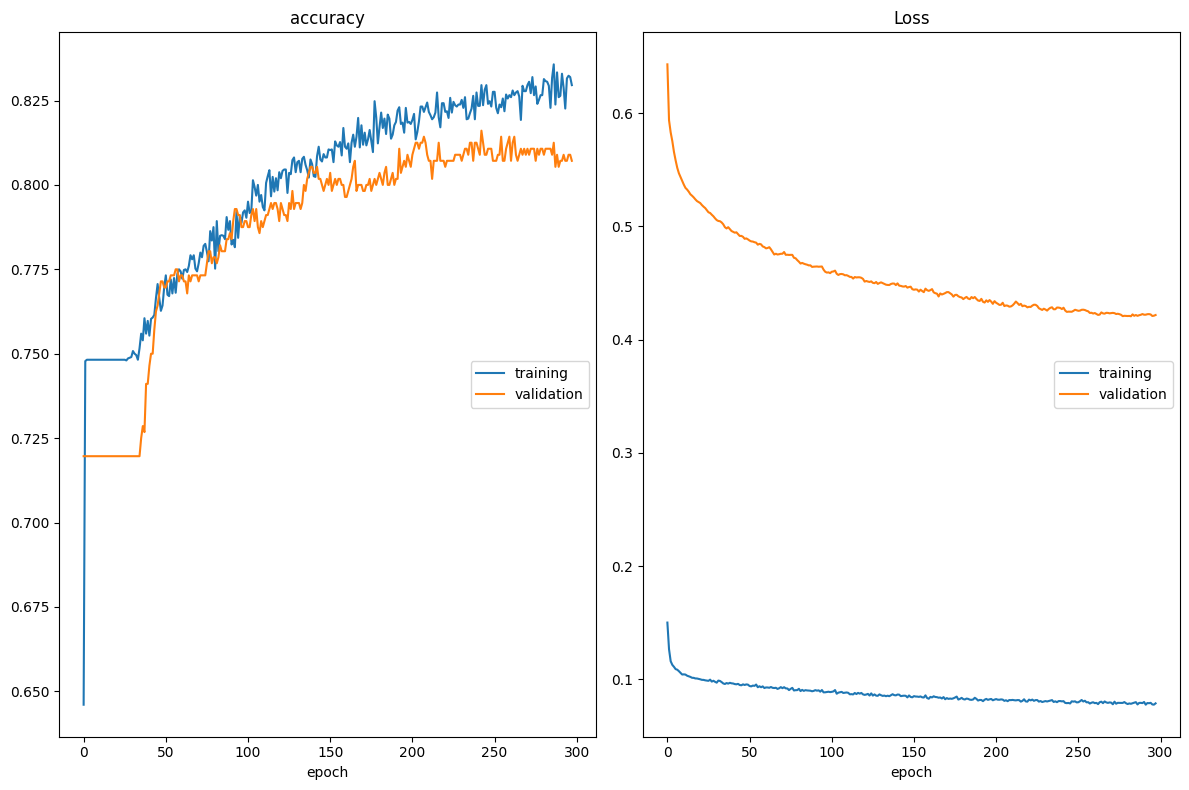

accuracy
	training         	 (min:    0.646, max:    0.836, cur:    0.830)
	validation       	 (min:    0.720, max:    0.816, cur:    0.807)
Loss
	training         	 (min:    0.078, max:    0.150, cur:    0.079)
	validation       	 (min:    0.421, max:    0.643, cur:    0.422)
Restoring model weights from the end of the best epoch: 283.
158/158 [==============================] - 1s 9ms/step - loss: 0.0789 - accuracy: 0.8296 - val_loss: 0.4217 - val_accuracy: 0.8071
Epoch 298: early stopping


In [161]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping


# In each minibatch during the training, 0.2 of the nuerons will set to be = 0, it helps to redcue the overfitting potential 
tf.random.set_seed(42)
model_Optuna_New = Sequential(
    [
        Input(shape= X_train_under.shape[1]),  # Number of unputs [feature]
        Dense(hidden_layer_units_0, activation="relu"),
        Dropout(dropout_0),
        Dense(hidden_layer_units_1, activation="relu"),
        Dropout(dropout_1),
        Dense(hidden_layer_units_2, activation="relu"),
        Dropout(dropout_2),
        Dense(hidden_layer_units_3, activation="relu"),
        Dropout(dropout_3),
        Dense(hidden_layer_units_4, activation="relu"),
        Dropout(dropout_4),
        Dense(hidden_layer_units_5, activation="relu"),
        Dropout(dropout_5),
        Dense(units=1, activation='sigmoid'),  #  1 neuron and Sigmoid because it is a bianry classification problem
    ]
)

# # neg = y.value_counts()[0]
# # pos = y.value_counts()[1]
# # total = neg + pos

# # # Scaling by total/2 helps keep the loss to a similar magnitude.
# # # The sum of the weights of all examples stays the same.
# # weight_for_0 = (1 / neg) * (total / 2.0)
# # weight_for_1 = (1 / pos) * (total / 2.0)

# # class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))


# Complie
model_Optuna_New.compile(optimizer=optimizer(learning_rate=learning_rate),
                     loss='binary_crossentropy',
                     metrics='accuracy')

#  live training loss plot 
from livelossplot import PlotLossesKeras

# Stop training when a monitored metric has stopped improving.
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True
)



# We are readt to fit the data
model_Optuna_New.fit(
    x=X_train_under, y=y_train_under, validation_split=0.1, batch_size=32, epochs=1000, verbose=1,  # 1000 epoch since there is early stopping
    class_weight={0: w0, 1: w1},    
    callbacks=[PlotLossesKeras(), early_stop]  # We add the erarly stop
    
)

# Since this is without early stopping, we will just use 500 epoch

### Evaluate The Model

- Plot the model history to observe the changing of metrics
- Make prediction to see "confusion matrix" and "classification report"
- Check ROC (Receiver Operating Curve) and AUC (Area Under Curve) for the model

In [162]:
eval_metric(model_Optuna_New, X_train_under, y_train_under, X_test_under, y_test_under)

75/75 [==============================] - 0s 2ms/step
Test_Set
[[1714   75]
 [ 314  297]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1789
           1       0.80      0.49      0.60       611

    accuracy                           0.84      2400
   macro avg       0.82      0.72      0.75      2400
weighted avg       0.83      0.84      0.82      2400


Train_Set
[[4011  163]
 [ 704  722]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4174
           1       0.82      0.51      0.62      1426

    accuracy                           0.85      5600
   macro avg       0.83      0.73      0.76      5600
weighted avg       0.84      0.85      0.83      5600



94/94 [==============================] - 0s 2ms/step


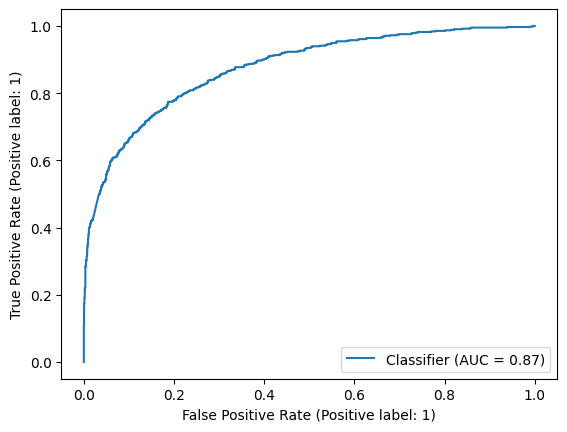

In [163]:
# ROC curve as the question satted, even though it is clearly imbalanced which means Precsion Vs Recall curve is better
y_pred_proba = model_Optuna_New.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

---------------------

## Optuna with Undersampling

We will try to do the same procesure but after reducing the number of -ve smaples since that dataset isn't that small
<br>
Undersampling is not recomended but there is no harm of trying... be curious!

In [145]:
df_under =  df.sort_values(["Exited"]).iloc[2000:,]  # Delete 2000 observations of  class 0
df_under.groupby(["Exited"]).count()  # Check

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,,,
0,5963,5963,5963,5963,5963,5963,5963,5963,5963,5963
1,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037


In [146]:
X_under = df_under.drop("Exited", axis="columns")
y_under = df_under["Exited"]

In [147]:
from sklearn.model_selection import train_test_split

X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X_under, y_under, test_size=0.3, random_state=42, stratify = y_under
)

In [148]:
# Check
print(y_train_under.shape)
print(X_train_under.shape)
print(X_test_under.shape)
print(y_test_under.shape)


(5600,)
(5600, 10)
(2400, 10)
(2400,)


- Do encoding for the categorical features
- Do scaling

In [149]:
X_train_under = pipe_model.fit_transform(X_train_under)
X_test_under = pipe_model.transform(X_test_under)

In [151]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping

trial_metric = "accuracy"
batch_size = 32


def create_model(trial):
   
    # Some hyperparameters we want to optimize
    first_hidden_layer = trial.suggest_int("input_layer_units", 8, 420)
    first_hidden_layer_dropout = trial.suggest_float("input_layer_dropout", 0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1.3e-1)
    optimizer = trial.suggest_categorical("optimizer", [Adam, Adadelta, RMSprop, Nadam])

    
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(first_hidden_layer, input_dim=X_train.shape[1], activation="relu"))
    
    # you can add the hidden layers automatically, see the example below:
    hidden_layers = trial.suggest_int("hidden_layers", 2, 6, log=True)
    for i in range(hidden_layers):
      hidden_layer_units = "hidden_layer_units_" + str(i)
      hidden_layer_units = trial.suggest_int(hidden_layer_units, 4, 128, log=True)
      dropout= "dropout_" + str(i)
      dropout = trial.suggest_float(dropout, 0, 0.5)
      
      model.add(Dense(hidden_layer_units, activation="relu"))
      model.add(Dropout(dropout))
    
    # we decided to use one neuron with sigmoid func in the output layer
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
      loss="binary_crossentropy",
      optimizer=optimizer(learning_rate=learning_rate),
      metrics=[trial_metric],
    )
    return model



def objective(trial):

    # weight_for_0 = (1 / neg) * (total / 2.0)
    # weight_for_1 = (1 / pos) * (total / 2.0)
    # class_weight = {0: weight_for_0, 1: weight_for_1}


    early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True)

    
    model = create_model(trial)
    w0 = trial.suggest_loguniform("w0", 0.00001, 1000)
    w1 = trial.suggest_loguniform("w1", 0.001, 10000)
    model.fit(
        X_train_under,
        y_train_under,
        validation_split=0.1,
        batch_size=batch_size,
        epochs=1000,
        callbacks=[early_stop],
        class_weight={0: w0, 1: w1},
        verbose=0,
    )
    score = model.evaluate(X_test_under, y_test_under, verbose=0)[1]
    return score

In [152]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
study.best_params

[I 2023-10-30 13:07:05,275] A new study created in memory with name: no-name-65ac7689-fb47-4a85-87af-dbfea251aa30


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 13:07:21,309] Trial 0 finished with value: 0.7454166412353516 and parameters: {'input_layer_units': 18, 'input_layer_dropout': 0.28481349800766625, 'learning_rate': 0.001507905841293705, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 18, 'dropout_0': 0.4241830448817608, 'hidden_layer_units_1': 35, 'dropout_1': 0.13262339613134283, 'hidden_layer_units_2': 7, 'dropout_2': 0.36586652944869186, 'hidden_layer_units_3': 4, 'dropout_3': 0.029399130052499278, 'hidden_layer_units_4': 5, 'dropout_4': 0.005720691383912124, 'w0': 52.44034312076928, 'w1': 0.011754961344086545}. Best is trial 0 with value: 0.7454166412353516.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 13:07:39,179] Trial 1 finished with value: 0.7454166412353516 and parameters: {'input_layer_units': 200, 'input_layer_dropout': 0.4711235792397052, 'learning_rate': 0.006658221976551283, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 17, 'dropout_0': 0.08084385069733058, 'hidden_layer_units_1': 5, 'dropout_1': 0.32849730198037114, 'hidden_layer_units_2': 18, 'dropout_2': 0.008653919269905053, 'hidden_layer_units_3': 7, 'dropout_3': 0.30246002644304276, 'hidden_layer_units_4': 4, 'dropout_4': 0.3539692947054993, 'w0': 55.58334612810158, 'w1': 0.7114399380279613}. Best is trial 0 with value: 0.7454166412353516.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 13:08:11,388] Trial 2 finished with value: 0.8133333325386047 and parameters: {'input_layer_units': 44, 'input_layer_dropout': 0.34222858741427997, 'learning_rate': 0.0028103483736911126, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 12, 'dropout_0': 0.46578903427606944, 'hidden_layer_units_1': 8, 'dropout_1': 0.03490351738760017, 'w0': 0.001639794717672468, 'w1': 0.00539020423200127}. Best is trial 2 with value: 0.8133333325386047.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 13:08:25,114] Trial 3 finished with value: 0.30000001192092896 and parameters: {'input_layer_units': 181, 'input_layer_dropout': 0.31917574271374943, 'learning_rate': 0.010629211247277686, 'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'hidden_layers': 3, 'hidden_layer_units_0': 43, 'dropout_0': 0.1852761531082866, 'hidden_layer_units_1': 106, 'dropout_1': 0.2525654997902928, 'hidden_layer_units_2': 22, 'dropout_2': 0.3997061761266334, 'w0': 2.8822892308761343, 'w1': 38.0702986437763}. Best is trial 2 with value: 0.8133333325386047.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 13:08:37,151] Trial 4 finished with value: 0.25458332896232605 and parameters: {'input_layer_units': 300, 'input_layer_dropout': 0.07082424753211264, 'learning_rate': 0.0172455882849664, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 55, 'dropout_0': 0.0952601136878139, 'hidden_layer_units_1': 5, 'dropout_1': 0.4434866053946422, 'w0': 0.0005721350176156312, 'w1': 0.6428260221965397}. Best is trial 2 with value: 0.8133333325386047.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 13:08:53,498] Trial 5 finished with value: 0.25458332896232605 and parameters: {'input_layer_units': 279, 'input_layer_dropout': 0.32234782024772896, 'learning_rate': 0.0008028177274196723, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 43, 'dropout_0': 0.33921577637316286, 'hidden_layer_units_1': 70, 'dropout_1': 0.02173628038303521, 'hidden_layer_units_2': 22, 'dropout_2': 0.4131590986543326, 'hidden_layer_units_3': 25, 'dropout_3': 0.19713776044146286, 'hidden_layer_units_4': 9, 'dropout_4': 0.4815926914513646, 'hidden_layer_units_5': 11, 'dropout_5': 0.44611628755661603, 'w0': 0.3719159251339725, 'w1': 6.500210552213912}. Best is trial 2 with value: 0.8133333325386047.


Restoring model weights from the end of the best epoch: 39.
Epoch 54: early stopping


[I 2023-10-30 13:09:32,010] Trial 6 finished with value: 0.8333333134651184 and parameters: {'input_layer_units': 60, 'input_layer_dropout': 0.11469402575429338, 'learning_rate': 0.0002568817700054634, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 4, 'dropout_0': 0.30491115751976383, 'hidden_layer_units_1': 54, 'dropout_1': 0.4090773727885917, 'w0': 0.048234623272016684, 'w1': 0.11141095690221937}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 13:09:49,047] Trial 7 finished with value: 0.2737500071525574 and parameters: {'input_layer_units': 21, 'input_layer_dropout': 0.3043452234422998, 'learning_rate': 3.348168177760633e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'hidden_layers': 5, 'hidden_layer_units_0': 86, 'dropout_0': 0.3231788166408988, 'hidden_layer_units_1': 52, 'dropout_1': 0.1918352785185355, 'hidden_layer_units_2': 13, 'dropout_2': 0.2491517669959073, 'hidden_layer_units_3': 17, 'dropout_3': 0.26242879873371067, 'hidden_layer_units_4': 26, 'dropout_4': 0.25153280024710856, 'w0': 97.72665060772465, 'w1': 7837.205560066674}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 13:10:06,393] Trial 8 finished with value: 0.25458332896232605 and parameters: {'input_layer_units': 391, 'input_layer_dropout': 0.0708564052964844, 'learning_rate': 2.2205041418183212e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 3, 'hidden_layer_units_0': 5, 'dropout_0': 0.09432509805607969, 'hidden_layer_units_1': 89, 'dropout_1': 0.2475302130624032, 'hidden_layer_units_2': 18, 'dropout_2': 0.007495155357226946, 'w0': 0.0003004718948415536, 'w1': 0.030352656266828853}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 13:10:18,876] Trial 9 finished with value: 0.27666667103767395 and parameters: {'input_layer_units': 215, 'input_layer_dropout': 0.16247932866963521, 'learning_rate': 7.221382622729709e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'hidden_layers': 2, 'hidden_layer_units_0': 26, 'dropout_0': 0.23017348122441295, 'hidden_layer_units_1': 4, 'dropout_1': 0.17920135674068627, 'w0': 0.005108475628180055, 'w1': 3349.9699377989655}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 9.
Epoch 24: early stopping


[I 2023-10-30 13:10:49,321] Trial 10 finished with value: 0.25458332896232605 and parameters: {'input_layer_units': 113, 'input_layer_dropout': 0.00884214045740428, 'learning_rate': 0.04835317073612584, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 4, 'dropout_0': 0.29930504858421664, 'hidden_layer_units_1': 18, 'dropout_1': 0.4840417280849832, 'w0': 1.383066917579541e-05, 'w1': 0.0018203646779523456}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 140.
Epoch 155: early stopping


[I 2023-10-30 13:14:08,641] Trial 11 finished with value: 0.7716666460037231 and parameters: {'input_layer_units': 93, 'input_layer_dropout': 0.17835085795417138, 'learning_rate': 0.00020833120509531456, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 7, 'dropout_0': 0.48986653393352986, 'hidden_layer_units_1': 18, 'dropout_1': 0.017827207053225103, 'w0': 0.007867652354240657, 'w1': 0.037836171182226985}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 120.
Epoch 135: early stopping


[I 2023-10-30 13:17:23,988] Trial 12 finished with value: 0.7454166412353516 and parameters: {'input_layer_units': 90, 'input_layer_dropout': 0.40482938007055597, 'learning_rate': 0.0006316131557590288, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 10, 'dropout_0': 0.40391215341388714, 'hidden_layer_units_1': 14, 'dropout_1': 0.38691974688357134, 'hidden_layer_units_2': 128, 'dropout_2': 0.4971046677169061, 'w0': 0.0672917723919178, 'w1': 0.0019783553883787586}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 33.
Epoch 48: early stopping


[I 2023-10-30 13:18:09,058] Trial 13 finished with value: 0.82791668176651 and parameters: {'input_layer_units': 60, 'input_layer_dropout': 0.2113183220165502, 'learning_rate': 0.0029515310382184365, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 2, 'hidden_layer_units_0': 8, 'dropout_0': 0.49682752043763123, 'hidden_layer_units_1': 9, 'dropout_1': 0.36967963460591385, 'w0': 0.11314250652130893, 'w1': 0.11796482963971297}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 79.
Epoch 94: early stopping


[I 2023-10-30 13:19:36,956] Trial 14 finished with value: 0.7816666960716248 and parameters: {'input_layer_units': 136, 'input_layer_dropout': 0.20215803117857659, 'learning_rate': 0.00019887702750087598, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 2, 'hidden_layer_units_0': 4, 'dropout_0': 0.40391146489055235, 'hidden_layer_units_1': 33, 'dropout_1': 0.377316932972787, 'w0': 0.15313898445699242, 'w1': 0.11167129646389069}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 29.
Epoch 44: early stopping


[I 2023-10-30 13:20:24,054] Trial 15 finished with value: 0.7454166412353516 and parameters: {'input_layer_units': 65, 'input_layer_dropout': 0.23053431856672535, 'learning_rate': 1.013379912581795e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 3, 'hidden_layer_units_0': 7, 'dropout_0': 0.4915152518362213, 'hidden_layer_units_1': 128, 'dropout_1': 0.483487690321729, 'hidden_layer_units_2': 5, 'dropout_2': 0.16493163403408517, 'w0': 1.8625748015338848, 'w1': 0.3353209808238569}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 23.
Epoch 38: early stopping


[I 2023-10-30 13:21:01,282] Trial 16 finished with value: 0.8295833468437195 and parameters: {'input_layer_units': 159, 'input_layer_dropout': 0.13725255523604613, 'learning_rate': 0.0021912269269416143, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 2, 'hidden_layer_units_0': 6, 'dropout_0': 0.35691243798838407, 'hidden_layer_units_1': 10, 'dropout_1': 0.34589587504597086, 'w0': 0.029928406066667818, 'w1': 0.07144226960291664}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 17.
Epoch 32: early stopping


[I 2023-10-30 13:21:27,516] Trial 17 finished with value: 0.8333333134651184 and parameters: {'input_layer_units': 149, 'input_layer_dropout': 0.14355008661078614, 'learning_rate': 0.0002954591970929494, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 5, 'dropout_0': 0.268279212802236, 'hidden_layer_units_1': 31, 'dropout_1': 0.31113516851861, 'hidden_layer_units_2': 63, 'dropout_2': 0.15727179909716613, 'w0': 0.020028393700637682, 'w1': 0.012069832269435884}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 13:21:41,826] Trial 18 finished with value: 0.7454166412353516 and parameters: {'input_layer_units': 239, 'input_layer_dropout': 0.12123290222841832, 'learning_rate': 0.0003083334318711206, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 4, 'dropout_0': 0.24496067702858612, 'hidden_layer_units_1': 30, 'dropout_1': 0.4283882954071395, 'hidden_layer_units_2': 66, 'dropout_2': 0.15722771354848983, 'hidden_layer_units_3': 113, 'dropout_3': 0.49202442362187665, 'w0': 934.2711291204548, 'w1': 0.006259529477758973}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 13:21:56,798] Trial 19 finished with value: 0.7454166412353516 and parameters: {'input_layer_units': 139, 'input_layer_dropout': 0.24952043350205005, 'learning_rate': 6.637377212127012e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 11, 'dropout_0': 0.2831375292429236, 'hidden_layer_units_1': 55, 'dropout_1': 0.3184946609051216, 'hidden_layer_units_2': 48, 'dropout_2': 0.11939751110448243, 'hidden_layer_units_3': 106, 'dropout_3': 0.05154193920498945, 'w0': 0.01048365844245157, 'w1': 0.0010295978691601104}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 33.
Epoch 48: early stopping


[I 2023-10-30 13:22:35,388] Trial 20 finished with value: 0.7454166412353516 and parameters: {'input_layer_units': 376, 'input_layer_dropout': 0.11222253974669805, 'learning_rate': 0.0005069536570424971, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 5, 'dropout_0': 0.17679263248675844, 'hidden_layer_units_1': 47, 'dropout_1': 0.2928661918248294, 'hidden_layer_units_2': 43, 'dropout_2': 0.2686457610407618, 'w0': 0.3886276753996355, 'w1': 0.013595531143184644}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 13:22:59,941] Trial 21 finished with value: 0.8145833611488342 and parameters: {'input_layer_units': 166, 'input_layer_dropout': 0.1404320366461508, 'learning_rate': 0.0014698119498687127, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 2, 'hidden_layer_units_0': 6, 'dropout_0': 0.3506348937348445, 'hidden_layer_units_1': 25, 'dropout_1': 0.3499531507032234, 'w0': 0.021240244582260922, 'w1': 0.058760190636456024}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 102.
Epoch 117: early stopping


[I 2023-10-30 13:24:38,760] Trial 22 finished with value: 0.7562500238418579 and parameters: {'input_layer_units': 143, 'input_layer_dropout': 0.1699461224831111, 'learning_rate': 0.0001359719338707435, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 6, 'dropout_0': 0.366886996565437, 'hidden_layer_units_1': 23, 'dropout_1': 0.409561451384166, 'hidden_layer_units_2': 106, 'dropout_2': 0.08559990581096788, 'hidden_layer_units_3': 40, 'dropout_3': 0.496126513923164, 'w0': 0.03309623345213563, 'w1': 0.2379563625667623}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 29.
Epoch 44: early stopping


[I 2023-10-30 13:25:25,235] Trial 23 finished with value: 0.815416693687439 and parameters: {'input_layer_units': 249, 'input_layer_dropout': 0.11665837632644173, 'learning_rate': 0.0004737438262384779, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 3, 'hidden_layer_units_0': 4, 'dropout_0': 0.2761565893359944, 'hidden_layer_units_1': 39, 'dropout_1': 0.34507272960956004, 'hidden_layer_units_2': 38, 'dropout_2': 0.24668769609418661, 'w0': 0.0043242027513318675, 'w1': 0.01912915250367484}. Best is trial 6 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 13:25:43,853] Trial 24 finished with value: 0.8379166722297668 and parameters: {'input_layer_units': 101, 'input_layer_dropout': 0.07684101007498015, 'learning_rate': 0.0010774243083114376, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 9, 'dropout_0': 0.3095731379995965, 'hidden_layer_units_1': 74, 'dropout_1': 0.4105321051447514, 'w0': 0.04153936098927295, 'w1': 0.07993208416081965}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 13:26:04,366] Trial 25 finished with value: 0.8012499809265137 and parameters: {'input_layer_units': 108, 'input_layer_dropout': 0.06496274151973812, 'learning_rate': 0.0008598842631741595, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 9, 'dropout_0': 0.29839201080009337, 'hidden_layer_units_1': 72, 'dropout_1': 0.4180115532220852, 'hidden_layer_units_2': 81, 'dropout_2': 0.0737798355972642, 'hidden_layer_units_3': 10, 'dropout_3': 0.36420190383471507, 'w0': 0.47144213211924707, 'w1': 2.0393263439475007}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 26.
Epoch 41: early stopping


[I 2023-10-30 13:26:36,978] Trial 26 finished with value: 0.768750011920929 and parameters: {'input_layer_units': 67, 'input_layer_dropout': 0.003336879592125211, 'learning_rate': 0.00033661869318100403, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 13, 'dropout_0': 0.2216032938947139, 'hidden_layer_units_1': 67, 'dropout_1': 0.4405319695098184, 'hidden_layer_units_2': 33, 'dropout_2': 0.19151955570329893, 'w0': 0.04793902333748114, 'w1': 0.004325501063482677}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 13:26:49,938] Trial 27 finished with value: 0.28583332896232605 and parameters: {'input_layer_units': 115, 'input_layer_dropout': 0.08250525386277799, 'learning_rate': 0.00011438784955476359, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 8, 'dropout_0': 0.25965631111133525, 'hidden_layer_units_1': 44, 'dropout_1': 0.3988548985722698, 'w0': 0.0013565582602797842, 'w1': 0.038564164799959076}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 80.
Epoch 95: early stopping


[I 2023-10-30 13:28:20,626] Trial 28 finished with value: 0.8304166793823242 and parameters: {'input_layer_units': 11, 'input_layer_dropout': 0.028199331557530682, 'learning_rate': 0.00026410347938666764, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 5, 'dropout_0': 0.3106130762965335, 'hidden_layer_units_1': 90, 'dropout_1': 0.4644002505036289, 'hidden_layer_units_2': 65, 'dropout_2': 0.2961745726981798, 'hidden_layer_units_3': 46, 'dropout_3': 0.13946470218169205, 'hidden_layer_units_4': 119, 'dropout_4': 0.01141997072440265, 'hidden_layer_units_5': 123, 'dropout_5': 0.11603559805086189, 'w0': 0.014116699848230864, 'w1': 0.012431654000644866}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 26.
Epoch 41: early stopping


[I 2023-10-30 13:28:55,962] Trial 29 finished with value: 0.7454166412353516 and parameters: {'input_layer_units': 28, 'input_layer_dropout': 0.037673702352636965, 'learning_rate': 0.0009348641838830278, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 15, 'dropout_0': 0.3944951669564614, 'hidden_layer_units_1': 35, 'dropout_1': 0.29725694012328113, 'hidden_layer_units_2': 91, 'dropout_2': 0.18737717290100114, 'hidden_layer_units_3': 4, 'dropout_3': 0.001666908312861648, 'w0': 3.3318177232609987, 'w1': 0.012282413286825245}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 13:29:15,108] Trial 30 finished with value: 0.8345833420753479 and parameters: {'input_layer_units': 189, 'input_layer_dropout': 0.09896617424608505, 'learning_rate': 0.0014320591102917428, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 10, 'dropout_0': 0.3195207371322004, 'hidden_layer_units_1': 58, 'dropout_1': 0.49874372715475634, 'hidden_layer_units_2': 60, 'dropout_2': 0.3227197379339579, 'w0': 0.11826017610903951, 'w1': 0.20710106179727697}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 9.
Epoch 24: early stopping


[I 2023-10-30 13:29:34,710] Trial 31 finished with value: 0.8337500095367432 and parameters: {'input_layer_units': 182, 'input_layer_dropout': 0.10057182781834911, 'learning_rate': 0.0016405020832762855, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 9, 'dropout_0': 0.3111569441563735, 'hidden_layer_units_1': 59, 'dropout_1': 0.49870289117356703, 'hidden_layer_units_2': 66, 'dropout_2': 0.3051045510369125, 'w0': 0.12301836370421915, 'w1': 0.175816864973354}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 9.
Epoch 24: early stopping


[I 2023-10-30 13:29:54,316] Trial 32 finished with value: 0.8329166769981384 and parameters: {'input_layer_units': 203, 'input_layer_dropout': 0.08679838970698389, 'learning_rate': 0.001279873711481211, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 10, 'dropout_0': 0.3311439493842938, 'hidden_layer_units_1': 59, 'dropout_1': 0.4782246369642426, 'hidden_layer_units_2': 127, 'dropout_2': 0.3233855480912179, 'w0': 0.11568643353248714, 'w1': 0.1998936906342916}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 13.
Epoch 28: early stopping


[I 2023-10-30 13:30:22,258] Trial 33 finished with value: 0.8370833396911621 and parameters: {'input_layer_units': 186, 'input_layer_dropout': 0.04368822431674257, 'learning_rate': 0.0030216368230736213, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 14, 'dropout_0': 0.31617233995036986, 'hidden_layer_units_1': 44, 'dropout_1': 0.4953942819569468, 'hidden_layer_units_2': 54, 'dropout_2': 0.3326387401785927, 'hidden_layer_units_3': 11, 'dropout_3': 0.12150408020690279, 'hidden_layer_units_4': 33, 'dropout_4': 0.1432630223825171, 'w0': 1.1971577948172756, 'w1': 0.8018951503246594}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 17.
Epoch 32: early stopping


[I 2023-10-30 13:30:55,472] Trial 34 finished with value: 0.8320833444595337 and parameters: {'input_layer_units': 185, 'input_layer_dropout': 0.03859669337202063, 'learning_rate': 0.004138698163568224, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 18, 'dropout_0': 0.4375411791342755, 'hidden_layer_units_1': 42, 'dropout_1': 0.4927043012327901, 'hidden_layer_units_2': 51, 'dropout_2': 0.3330306010167045, 'hidden_layer_units_3': 11, 'dropout_3': 0.1472235953946395, 'hidden_layer_units_4': 39, 'dropout_4': 0.14321314584978395, 'w0': 0.8674374043033702, 'w1': 0.6919466929671222}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 259.
Epoch 274: early stopping


[I 2023-10-30 13:35:47,592] Trial 35 finished with value: 0.7691666483879089 and parameters: {'input_layer_units': 224, 'input_layer_dropout': 0.057679243053404224, 'learning_rate': 0.005278710671251993, 'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'hidden_layers': 6, 'hidden_layer_units_0': 13, 'dropout_0': 0.3694795950680876, 'hidden_layer_units_1': 83, 'dropout_1': 0.45272421719903827, 'hidden_layer_units_2': 83, 'dropout_2': 0.2953025427624313, 'hidden_layer_units_3': 19, 'dropout_3': 0.09819176420207801, 'hidden_layer_units_4': 55, 'dropout_4': 0.16249021195977126, 'hidden_layer_units_5': 4, 'dropout_5': 0.008756171907588983, 'w0': 0.9580707274852011, 'w1': 1.9025038340788873}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 13.
Epoch 28: early stopping


[I 2023-10-30 13:36:13,910] Trial 36 finished with value: 0.8287500143051147 and parameters: {'input_layer_units': 273, 'input_layer_dropout': 0.09355233207096972, 'learning_rate': 0.0018703870721254985, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 16, 'dropout_0': 0.3224332336233352, 'hidden_layer_units_1': 60, 'dropout_1': 0.4989594796828384, 'hidden_layer_units_2': 33, 'dropout_2': 0.3619350021398197, 'hidden_layer_units_3': 7, 'dropout_3': 0.09857825592412328, 'hidden_layer_units_4': 13, 'dropout_4': 0.14117866815061178, 'w0': 3.5119071976562024, 'w1': 0.6103123251188152}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 6.
Epoch 21: early stopping


[I 2023-10-30 13:36:33,962] Trial 37 finished with value: 0.7454166412353516 and parameters: {'input_layer_units': 182, 'input_layer_dropout': 0.046238026819359596, 'learning_rate': 0.007770061206280097, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 23, 'dropout_0': 0.37407825178992665, 'hidden_layer_units_1': 107, 'dropout_1': 0.44909615849717516, 'hidden_layer_units_2': 58, 'dropout_2': 0.22915358485685583, 'hidden_layer_units_3': 13, 'dropout_3': 0.21314860953302628, 'w0': 11.965571015693584, 'w1': 0.3438024674687079}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 29.
Epoch 44: early stopping


[I 2023-10-30 13:37:20,353] Trial 38 finished with value: 0.25458332896232605 and parameters: {'input_layer_units': 347, 'input_layer_dropout': 0.09923924354565582, 'learning_rate': 0.003184388176878887, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 12, 'dropout_0': 0.44089290121149305, 'hidden_layer_units_1': 48, 'dropout_1': 0.4600165613483683, 'hidden_layer_units_2': 77, 'dropout_2': 0.29127778658027537, 'hidden_layer_units_3': 7, 'dropout_3': 0.17492053473577987, 'hidden_layer_units_4': 17, 'dropout_4': 0.2960382034605264, 'hidden_layer_units_5': 65, 'dropout_5': 0.3130582947681457, 'w0': 0.21066036969062357, 'w1': 4.679690248061205}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 13:37:38,624] Trial 39 finished with value: 0.43958333134651184 and parameters: {'input_layer_units': 312, 'input_layer_dropout': 0.021322903346819737, 'learning_rate': 0.0014481114816976544, 'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'hidden_layers': 5, 'hidden_layer_units_0': 21, 'dropout_0': 0.3368129805332634, 'hidden_layer_units_1': 66, 'dropout_1': 0.49573424742987954, 'hidden_layer_units_2': 48, 'dropout_2': 0.22547998022749316, 'hidden_layer_units_3': 28, 'dropout_3': 0.08103125216899504, 'hidden_layer_units_4': 61, 'dropout_4': 0.09947101777652867, 'w0': 0.25283817225048755, 'w1': 1.3358045605036226}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 13:37:59,847] Trial 40 finished with value: 0.25458332896232605 and parameters: {'input_layer_units': 259, 'input_layer_dropout': 0.00029565463156973337, 'learning_rate': 0.011896119109660026, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 14, 'dropout_0': 0.28378333795262045, 'hidden_layer_units_1': 75, 'dropout_1': 0.4306994376627661, 'hidden_layer_units_2': 104, 'dropout_2': 0.32384177382708434, 'hidden_layer_units_3': 66, 'dropout_3': 0.2571125376963844, 'w0': 0.10848877367330256, 'w1': 10.220224038259516}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 13:38:24,771] Trial 41 finished with value: 0.8358333110809326 and parameters: {'input_layer_units': 190, 'input_layer_dropout': 0.07216328808260225, 'learning_rate': 0.0021325446872270523, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 10, 'dropout_0': 0.31779246169268194, 'hidden_layer_units_1': 53, 'dropout_1': 0.410814307412354, 'hidden_layer_units_2': 31, 'dropout_2': 0.3602067432134261, 'hidden_layer_units_3': 15, 'dropout_3': 0.14489326136089148, 'hidden_layer_units_4': 26, 'dropout_4': 0.21427652692378024, 'hidden_layer_units_5': 30, 'dropout_5': 0.4779978599626431, 'w0': 0.05484680415774576, 'w1': 0.13061825823553333}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 13:38:47,389] Trial 42 finished with value: 0.8191666603088379 and parameters: {'input_layer_units': 196, 'input_layer_dropout': 0.06278148127246849, 'learning_rate': 0.0022610997643665916, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 10, 'dropout_0': 0.3157734549192248, 'hidden_layer_units_1': 50, 'dropout_1': 0.4606743111650966, 'hidden_layer_units_2': 37, 'dropout_2': 0.36204371136253066, 'hidden_layer_units_3': 15, 'dropout_3': 0.12782204085504953, 'hidden_layer_units_4': 27, 'dropout_4': 0.20983876873128562, 'hidden_layer_units_5': 29, 'dropout_5': 0.49503568648292195, 'w0': 0.0651425926073003, 'w1': 0.10939874296472905}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 8.
Epoch 23: early stopping


[I 2023-10-30 13:39:11,284] Trial 43 finished with value: 0.8291666507720947 and parameters: {'input_layer_units': 170, 'input_layer_dropout': 0.09045528077077158, 'learning_rate': 0.004168113669802017, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 12, 'dropout_0': 0.3362468532387634, 'hidden_layer_units_1': 62, 'dropout_1': 0.4215370933843382, 'hidden_layer_units_2': 27, 'dropout_2': 0.4014342215431095, 'hidden_layer_units_3': 22, 'dropout_3': 0.04272237575170926, 'hidden_layer_units_4': 20, 'dropout_4': 0.22667269706793974, 'hidden_layer_units_5': 26, 'dropout_5': 0.3188507272531055, 'w0': 0.4467442527668765, 'w1': 0.4722176787213893}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 29.
Epoch 44: early stopping


[I 2023-10-30 13:40:31,690] Trial 44 finished with value: 0.7887499928474426 and parameters: {'input_layer_units': 222, 'input_layer_dropout': 0.04896171964116092, 'learning_rate': 0.0010185638806116779, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 9, 'dropout_0': 0.2933051459239931, 'hidden_layer_units_1': 41, 'dropout_1': 0.47200958452976, 'hidden_layer_units_2': 57, 'dropout_2': 0.341998498571021, 'hidden_layer_units_3': 10, 'dropout_3': 0.1701988025346575, 'hidden_layer_units_4': 37, 'dropout_4': 0.07235313129285387, 'w0': 0.04518747449138875, 'w1': 0.17568182504884305}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 9.
Epoch 24: early stopping


[I 2023-10-30 13:40:55,665] Trial 45 finished with value: 0.7758333086967468 and parameters: {'input_layer_units': 201, 'input_layer_dropout': 0.0750939064711631, 'learning_rate': 0.002051166225432915, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 17, 'dropout_0': 0.3488618290734995, 'hidden_layer_units_1': 81, 'dropout_1': 0.3945172638996196, 'hidden_layer_units_2': 45, 'dropout_2': 0.38871301534331126, 'hidden_layer_units_3': 16, 'dropout_3': 0.11130835067868544, 'hidden_layer_units_4': 12, 'dropout_4': 0.299519744272287, 'w0': 0.19737399499736355, 'w1': 0.8482614514417924}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 47.
Epoch 62: early stopping


[I 2023-10-30 13:41:47,374] Trial 46 finished with value: 0.7454166412353516 and parameters: {'input_layer_units': 232, 'input_layer_dropout': 0.01929881094818034, 'learning_rate': 0.0006534280760551094, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 12, 'dropout_0': 0.31245374228081535, 'hidden_layer_units_1': 59, 'dropout_1': 0.4471627099252968, 'hidden_layer_units_2': 29, 'dropout_2': 0.43090946510531297, 'w0': 1.1238383382929118, 'w1': 0.07775368220050152}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 52.
Epoch 67: early stopping


[I 2023-10-30 13:43:00,200] Trial 47 finished with value: 0.7454166412353516 and parameters: {'input_layer_units': 302, 'input_layer_dropout': 0.10437692503512616, 'learning_rate': 0.006744395645291512, 'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'hidden_layers': 6, 'hidden_layer_units_0': 8, 'dropout_0': 0.3872327669547628, 'hidden_layer_units_1': 99, 'dropout_1': 0.49689157963078734, 'hidden_layer_units_2': 42, 'dropout_2': 0.27263416863051637, 'hidden_layer_units_3': 29, 'dropout_3': 0.07955423057023212, 'hidden_layer_units_4': 8, 'dropout_4': 0.18522904849560812, 'hidden_layer_units_5': 16, 'dropout_5': 0.4045378139607062, 'w0': 0.07964852578588873, 'w1': 0.03430064009447695}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 29.
Epoch 44: early stopping


[I 2023-10-30 13:44:43,892] Trial 48 finished with value: 0.5958333611488342 and parameters: {'input_layer_units': 90, 'input_layer_dropout': 0.05791086493418672, 'learning_rate': 0.0030935986269808825, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 11, 'dropout_0': 0.24987221922743486, 'hidden_layer_units_1': 52, 'dropout_1': 0.4678437840910216, 'hidden_layer_units_2': 70, 'dropout_2': 0.3131972927006012, 'hidden_layer_units_3': 21, 'dropout_3': 0.2153903802214522, 'hidden_layer_units_4': 22, 'dropout_4': 0.09386819481817721, 'hidden_layer_units_5': 50, 'dropout_5': 0.24715887089602964, 'w0': 0.010468414447307764, 'w1': 0.2909599296280587}. Best is trial 24 with value: 0.8379166722297668.


Restoring model weights from the end of the best epoch: 40.
Epoch 55: early stopping


[I 2023-10-30 13:45:42,465] Trial 49 finished with value: 0.8045833110809326 and parameters: {'input_layer_units': 127, 'input_layer_dropout': 0.15895268431455445, 'learning_rate': 0.001249671144790023, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 15, 'dropout_0': 0.34982069477138744, 'hidden_layer_units_1': 73, 'dropout_1': 0.4330775058646825, 'hidden_layer_units_2': 26, 'dropout_2': 0.3514579613009237, 'hidden_layer_units_3': 13, 'dropout_3': 0.15607379434640123, 'hidden_layer_units_4': 36, 'dropout_4': 0.18667074344027132, 'w0': 0.2480954597053443, 'w1': 1.1399738180303782}. Best is trial 24 with value: 0.8379166722297668.


{'input_layer_units': 101,
 'input_layer_dropout': 0.07684101007498015,
 'learning_rate': 0.0010774243083114376,
 'optimizer': keras.optimizers.optimizer_v2.adam.Adam,
 'hidden_layers': 2,
 'hidden_layer_units_0': 9,
 'dropout_0': 0.3095731379995965,
 'hidden_layer_units_1': 74,
 'dropout_1': 0.4105321051447514,
 'w0': 0.04153936098927295,
 'w1': 0.07993208416081965}

**Get best hyperarameters values**

In [153]:
# build model with optuna parameters
hidden_layers = study.best_params["hidden_layers"]
input_layer_units = study.best_params["input_layer_units"]
input_layer_dropout = study.best_params["input_layer_dropout"]

optimizer = study.best_params["optimizer"]

hidden_layer_units_0 = study.best_params["hidden_layer_units_0"]
hidden_layer_units_1 = study.best_params["hidden_layer_units_1"]


dropout_0 = study.best_params["dropout_0"]
dropout_1 = study.best_params["dropout_1"]

learning_rate = study.best_params["learning_rate"]
w0 = study.best_params["w0"]
w1 = study.best_params["w1"]

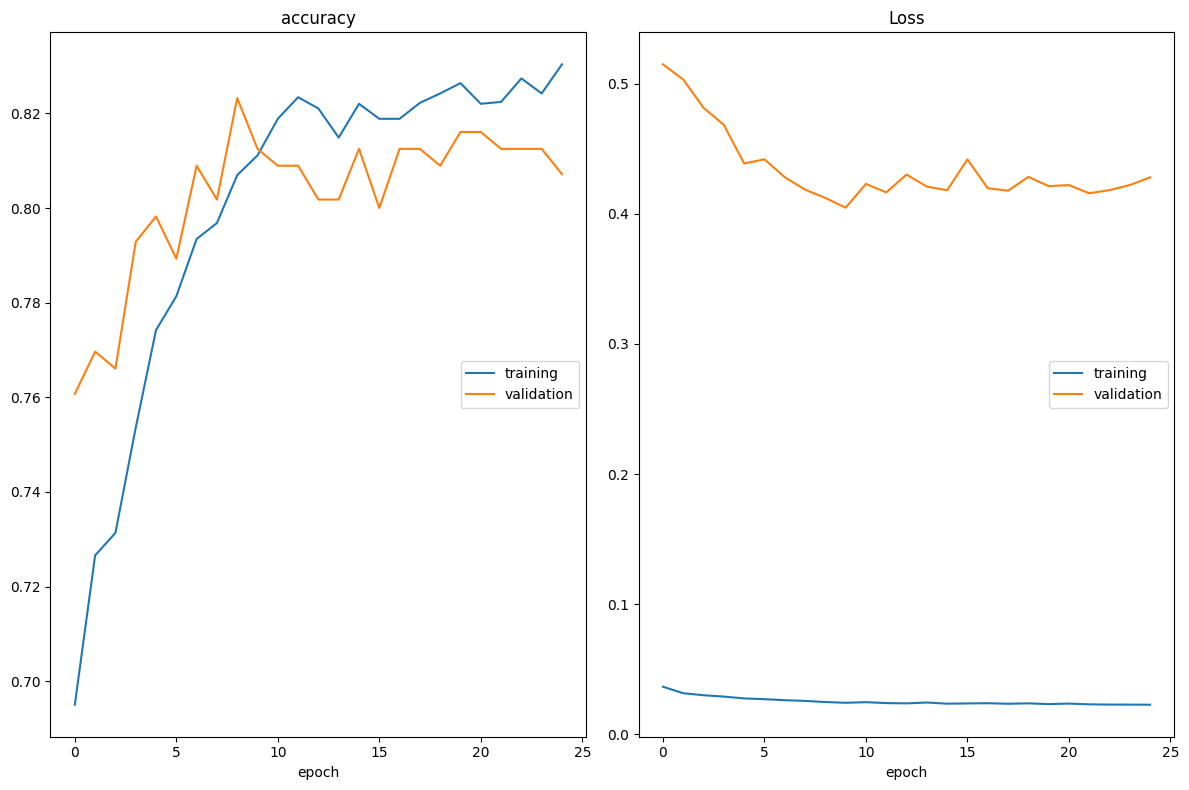

accuracy
	training         	 (min:    0.695, max:    0.830, cur:    0.830)
	validation       	 (min:    0.761, max:    0.823, cur:    0.807)
Loss
	training         	 (min:    0.023, max:    0.037, cur:    0.023)
	validation       	 (min:    0.405, max:    0.515, cur:    0.428)
Restoring model weights from the end of the best epoch: 10.
158/158 [==============================] - 2s 11ms/step - loss: 0.0228 - accuracy: 0.8304 - val_loss: 0.4280 - val_accuracy: 0.8071
Epoch 25: early stopping


In [154]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping


# In each minibatch during the training, 0.2 of the nuerons will set to be = 0, it helps to redcue the overfitting potential 
tf.random.set_seed(42)
model_Optuna = Sequential(
    [
        Input(shape= X_train_under.shape[1]),  # Number of unputs [feature]
        Dense(n_units1, activation="relu"),
        Dropout(DO_rate1),
        Dense(n_units2, activation="relu"),
        Dropout(DO_rate2),
        Dense(n_units3, activation="relu"),
        Dropout(DO_rate3),
        Dense(units=1, activation='sigmoid'),  #  1 neuron and Sigmoid because it is a bianry classification problem
    ]
)

# # neg = y.value_counts()[0]
# # pos = y.value_counts()[1]
# # total = neg + pos

# # # Scaling by total/2 helps keep the loss to a similar magnitude.
# # # The sum of the weights of all examples stays the same.
# # weight_for_0 = (1 / neg) * (total / 2.0)
# # weight_for_1 = (1 / pos) * (total / 2.0)

# # class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))


# Complie
model_Optuna.compile(optimizer=optimizer(learning_rate=learning_rate),
                     loss='binary_crossentropy',
                     metrics='accuracy')

#  live training loss plot 
from livelossplot import PlotLossesKeras

# Stop training when a monitored metric has stopped improving.
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True
)



# We are readt to fit the data
model_Optuna.fit(
    x=X_train_under, y=y_train_under, validation_split=0.1, batch_size=32, epochs=1000, verbose=1,  # 1000 epoch since there is early stopping
    class_weight={0: w0, 1: w1},    
    callbacks=[PlotLossesKeras(), early_stop]  # We add the erarly stop
    
)

# Since this is without early stopping, we will just use 500 epoch

### Evaluate The Model

- Plot the model history to observe the changing of metrics
- Make prediction to see "confusion matrix" and "classification report"
- Check ROC (Receiver Operating Curve) and AUC (Area Under Curve) for the model

In [155]:
eval_metric(model_Optuna, X_train_under, y_train_under, X_test_under, y_test_under)

75/75 [==============================] - 0s 1ms/step
Test_Set
[[1673  116]
 [ 270  341]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1789
           1       0.75      0.56      0.64       611

    accuracy                           0.84      2400
   macro avg       0.80      0.75      0.77      2400
weighted avg       0.83      0.84      0.83      2400


Train_Set
[[3899  275]
 [ 605  821]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4174
           1       0.75      0.58      0.65      1426

    accuracy                           0.84      5600
   macro avg       0.81      0.75      0.77      5600
weighted avg       0.84      0.84      0.84      5600



94/94 [==============================] - 0s 3ms/step


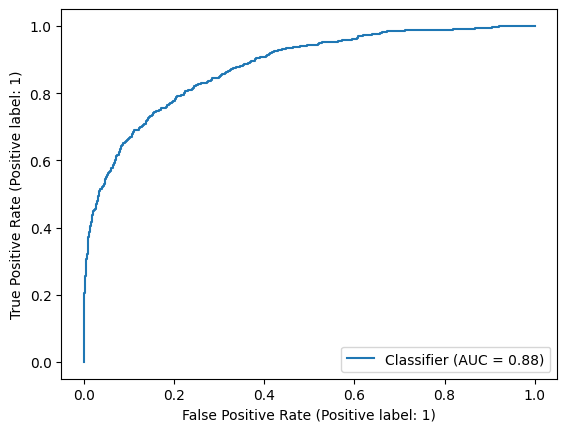

In [156]:
# ROC curve as the question satted, even though it is clearly imbalanced which means Precsion Vs Recall curve is better
y_pred_proba = model_Optuna.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

---------------------

## Optuna with Recall

In [93]:
from keras.metrics import Recall
#trial_metric =  Recall(class_id=1)
trial_metric =  "Recall"
batch_size = 32

def create_model(trial):
    #trial_metric =  Recall(class_id=1)
    trial_metric =  "Recall"


    
    # Some hyperparameters we want to optimize
    first_hidden_layer = trial.suggest_int("input_layer_units", 8, 420)
    first_hidden_layer_dropout = trial.suggest_float("input_layer_dropout", 0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1.3e-1)
    
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(first_hidden_layer, input_dim=X_train.shape[1], activation="relu"))
    
    # you can add the hidden layers automatically, see the example below:
    hidden_layers = trial.suggest_int("hidden_layers", 2, 6)
    for i in range(hidden_layers):
      hidden_layer_units = "hidden_layer_units_" + str(i)
      hidden_layer_units = trial.suggest_int(hidden_layer_units, 4, 128, log=True)
      dropout= "dropout_" + str(i)
      dropout = trial.suggest_float(dropout, 0, 0.5)
      
      model.add(Dense(hidden_layer_units, activation="relu"))
      model.add(Dropout(dropout))
    
    # we decided to use one neuron with sigmoid func in the output layer
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
      loss="binary_crossentropy",
      optimizer=Adam(learning_rate=learning_rate),
      metrics=[trial_metric],
    )
    return model



def objective(trial):
    early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True
)
    batch_size = 32
    model = create_model(trial)
    w0 = trial.suggest_loguniform("w0", 0.01, 5)
    w1 = trial.suggest_loguniform("w1", 0.01, 5)
    model.fit(
        X_train,
        y_train,
        validation_split=0.1,
        batch_size=batch_size,
        epochs=100,
        callbacks=[early_stop],
        class_weight={0: w0, 1: w1},
        verbose=0)
    
    
    score = model.evaluate(X_test, y_test, verbose=0)[1]
    return score

In [94]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
study.best_params

[I 2023-10-30 03:39:23,568] A new study created in memory with name: no-name-868ebb7f-b006-4b0c-a590-69a82cd4bb50


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 03:40:14,493] Trial 0 finished with value: 0.5875613689422607 and parameters: {'input_layer_units': 369, 'input_layer_dropout': 0.3170073739743809, 'learning_rate': 0.004565377247037819, 'hidden_layers': 4, 'hidden_layer_units_0': 10, 'dropout_0': 0.3639549837921492, 'hidden_layer_units_1': 22, 'dropout_1': 0.27787790655307565, 'hidden_layer_units_2': 58, 'dropout_2': 0.3135823613933592, 'hidden_layer_units_3': 9, 'dropout_3': 0.3913290387972503, 'w0': 1.1207433936457623, 'w1': 1.7256203458518515}. Best is trial 0 with value: 0.5875613689422607.


Restoring model weights from the end of the best epoch: 9.
Epoch 24: early stopping


[I 2023-10-30 03:40:35,663] Trial 1 finished with value: 0.551554799079895 and parameters: {'input_layer_units': 351, 'input_layer_dropout': 0.055707457729326615, 'learning_rate': 0.0032950717380058375, 'hidden_layers': 2, 'hidden_layer_units_0': 91, 'dropout_0': 0.12484562875378413, 'hidden_layer_units_1': 29, 'dropout_1': 0.3278186579321146, 'w0': 0.021585258188893473, 'w1': 0.03714078930934989}. Best is trial 0 with value: 0.5875613689422607.


Restoring model weights from the end of the best epoch: 39.
Epoch 54: early stopping


[I 2023-10-30 03:41:30,053] Trial 2 finished with value: 0.6137479543685913 and parameters: {'input_layer_units': 224, 'input_layer_dropout': 0.26529384386436317, 'learning_rate': 0.0009452090926667086, 'hidden_layers': 3, 'hidden_layer_units_0': 13, 'dropout_0': 0.4275423720846579, 'hidden_layer_units_1': 43, 'dropout_1': 0.39134694559417943, 'hidden_layer_units_2': 79, 'dropout_2': 0.1763069720448514, 'w0': 0.031105384878569786, 'w1': 0.12290133041728399}. Best is trial 2 with value: 0.6137479543685913.


Restoring model weights from the end of the best epoch: 19.
Epoch 34: early stopping


[I 2023-10-30 03:42:13,100] Trial 3 finished with value: 0.0 and parameters: {'input_layer_units': 35, 'input_layer_dropout': 0.053085002941579085, 'learning_rate': 0.007976028409154214, 'hidden_layers': 6, 'hidden_layer_units_0': 71, 'dropout_0': 0.13633505179788652, 'hidden_layer_units_1': 25, 'dropout_1': 0.4128359522145728, 'hidden_layer_units_2': 95, 'dropout_2': 0.3291369535592462, 'hidden_layer_units_3': 47, 'dropout_3': 0.06818980401120445, 'hidden_layer_units_4': 6, 'dropout_4': 0.4066664197487854, 'hidden_layer_units_5': 12, 'dropout_5': 0.4831809323044526, 'w0': 0.10250097122870595, 'w1': 0.1355440061980438}. Best is trial 2 with value: 0.6137479543685913.
[I 2023-10-30 03:43:55,323] Trial 4 finished with value: 0.7905073761940002 and parameters: {'input_layer_units': 125, 'input_layer_dropout': 0.44519403268609736, 'learning_rate': 1.9361649938803616e-05, 'hidden_layers': 3, 'hidden_layer_units_0': 104, 'dropout_0': 0.08870890905166856, 'hidden_layer_units_1': 94, 'dropout_

Restoring model weights from the end of the best epoch: 6.
Epoch 21: early stopping


[I 2023-10-30 03:44:21,503] Trial 5 finished with value: 0.18821604549884796 and parameters: {'input_layer_units': 62, 'input_layer_dropout': 0.2552951537563807, 'learning_rate': 0.004243736401951184, 'hidden_layers': 6, 'hidden_layer_units_0': 76, 'dropout_0': 0.21338416238076824, 'hidden_layer_units_1': 13, 'dropout_1': 0.19789137147888536, 'hidden_layer_units_2': 5, 'dropout_2': 0.17669823723902844, 'hidden_layer_units_3': 17, 'dropout_3': 0.34571082877010445, 'hidden_layer_units_4': 5, 'dropout_4': 0.4536921470723102, 'hidden_layer_units_5': 12, 'dropout_5': 0.01726293801211848, 'w0': 0.17586609477839638, 'w1': 0.1287345258230709}. Best is trial 4 with value: 0.7905073761940002.


Restoring model weights from the end of the best epoch: 21.
Epoch 36: early stopping


[I 2023-10-30 03:44:59,197] Trial 6 finished with value: 0.0 and parameters: {'input_layer_units': 219, 'input_layer_dropout': 0.47737364569409185, 'learning_rate': 0.10910206349729878, 'hidden_layers': 3, 'hidden_layer_units_0': 64, 'dropout_0': 0.2712769849601178, 'hidden_layer_units_1': 13, 'dropout_1': 0.13875496745271648, 'hidden_layer_units_2': 26, 'dropout_2': 0.38478902290491546, 'w0': 0.9251572751073369, 'w1': 0.9204019651950288}. Best is trial 4 with value: 0.7905073761940002.


Restoring model weights from the end of the best epoch: 4.
Epoch 19: early stopping


[I 2023-10-30 03:45:24,526] Trial 7 finished with value: 0.0 and parameters: {'input_layer_units': 122, 'input_layer_dropout': 0.35136018811593234, 'learning_rate': 0.007819849615673875, 'hidden_layers': 6, 'hidden_layer_units_0': 19, 'dropout_0': 0.4820528558707491, 'hidden_layer_units_1': 67, 'dropout_1': 0.47926097865738027, 'hidden_layer_units_2': 82, 'dropout_2': 0.0213247572717033, 'hidden_layer_units_3': 31, 'dropout_3': 0.4230722355632094, 'hidden_layer_units_4': 47, 'dropout_4': 0.2495997963777722, 'hidden_layer_units_5': 43, 'dropout_5': 0.34303351788628106, 'w0': 4.6880300623376225, 'w1': 1.3487901088884202}. Best is trial 4 with value: 0.7905073761940002.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 03:45:46,750] Trial 8 finished with value: 1.0 and parameters: {'input_layer_units': 88, 'input_layer_dropout': 0.476133877480747, 'learning_rate': 0.012977766346869944, 'hidden_layers': 6, 'hidden_layer_units_0': 26, 'dropout_0': 0.16692692913973334, 'hidden_layer_units_1': 9, 'dropout_1': 0.03272966681121625, 'hidden_layer_units_2': 73, 'dropout_2': 0.4889416546442969, 'hidden_layer_units_3': 104, 'dropout_3': 0.1938271212411986, 'hidden_layer_units_4': 31, 'dropout_4': 0.14982043484827962, 'hidden_layer_units_5': 33, 'dropout_5': 0.2360003264439403, 'w0': 0.01866890188879633, 'w1': 1.2302815426378888}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 28.
Epoch 43: early stopping


[I 2023-10-30 03:46:40,725] Trial 9 finished with value: 0.0 and parameters: {'input_layer_units': 91, 'input_layer_dropout': 0.408066880769684, 'learning_rate': 1.5117127957536613e-05, 'hidden_layers': 6, 'hidden_layer_units_0': 6, 'dropout_0': 0.44951647674447326, 'hidden_layer_units_1': 10, 'dropout_1': 0.22355538577443929, 'hidden_layer_units_2': 8, 'dropout_2': 0.17651248716748036, 'hidden_layer_units_3': 15, 'dropout_3': 0.2774730771973069, 'hidden_layer_units_4': 22, 'dropout_4': 0.3717415069316625, 'hidden_layer_units_5': 10, 'dropout_5': 0.4568770729600187, 'w0': 0.893607365855248, 'w1': 0.025781887769162855}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 5.
Epoch 20: early stopping


[I 2023-10-30 03:47:04,590] Trial 10 finished with value: 1.0 and parameters: {'input_layer_units': 269, 'input_layer_dropout': 0.4881686123316486, 'learning_rate': 0.12475118125451834, 'hidden_layers': 5, 'hidden_layer_units_0': 36, 'dropout_0': 9.253949280330076e-05, 'hidden_layer_units_1': 4, 'dropout_1': 0.01719039254199769, 'hidden_layer_units_2': 45, 'dropout_2': 0.4922183144840552, 'hidden_layer_units_3': 125, 'dropout_3': 0.14802127949173427, 'hidden_layer_units_4': 126, 'dropout_4': 0.05801971073642753, 'w0': 0.010413539157760174, 'w1': 4.4197284549474105}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 8.
Epoch 23: early stopping


[I 2023-10-30 03:47:32,755] Trial 11 finished with value: 1.0 and parameters: {'input_layer_units': 270, 'input_layer_dropout': 0.4846466481799893, 'learning_rate': 0.12989854873887335, 'hidden_layers': 5, 'hidden_layer_units_0': 33, 'dropout_0': 0.0027873914607802934, 'hidden_layer_units_1': 4, 'dropout_1': 0.016332050299781353, 'hidden_layer_units_2': 42, 'dropout_2': 0.4968006981129063, 'hidden_layer_units_3': 123, 'dropout_3': 0.14865310877676502, 'hidden_layer_units_4': 103, 'dropout_4': 0.04915231303674106, 'w0': 0.012867431340342456, 'w1': 4.855770146453768}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 5.
Epoch 20: early stopping


[I 2023-10-30 03:47:57,535] Trial 12 finished with value: 1.0 and parameters: {'input_layer_units': 295, 'input_layer_dropout': 0.49446419256760155, 'learning_rate': 0.0426294560619582, 'hidden_layers': 5, 'hidden_layer_units_0': 31, 'dropout_0': 0.019331141361082466, 'hidden_layer_units_1': 4, 'dropout_1': 0.019090023379392432, 'hidden_layer_units_2': 115, 'dropout_2': 0.4736576032374855, 'hidden_layer_units_3': 112, 'dropout_3': 0.16808849860797911, 'hidden_layer_units_4': 124, 'dropout_4': 0.0709998208363864, 'w0': 0.011149217814864467, 'w1': 3.324675995063172}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 03:48:19,696] Trial 13 finished with value: 1.0 and parameters: {'input_layer_units': 150, 'input_layer_dropout': 0.3868869154989603, 'learning_rate': 0.03130029393181349, 'hidden_layers': 5, 'hidden_layer_units_0': 44, 'dropout_0': 0.20433032052492, 'hidden_layer_units_1': 7, 'dropout_1': 0.07818710281946523, 'hidden_layer_units_2': 50, 'dropout_2': 0.4359219263873385, 'hidden_layer_units_3': 64, 'dropout_3': 0.00573996534694543, 'hidden_layer_units_4': 42, 'dropout_4': 0.1412244099523972, 'w0': 0.04750138861537723, 'w1': 4.472086069646465}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 03:48:41,780] Trial 14 finished with value: 1.0 and parameters: {'input_layer_units': 165, 'input_layer_dropout': 0.41359176748537896, 'learning_rate': 0.02826604905080128, 'hidden_layers': 5, 'hidden_layer_units_0': 19, 'dropout_0': 0.07009857133585722, 'hidden_layer_units_1': 6, 'dropout_1': 0.10639854151857281, 'hidden_layer_units_2': 41, 'dropout_2': 0.41769418572863354, 'hidden_layer_units_3': 67, 'dropout_3': 0.22255280574995015, 'hidden_layer_units_4': 15, 'dropout_4': 0.15676024876236347, 'w0': 0.010066643187892643, 'w1': 0.5303457819183102}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 03:49:09,045] Trial 15 finished with value: 1.0 and parameters: {'input_layer_units': 298, 'input_layer_dropout': 0.35743328304046307, 'learning_rate': 0.12651482445551449, 'hidden_layers': 4, 'hidden_layer_units_0': 34, 'dropout_0': 0.15862705790965323, 'hidden_layer_units_1': 7, 'dropout_1': 0.007921664294190774, 'hidden_layer_units_2': 14, 'dropout_2': 0.4995719531999437, 'hidden_layer_units_3': 4, 'dropout_3': 0.128178917363552, 'w0': 0.04257100404781037, 'w1': 1.9955275970724842}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 03:49:31,124] Trial 16 finished with value: 1.0 and parameters: {'input_layer_units': 405, 'input_layer_dropout': 0.4996118335784836, 'learning_rate': 0.02131432782989377, 'hidden_layers': 5, 'hidden_layer_units_0': 48, 'dropout_0': 0.06435551574382925, 'hidden_layer_units_1': 4, 'dropout_1': 0.14461061425907912, 'hidden_layer_units_2': 128, 'dropout_2': 0.3768088790214629, 'hidden_layer_units_3': 116, 'dropout_3': 0.2511171792749499, 'hidden_layer_units_4': 66, 'dropout_4': 0.03061532599154204, 'w0': 0.02408864229911117, 'w1': 2.3707939281394457}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 03:50:27,342] Trial 17 finished with value: 0.88707035779953 and parameters: {'input_layer_units': 183, 'input_layer_dropout': 0.4207846116723482, 'learning_rate': 0.0007492447821534851, 'hidden_layers': 6, 'hidden_layer_units_0': 128, 'dropout_0': 0.286250537550477, 'hidden_layer_units_1': 15, 'dropout_1': 0.0696454661550602, 'hidden_layer_units_2': 63, 'dropout_2': 0.4251547799531173, 'hidden_layer_units_3': 41, 'dropout_3': 0.2060528593985511, 'hidden_layer_units_4': 28, 'dropout_4': 0.15375011880622041, 'hidden_layer_units_5': 114, 'dropout_5': 0.19533327596666628, 'w0': 0.05231484849221418, 'w1': 0.9240804943969062}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 03:50:51,747] Trial 18 finished with value: 1.0 and parameters: {'input_layer_units': 240, 'input_layer_dropout': 0.4458221556229694, 'learning_rate': 0.050265490262918565, 'hidden_layers': 4, 'hidden_layer_units_0': 26, 'dropout_0': 0.039478974685373314, 'hidden_layer_units_1': 9, 'dropout_1': 0.15854416839020422, 'hidden_layer_units_2': 34, 'dropout_2': 0.4587172767620586, 'hidden_layer_units_3': 81, 'dropout_3': 0.49858342602651234, 'w0': 0.019424179012048435, 'w1': 2.6961256807189544}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 03:51:13,558] Trial 19 finished with value: 0.707037627696991 and parameters: {'input_layer_units': 20, 'input_layer_dropout': 0.1898552879107803, 'learning_rate': 0.01718738045495357, 'hidden_layers': 5, 'hidden_layer_units_0': 46, 'dropout_0': 0.10176663910997293, 'hidden_layer_units_1': 6, 'dropout_1': 0.0629895459824984, 'hidden_layer_units_2': 17, 'dropout_2': 0.3369782644877351, 'hidden_layer_units_3': 79, 'dropout_3': 0.09368590907544855, 'hidden_layer_units_4': 74, 'dropout_4': 0.002547816142970352, 'w0': 0.07044849395663555, 'w1': 0.3819114045647096}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 03:51:41,949] Trial 20 finished with value: 1.0 and parameters: {'input_layer_units': 330, 'input_layer_dropout': 0.30871050264631383, 'learning_rate': 0.05024390822930743, 'hidden_layers': 6, 'hidden_layer_units_0': 4, 'dropout_0': 0.18514037281580925, 'hidden_layer_units_1': 5, 'dropout_1': 0.1784021443833582, 'hidden_layer_units_2': 65, 'dropout_2': 0.27691444001310916, 'hidden_layer_units_3': 27, 'dropout_3': 0.18084102277670694, 'hidden_layer_units_4': 13, 'dropout_4': 0.22973266250348834, 'hidden_layer_units_5': 4, 'dropout_5': 0.2002775070111468, 'w0': 0.01724600224232599, 'w1': 1.2587569656834081}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 03:52:04,545] Trial 21 finished with value: 1.0 and parameters: {'input_layer_units': 267, 'input_layer_dropout': 0.45653003969405526, 'learning_rate': 0.08404364659680953, 'hidden_layers': 5, 'hidden_layer_units_0': 24, 'dropout_0': 0.0020898239986455983, 'hidden_layer_units_1': 4, 'dropout_1': 0.006850050100948246, 'hidden_layer_units_2': 42, 'dropout_2': 0.4960985672916029, 'hidden_layer_units_3': 124, 'dropout_3': 0.11957854098530526, 'hidden_layer_units_4': 106, 'dropout_4': 0.08182541903694227, 'w0': 0.010287381051659461, 'w1': 4.974372161759433}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 03:52:34,685] Trial 22 finished with value: 1.0 and parameters: {'input_layer_units': 270, 'input_layer_dropout': 0.4965179217527591, 'learning_rate': 0.11433263974310251, 'hidden_layers': 5, 'hidden_layer_units_0': 31, 'dropout_0': 0.012851391835468653, 'hidden_layer_units_1': 5, 'dropout_1': 0.044622465726437216, 'hidden_layer_units_2': 37, 'dropout_2': 0.46520392262528537, 'hidden_layer_units_3': 115, 'dropout_3': 0.1656424468832013, 'hidden_layer_units_4': 127, 'dropout_4': 0.07621012458278519, 'w0': 0.03031589052770698, 'w1': 3.3719912471499063}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 8.
Epoch 23: early stopping


[I 2023-10-30 03:53:01,087] Trial 23 finished with value: 1.0 and parameters: {'input_layer_units': 196, 'input_layer_dropout': 0.44522819420463244, 'learning_rate': 0.01507262851986601, 'hidden_layers': 4, 'hidden_layer_units_0': 16, 'dropout_0': 0.052147460973754806, 'hidden_layer_units_1': 9, 'dropout_1': 0.11208999675928938, 'hidden_layer_units_2': 53, 'dropout_2': 0.49560219148184864, 'hidden_layer_units_3': 83, 'dropout_3': 0.2543606848173391, 'w0': 0.016084816240376054, 'w1': 3.9479644405843866}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 03:53:23,378] Trial 24 finished with value: 1.0 and parameters: {'input_layer_units': 269, 'input_layer_dropout': 0.3867751826688377, 'learning_rate': 0.06938194147809519, 'hidden_layers': 5, 'hidden_layer_units_0': 39, 'dropout_0': 0.0006052457027956876, 'hidden_layer_units_1': 4, 'dropout_1': 0.03477352153068983, 'hidden_layer_units_2': 82, 'dropout_2': 0.4090608169622724, 'hidden_layer_units_3': 52, 'dropout_3': 0.12975482895897883, 'hidden_layer_units_4': 81, 'dropout_4': 0.005926566186166847, 'w0': 0.015763400708094982, 'w1': 2.2793598487438778}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 03:53:51,526] Trial 25 finished with value: 1.0 and parameters: {'input_layer_units': 314, 'input_layer_dropout': 0.4636758800006821, 'learning_rate': 0.04945046778135257, 'hidden_layers': 6, 'hidden_layer_units_0': 25, 'dropout_0': 0.10864175250390283, 'hidden_layer_units_1': 5, 'dropout_1': 0.004764041145482199, 'hidden_layer_units_2': 34, 'dropout_2': 0.39333900657506804, 'hidden_layer_units_3': 90, 'dropout_3': 0.06639014617506794, 'hidden_layer_units_4': 50, 'dropout_4': 0.11330010222169001, 'hidden_layer_units_5': 36, 'dropout_5': 0.29360665556188603, 'w0': 0.03202116618131038, 'w1': 4.936676027434999}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 03:54:13,040] Trial 26 finished with value: 1.0 and parameters: {'input_layer_units': 244, 'input_layer_dropout': 0.4995191230368094, 'learning_rate': 0.11276730024610294, 'hidden_layers': 5, 'hidden_layer_units_0': 54, 'dropout_0': 0.05195179486260709, 'hidden_layer_units_1': 7, 'dropout_1': 0.09455956973159149, 'hidden_layer_units_2': 49, 'dropout_2': 0.45652779170194757, 'hidden_layer_units_3': 58, 'dropout_3': 0.196004051633995, 'hidden_layer_units_4': 92, 'dropout_4': 0.18691601034590355, 'w0': 0.010217032762034624, 'w1': 2.5317681363211477}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 03:54:33,416] Trial 27 finished with value: 1.0 and parameters: {'input_layer_units': 199, 'input_layer_dropout': 0.43381002626498816, 'learning_rate': 0.024109132687024182, 'hidden_layers': 6, 'hidden_layer_units_0': 35, 'dropout_0': 0.15662620535702546, 'hidden_layer_units_1': 16, 'dropout_1': 0.05508477622565186, 'hidden_layer_units_2': 67, 'dropout_2': 0.4478070530897424, 'hidden_layer_units_3': 127, 'dropout_3': 0.28670318611329226, 'hidden_layer_units_4': 64, 'dropout_4': 0.046316534392751824, 'hidden_layer_units_5': 120, 'dropout_5': 0.08303919033122395, 'w0': 0.022393423223057412, 'w1': 1.6486622596441065}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 03:54:54,129] Trial 28 finished with value: 1.0 and parameters: {'input_layer_units': 76, 'input_layer_dropout': 0.4664612004592437, 'learning_rate': 0.05844367232911937, 'hidden_layers': 4, 'hidden_layer_units_0': 59, 'dropout_0': 0.08568607937734646, 'hidden_layer_units_1': 10, 'dropout_1': 0.11517708758087025, 'hidden_layer_units_2': 29, 'dropout_2': 0.36815754243979554, 'hidden_layer_units_3': 90, 'dropout_3': 0.1559424658552092, 'w0': 0.015780363732780755, 'w1': 2.9378607545906914}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 03:55:15,303] Trial 29 finished with value: 1.0 and parameters: {'input_layer_units': 343, 'input_layer_dropout': 0.3806459352494971, 'learning_rate': 0.012310734984893195, 'hidden_layers': 5, 'hidden_layer_units_0': 11, 'dropout_0': 0.03519196590932516, 'hidden_layer_units_1': 5, 'dropout_1': 0.04409075768443956, 'hidden_layer_units_2': 19, 'dropout_2': 0.4301623991498926, 'hidden_layer_units_3': 64, 'dropout_3': 0.2255271743211678, 'hidden_layer_units_4': 95, 'dropout_4': 0.09875418771847287, 'w0': 0.03900893253573158, 'w1': 1.6142399591263774}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 03:55:32,593] Trial 30 finished with value: 1.0 and parameters: {'input_layer_units': 412, 'input_layer_dropout': 0.4112935523013457, 'learning_rate': 0.03227459561290245, 'hidden_layers': 2, 'hidden_layer_units_0': 16, 'dropout_0': 0.07953800897808405, 'hidden_layer_units_1': 8, 'dropout_1': 0.2518043695281451, 'w0': 0.0775124933277792, 'w1': 1.2911066334776844}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 5.
Epoch 20: early stopping


[I 2023-10-30 03:55:56,485] Trial 31 finished with value: 1.0 and parameters: {'input_layer_units': 298, 'input_layer_dropout': 0.4743727204315181, 'learning_rate': 0.05129662202076794, 'hidden_layers': 5, 'hidden_layer_units_0': 30, 'dropout_0': 0.02735959183942262, 'hidden_layer_units_1': 4, 'dropout_1': 0.007953762996554, 'hidden_layer_units_2': 119, 'dropout_2': 0.4747464566344333, 'hidden_layer_units_3': 99, 'dropout_3': 0.1621419931598674, 'hidden_layer_units_4': 104, 'dropout_4': 0.06779069588747774, 'w0': 0.013092366852524562, 'w1': 3.2594355470839163}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 03:56:20,764] Trial 32 finished with value: 1.0 and parameters: {'input_layer_units': 374, 'input_layer_dropout': 0.499931887768832, 'learning_rate': 0.12347697534891619, 'hidden_layers': 4, 'hidden_layer_units_0': 37, 'dropout_0': 0.003646248048035433, 'hidden_layer_units_1': 4, 'dropout_1': 0.03842902395633302, 'hidden_layer_units_2': 102, 'dropout_2': 0.48067721580499523, 'hidden_layer_units_3': 122, 'dropout_3': 0.18349417710709484, 'w0': 0.024125380628802172, 'w1': 3.4926025025123755}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 03:56:43,324] Trial 33 finished with value: 1.0 and parameters: {'input_layer_units': 374, 'input_layer_dropout': 0.4640259101961265, 'learning_rate': 0.031283490576452855, 'hidden_layers': 5, 'hidden_layer_units_0': 27, 'dropout_0': 0.12672362537647341, 'hidden_layer_units_1': 6, 'dropout_1': 0.08141209313344194, 'hidden_layer_units_2': 59, 'dropout_2': 0.497406407557176, 'hidden_layer_units_3': 95, 'dropout_3': 0.1399397646825116, 'hidden_layer_units_4': 127, 'dropout_4': 0.03944469208596492, 'w0': 0.012565212174802127, 'w1': 2.065157319256007}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 03:57:07,846] Trial 34 finished with value: 1.0 and parameters: {'input_layer_units': 287, 'input_layer_dropout': 0.4303662370888768, 'learning_rate': 0.07335151438097949, 'hidden_layers': 6, 'hidden_layer_units_0': 22, 'dropout_0': 0.03495523699666444, 'hidden_layer_units_1': 5, 'dropout_1': 0.03616066532353396, 'hidden_layer_units_2': 102, 'dropout_2': 0.4510931061509247, 'hidden_layer_units_3': 74, 'dropout_3': 0.20806594138852547, 'hidden_layer_units_4': 121, 'dropout_4': 0.09976749381172745, 'hidden_layer_units_5': 35, 'dropout_5': 0.14303574178809028, 'w0': 0.02606843888533153, 'w1': 4.850551687008206}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 18.
Epoch 33: early stopping


[I 2023-10-30 03:57:41,965] Trial 35 finished with value: 1.0 and parameters: {'input_layer_units': 251, 'input_layer_dropout': 0.464068229716045, 'learning_rate': 0.008363533802616544, 'hidden_layers': 3, 'hidden_layer_units_0': 41, 'dropout_0': 0.11421736855895111, 'hidden_layer_units_1': 4, 'dropout_1': 0.08706520146545157, 'hidden_layer_units_2': 67, 'dropout_2': 0.4081066917047134, 'w0': 0.01445416206049101, 'w1': 3.3135385584482293}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 29.
Epoch 44: early stopping


[I 2023-10-30 03:58:31,199] Trial 36 finished with value: 0.9492635130882263 and parameters: {'input_layer_units': 326, 'input_layer_dropout': 0.43321473248492687, 'learning_rate': 0.0021984557241570184, 'hidden_layers': 4, 'hidden_layer_units_0': 30, 'dropout_0': 0.0648891459242128, 'hidden_layer_units_1': 8, 'dropout_1': 0.0031839620885254633, 'hidden_layer_units_2': 83, 'dropout_2': 0.4645137536851559, 'hidden_layer_units_3': 128, 'dropout_3': 0.09939804515821049, 'w0': 0.02208205715605843, 'w1': 2.146695599676563}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 13.
Epoch 28: early stopping


[I 2023-10-30 03:59:08,768] Trial 37 finished with value: 0.0 and parameters: {'input_layer_units': 226, 'input_layer_dropout': 0.4819046829796654, 'learning_rate': 0.043135652458815586, 'hidden_layers': 6, 'hidden_layer_units_0': 52, 'dropout_0': 0.09135845078716759, 'hidden_layer_units_1': 22, 'dropout_1': 0.13098792068491685, 'hidden_layer_units_2': 98, 'dropout_2': 0.43509807573208364, 'hidden_layer_units_3': 94, 'dropout_3': 0.16899332243039125, 'hidden_layer_units_4': 79, 'dropout_4': 0.05188577139618434, 'hidden_layer_units_5': 61, 'dropout_5': 0.33741569011436423, 'w0': 0.0101558521570007, 'w1': 0.010037085400946295}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 03:59:38,175] Trial 38 finished with value: 1.0 and parameters: {'input_layer_units': 352, 'input_layer_dropout': 0.3171160059793262, 'learning_rate': 0.07529369756708094, 'hidden_layers': 5, 'hidden_layer_units_0': 21, 'dropout_0': 0.021949475546602062, 'hidden_layer_units_1': 6, 'dropout_1': 0.0686793310549774, 'hidden_layer_units_2': 46, 'dropout_2': 0.34077770167273325, 'hidden_layer_units_3': 45, 'dropout_3': 0.15068362116808054, 'hidden_layer_units_4': 60, 'dropout_4': 0.11823794485574202, 'w0': 0.028919740002790805, 'w1': 0.9425107625139012}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 03:59:54,081] Trial 39 finished with value: 1.0 and parameters: {'input_layer_units': 114, 'input_layer_dropout': 0.47779675105079655, 'learning_rate': 0.011701421559873538, 'hidden_layers': 2, 'hidden_layer_units_0': 71, 'dropout_0': 0.04126428619041234, 'hidden_layer_units_1': 12, 'dropout_1': 0.2862180210052389, 'w0': 0.0186381561797323, 'w1': 3.394542709465315}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 04:00:16,338] Trial 40 finished with value: 1.0 and parameters: {'input_layer_units': 52, 'input_layer_dropout': 0.444660119908888, 'learning_rate': 0.021104720801455295, 'hidden_layers': 6, 'hidden_layer_units_0': 87, 'dropout_0': 0.13975711906772098, 'hidden_layer_units_1': 36, 'dropout_1': 0.03499261867886647, 'hidden_layer_units_2': 73, 'dropout_2': 0.3656276695176368, 'hidden_layer_units_3': 69, 'dropout_3': 0.2301649366754696, 'hidden_layer_units_4': 39, 'dropout_4': 0.07321190196608103, 'hidden_layer_units_5': 20, 'dropout_5': 0.2572242842339216, 'w0': 0.03310888973601514, 'w1': 1.7358113919670435}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 04:00:37,242] Trial 41 finished with value: 1.0 and parameters: {'input_layer_units': 163, 'input_layer_dropout': 0.3956114935563174, 'learning_rate': 0.03762897383958262, 'hidden_layers': 5, 'hidden_layer_units_0': 39, 'dropout_0': 0.21545074846328136, 'hidden_layer_units_1': 7, 'dropout_1': 0.08270756900235782, 'hidden_layer_units_2': 51, 'dropout_2': 0.43576278863668194, 'hidden_layer_units_3': 100, 'dropout_3': 0.021428426833930408, 'hidden_layer_units_4': 40, 'dropout_4': 0.1318129910493445, 'w0': 0.04573205881700975, 'w1': 4.403789388582405}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 04:00:59,056] Trial 42 finished with value: 1.0 and parameters: {'input_layer_units': 148, 'input_layer_dropout': 0.4177767819600641, 'learning_rate': 0.03223662069748129, 'hidden_layers': 5, 'hidden_layer_units_0': 46, 'dropout_0': 0.29717192001679754, 'hidden_layer_units_1': 5, 'dropout_1': 0.02407158258521118, 'hidden_layer_units_2': 54, 'dropout_2': 0.4704323786264322, 'hidden_layer_units_3': 60, 'dropout_3': 0.06003973593659839, 'hidden_layer_units_4': 91, 'dropout_4': 0.1656573017170454, 'w0': 0.012592463407962889, 'w1': 3.8700253315108974}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:01:21,331] Trial 43 finished with value: 1.0 and parameters: {'input_layer_units': 141, 'input_layer_dropout': 0.4779201233932146, 'learning_rate': 0.07513173797235945, 'hidden_layers': 5, 'hidden_layer_units_0': 32, 'dropout_0': 0.232798344606242, 'hidden_layer_units_1': 18, 'dropout_1': 0.06753484632691666, 'hidden_layer_units_2': 80, 'dropout_2': 0.49993383783582274, 'hidden_layer_units_3': 103, 'dropout_3': 0.022764272341769975, 'hidden_layer_units_4': 122, 'dropout_4': 0.13159767775229098, 'w0': 0.019494396281969483, 'w1': 2.6877318068765548}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 04:01:40,514] Trial 44 finished with value: 1.0 and parameters: {'input_layer_units': 106, 'input_layer_dropout': 0.4439967712009476, 'learning_rate': 0.023022585946205702, 'hidden_layers': 4, 'hidden_layer_units_0': 45, 'dropout_0': 0.1740253884666527, 'hidden_layer_units_1': 11, 'dropout_1': 0.024604463354745976, 'hidden_layer_units_2': 45, 'dropout_2': 0.40681888455217174, 'hidden_layer_units_3': 76, 'dropout_3': 0.08716823269877365, 'w0': 0.01376879749646436, 'w1': 4.988235162489453}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 25.
Epoch 40: early stopping


[I 2023-10-30 04:02:27,270] Trial 45 finished with value: 0.9050736427307129 and parameters: {'input_layer_units': 81, 'input_layer_dropout': 0.40425133026150606, 'learning_rate': 0.006778751440140118, 'hidden_layers': 5, 'hidden_layer_units_0': 56, 'dropout_0': 0.06655292582601056, 'hidden_layer_units_1': 13, 'dropout_1': 0.058137763901819565, 'hidden_layer_units_2': 60, 'dropout_2': 0.4406141489984934, 'hidden_layer_units_3': 108, 'dropout_3': 0.12098132449829194, 'hidden_layer_units_4': 32, 'dropout_4': 0.20635213218169118, 'w0': 0.17406403849286095, 'w1': 2.9340928298497437}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 04:02:59,574] Trial 46 finished with value: 1.0 and parameters: {'input_layer_units': 211, 'input_layer_dropout': 0.37906548388275063, 'learning_rate': 0.12390086855948779, 'hidden_layers': 6, 'hidden_layer_units_0': 65, 'dropout_0': 0.13133735352030823, 'hidden_layer_units_1': 8, 'dropout_1': 0.10282544831837243, 'hidden_layer_units_2': 40, 'dropout_2': 0.4729875950969235, 'hidden_layer_units_3': 55, 'dropout_3': 0.049975354770604274, 'hidden_layer_units_4': 57, 'dropout_4': 0.08680659074322394, 'hidden_layer_units_5': 67, 'dropout_5': 0.10253428646631632, 'w0': 0.039536995335172416, 'w1': 1.9401369898708105}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:03:19,148] Trial 47 finished with value: 1.0 and parameters: {'input_layer_units': 170, 'input_layer_dropout': 0.4992119169163888, 'learning_rate': 0.037356185027482114, 'hidden_layers': 3, 'hidden_layer_units_0': 29, 'dropout_0': 0.018826413324205156, 'hidden_layer_units_1': 6, 'dropout_1': 0.018030400453913603, 'hidden_layer_units_2': 29, 'dropout_2': 0.4310628885520896, 'w0': 0.06000483980814755, 'w1': 1.1394402612826895}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 04:03:46,608] Trial 48 finished with value: 1.0 and parameters: {'input_layer_units': 292, 'input_layer_dropout': 0.45230516096778295, 'learning_rate': 0.08049830684738175, 'hidden_layers': 5, 'hidden_layer_units_0': 42, 'dropout_0': 0.09469282591257806, 'hidden_layer_units_1': 25, 'dropout_1': 4.241045131313931e-06, 'hidden_layer_units_2': 127, 'dropout_2': 0.38531738302263924, 'hidden_layer_units_3': 71, 'dropout_3': 0.00812471693827993, 'hidden_layer_units_4': 75, 'dropout_4': 0.03045422193240602, 'w0': 0.020282592942991163, 'w1': 0.6265196650444229}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 04:04:16,450] Trial 49 finished with value: 1.0 and parameters: {'input_layer_units': 140, 'input_layer_dropout': 0.41688354950372974, 'learning_rate': 0.016135782979722985, 'hidden_layers': 6, 'hidden_layer_units_0': 34, 'dropout_0': 0.0525381055626645, 'hidden_layer_units_1': 4, 'dropout_1': 0.05317375559840494, 'hidden_layer_units_2': 88, 'dropout_2': 0.47372157126805803, 'hidden_layer_units_3': 103, 'dropout_3': 0.09047230570415687, 'hidden_layer_units_4': 86, 'dropout_4': 0.13173883012882345, 'hidden_layer_units_5': 22, 'dropout_5': 0.0012717629006144815, 'w0': 0.025858343007786992, 'w1': 2.3862060214623253}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 04:04:46,001] Trial 50 finished with value: 1.0 and parameters: {'input_layer_units': 226, 'input_layer_dropout': 0.4819395452895407, 'learning_rate': 0.0513159719360851, 'hidden_layers': 4, 'hidden_layer_units_0': 25, 'dropout_0': 0.18337929481289106, 'hidden_layer_units_1': 7, 'dropout_1': 0.12216240647755895, 'hidden_layer_units_2': 73, 'dropout_2': 0.41671930677086555, 'hidden_layer_units_3': 38, 'dropout_3': 0.19312426677322553, 'w0': 0.036026007494131575, 'w1': 1.5437655935352856}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:05:08,602] Trial 51 finished with value: 1.0 and parameters: {'input_layer_units': 177, 'input_layer_dropout': 0.4355573468556463, 'learning_rate': 0.02760595163378489, 'hidden_layers': 5, 'hidden_layer_units_0': 19, 'dropout_0': 0.020550813381050234, 'hidden_layer_units_1': 6, 'dropout_1': 0.09961631060191235, 'hidden_layer_units_2': 42, 'dropout_2': 0.45120443353642437, 'hidden_layer_units_3': 82, 'dropout_3': 0.14054784811814425, 'hidden_layer_units_4': 18, 'dropout_4': 0.17799081379272852, 'w0': 0.010097371411697602, 'w1': 0.6452870347771344}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 04:05:37,860] Trial 52 finished with value: 1.0 and parameters: {'input_layer_units': 98, 'input_layer_dropout': 0.4568940650154544, 'learning_rate': 0.08551056037266425, 'hidden_layers': 5, 'hidden_layer_units_0': 22, 'dropout_0': 0.0016098392498885283, 'hidden_layer_units_1': 5, 'dropout_1': 0.14725254110817837, 'hidden_layer_units_2': 51, 'dropout_2': 0.4841871945398661, 'hidden_layer_units_3': 62, 'dropout_3': 0.1119064575904639, 'hidden_layer_units_4': 12, 'dropout_4': 0.153679065739531, 'w0': 0.012614911196499497, 'w1': 0.31709323051962324}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 8.
Epoch 23: early stopping


[I 2023-10-30 04:06:04,738] Trial 53 finished with value: 1.0 and parameters: {'input_layer_units': 259, 'input_layer_dropout': 0.3639715733534182, 'learning_rate': 0.01998387785531334, 'hidden_layers': 5, 'hidden_layer_units_0': 27, 'dropout_0': 0.07159823983968946, 'hidden_layer_units_1': 4, 'dropout_1': 0.07557003582535547, 'hidden_layer_units_2': 37, 'dropout_2': 0.420965628756177, 'hidden_layer_units_3': 111, 'dropout_3': 0.207394954898779, 'hidden_layer_units_4': 48, 'dropout_4': 0.2010647434863983, 'w0': 0.017214812036862235, 'w1': 3.9405623867400448}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:06:24,931] Trial 54 finished with value: 1.0 and parameters: {'input_layer_units': 125, 'input_layer_dropout': 0.40669150910562085, 'learning_rate': 0.039083581149469165, 'hidden_layers': 4, 'hidden_layer_units_0': 36, 'dropout_0': 0.04945902249604057, 'hidden_layer_units_1': 9, 'dropout_1': 0.028313584971186176, 'hidden_layer_units_2': 57, 'dropout_2': 0.4514288448757233, 'hidden_layer_units_3': 83, 'dropout_3': 0.17568774115199137, 'w0': 0.010093692023511965, 'w1': 3.9564963547251666}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 04:06:57,532] Trial 55 finished with value: 1.0 and parameters: {'input_layer_units': 44, 'input_layer_dropout': 0.42584620120070654, 'learning_rate': 0.12998715649183146, 'hidden_layers': 6, 'hidden_layer_units_0': 48, 'dropout_0': 0.10664530447690004, 'hidden_layer_units_1': 6, 'dropout_1': 0.06124256776356578, 'hidden_layer_units_2': 46, 'dropout_2': 0.4805728427473754, 'hidden_layer_units_3': 49, 'dropout_3': 0.26936903897840475, 'hidden_layer_units_4': 102, 'dropout_4': 0.2910713378023084, 'hidden_layer_units_5': 6, 'dropout_5': 0.39933594031968134, 'w0': 0.01679529802317293, 'w1': 2.59808180573859}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 04:07:24,566] Trial 56 finished with value: 1.0 and parameters: {'input_layer_units': 198, 'input_layer_dropout': 0.486338347726174, 'learning_rate': 0.06084380692208171, 'hidden_layers': 5, 'hidden_layer_units_0': 33, 'dropout_0': 0.020389907743657114, 'hidden_layer_units_1': 5, 'dropout_1': 0.0466133531623605, 'hidden_layer_units_2': 25, 'dropout_2': 0.3983054381388589, 'hidden_layer_units_3': 72, 'dropout_3': 0.2345941153715378, 'hidden_layer_units_4': 25, 'dropout_4': 0.11154017589646417, 'w0': 0.02235167243393491, 'w1': 0.9993320131458552}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 04:07:53,229] Trial 57 finished with value: 1.0 and parameters: {'input_layer_units': 282, 'input_layer_dropout': 0.45841618438887916, 'learning_rate': 0.09310049726715725, 'hidden_layers': 6, 'hidden_layer_units_0': 41, 'dropout_0': 0.03946782253131518, 'hidden_layer_units_1': 10, 'dropout_1': 0.10481691987746727, 'hidden_layer_units_2': 68, 'dropout_2': 0.4552551399555055, 'hidden_layer_units_3': 107, 'dropout_3': 0.14730236829055812, 'hidden_layer_units_4': 35, 'dropout_4': 0.06080567672259032, 'hidden_layer_units_5': 19, 'dropout_5': 0.20993852084628156, 'w0': 0.01232661634983534, 'w1': 2.1316324254376378}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 04:08:15,083] Trial 58 finished with value: 1.0 and parameters: {'input_layer_units': 21, 'input_layer_dropout': 0.4814992827391716, 'learning_rate': 0.01285723379812411, 'hidden_layers': 5, 'hidden_layer_units_0': 18, 'dropout_0': 0.06813216371950125, 'hidden_layer_units_1': 7, 'dropout_1': 0.020492910039018184, 'hidden_layer_units_2': 33, 'dropout_2': 0.4863673987939429, 'hidden_layer_units_3': 127, 'dropout_3': 0.11010017378479162, 'hidden_layer_units_4': 71, 'dropout_4': 0.14406082178422516, 'w0': 0.015215076412571665, 'w1': 1.390161035726779}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 04:08:37,950] Trial 59 finished with value: 1.0 and parameters: {'input_layer_units': 234, 'input_layer_dropout': 0.39415042242547477, 'learning_rate': 0.05942508313007897, 'hidden_layers': 5, 'hidden_layer_units_0': 24, 'dropout_0': 0.08163885464644224, 'hidden_layer_units_1': 11, 'dropout_1': 0.16462136889036286, 'hidden_layer_units_2': 38, 'dropout_2': 0.29881269805527877, 'hidden_layer_units_3': 88, 'dropout_3': 0.07822030057928975, 'hidden_layer_units_4': 29, 'dropout_4': 0.08941847815150698, 'w0': 0.01960370594858965, 'w1': 2.8382998241346673}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 04:08:58,475] Trial 60 finished with value: 0.8772504329681396 and parameters: {'input_layer_units': 150, 'input_layer_dropout': 0.4513279468873679, 'learning_rate': 0.03061634930997131, 'hidden_layers': 4, 'hidden_layer_units_0': 27, 'dropout_0': 0.0024977785544498116, 'hidden_layer_units_1': 128, 'dropout_1': 0.12727750505792806, 'hidden_layer_units_2': 60, 'dropout_2': 0.22745668418877185, 'hidden_layer_units_3': 112, 'dropout_3': 0.1786411643515575, 'w0': 0.028872752947467807, 'w1': 0.8106403839479353}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 04:09:26,544] Trial 61 finished with value: 1.0 and parameters: {'input_layer_units': 308, 'input_layer_dropout': 0.36226251923213015, 'learning_rate': 0.09028645422856425, 'hidden_layers': 4, 'hidden_layer_units_0': 36, 'dropout_0': 0.15685464897267495, 'hidden_layer_units_1': 7, 'dropout_1': 0.020556092150309117, 'hidden_layer_units_2': 15, 'dropout_2': 0.49918429608801596, 'hidden_layer_units_3': 4, 'dropout_3': 0.13119282934079196, 'w0': 0.048809160158611344, 'w1': 1.8647267381468395}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:09:44,992] Trial 62 finished with value: 1.0 and parameters: {'input_layer_units': 271, 'input_layer_dropout': 0.41345156679262146, 'learning_rate': 0.04746691172309247, 'hidden_layers': 3, 'hidden_layer_units_0': 31, 'dropout_0': 0.19833360841817158, 'hidden_layer_units_1': 5, 'dropout_1': 0.047181659797047304, 'hidden_layer_units_2': 89, 'dropout_2': 0.4996641216542433, 'w0': 0.012216761531221953, 'w1': 4.057728877266093}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 04:10:04,593] Trial 63 finished with value: 1.0 and parameters: {'input_layer_units': 307, 'input_layer_dropout': 0.4709647864921116, 'learning_rate': 0.1195674453413994, 'hidden_layers': 4, 'hidden_layer_units_0': 29, 'dropout_0': 0.15244284394731208, 'hidden_layer_units_1': 4, 'dropout_1': 0.0007181302575439835, 'hidden_layer_units_2': 72, 'dropout_2': 0.4650630357088032, 'hidden_layer_units_3': 25, 'dropout_3': 0.12546000371728175, 'w0': 0.015192116856977128, 'w1': 2.968547614141127}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:10:25,803] Trial 64 finished with value: 1.0 and parameters: {'input_layer_units': 209, 'input_layer_dropout': 0.342269144562316, 'learning_rate': 0.0658676890128715, 'hidden_layers': 5, 'hidden_layer_units_0': 51, 'dropout_0': 0.12061139641987256, 'hidden_layer_units_1': 8, 'dropout_1': 0.0894665185456889, 'hidden_layer_units_2': 50, 'dropout_2': 0.48175302406704285, 'hidden_layer_units_3': 11, 'dropout_3': 0.19563144252771758, 'hidden_layer_units_4': 54, 'dropout_4': 0.02303512266737294, 'w0': 0.024146962200843808, 'w1': 4.990168720512174}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:10:47,717] Trial 65 finished with value: 1.0 and parameters: {'input_layer_units': 339, 'input_layer_dropout': 0.4360180024280742, 'learning_rate': 0.02449251153710582, 'hidden_layers': 5, 'hidden_layer_units_0': 34, 'dropout_0': 0.05389702732019519, 'hidden_layer_units_1': 6, 'dropout_1': 0.040098162691522526, 'hidden_layer_units_2': 107, 'dropout_2': 0.4454007293361706, 'hidden_layer_units_3': 21, 'dropout_3': 0.15774860301836946, 'hidden_layer_units_4': 43, 'dropout_4': 0.15637654874381432, 'w0': 0.017941795616251602, 'w1': 1.4670612543339698}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 04:11:16,586] Trial 66 finished with value: 1.0 and parameters: {'input_layer_units': 321, 'input_layer_dropout': 0.48824380650226284, 'learning_rate': 0.09694489128358694, 'hidden_layers': 4, 'hidden_layer_units_0': 43, 'dropout_0': 0.0310296381391817, 'hidden_layer_units_1': 9, 'dropout_1': 0.016962597016835383, 'hidden_layer_units_2': 62, 'dropout_2': 0.4232659185452505, 'hidden_layer_units_3': 34, 'dropout_3': 0.2187314145116594, 'w0': 0.08373842368866215, 'w1': 3.5039801349456345}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 04:11:43,944] Trial 67 finished with value: 1.0 and parameters: {'input_layer_units': 250, 'input_layer_dropout': 0.4657757910009681, 'learning_rate': 0.05812966492425873, 'hidden_layers': 6, 'hidden_layer_units_0': 23, 'dropout_0': 0.09231720032596166, 'hidden_layer_units_1': 5, 'dropout_1': 0.06688408472482565, 'hidden_layer_units_2': 89, 'dropout_2': 0.46389222893998133, 'hidden_layer_units_3': 86, 'dropout_3': 0.1723629879185217, 'hidden_layer_units_4': 60, 'dropout_4': 0.013141795872943604, 'hidden_layer_units_5': 27, 'dropout_5': 0.2872588270116563, 'w0': 0.011821772135183687, 'w1': 2.4472704883777228}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 04:12:02,714] Trial 68 finished with value: 1.0 and parameters: {'input_layer_units': 276, 'input_layer_dropout': 0.3875710614482947, 'learning_rate': 0.039370420160506556, 'hidden_layers': 5, 'hidden_layer_units_0': 20, 'dropout_0': 0.01913395894209402, 'hidden_layer_units_1': 4, 'dropout_1': 0.07859716106022721, 'hidden_layer_units_2': 114, 'dropout_2': 0.48427778072559297, 'hidden_layer_units_3': 54, 'dropout_3': 0.10180645774800588, 'hidden_layer_units_4': 19, 'dropout_4': 0.05014850827817363, 'w0': 0.03951291382979905, 'w1': 1.853139791503051}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 04:12:31,330] Trial 69 finished with value: 1.0 and parameters: {'input_layer_units': 187, 'input_layer_dropout': 0.4222161702443005, 'learning_rate': 0.017410322399558364, 'hidden_layers': 4, 'hidden_layer_units_0': 16, 'dropout_0': 0.10741598216123632, 'hidden_layer_units_1': 14, 'dropout_1': 0.03349158102561875, 'hidden_layer_units_2': 43, 'dropout_2': 0.4383710749096151, 'hidden_layer_units_3': 44, 'dropout_3': 0.14097932731085683, 'w0': 0.029591229831262188, 'w1': 1.2136205650443992}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 04:12:59,209] Trial 70 finished with value: 1.0 and parameters: {'input_layer_units': 360, 'input_layer_dropout': 0.4944078529247008, 'learning_rate': 0.09340581911200635, 'hidden_layers': 6, 'hidden_layer_units_0': 40, 'dropout_0': 0.03510745090242308, 'hidden_layer_units_1': 6, 'dropout_1': 0.05238056200802524, 'hidden_layer_units_2': 55, 'dropout_2': 0.4596771919416458, 'hidden_layer_units_3': 92, 'dropout_3': 0.24516788634116352, 'hidden_layer_units_4': 108, 'dropout_4': 0.11048804309235735, 'hidden_layer_units_5': 60, 'dropout_5': 0.4106012780245578, 'w0': 0.014689323596938775, 'w1': 4.299503150250668}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 8.
Epoch 23: early stopping


[I 2023-10-30 04:13:26,709] Trial 71 finished with value: 1.0 and parameters: {'input_layer_units': 397, 'input_layer_dropout': 0.4691617342724454, 'learning_rate': 0.02862139270886583, 'hidden_layers': 5, 'hidden_layer_units_0': 38, 'dropout_0': 0.0791455819733471, 'hidden_layer_units_1': 4, 'dropout_1': 0.1143077986368502, 'hidden_layer_units_2': 121, 'dropout_2': 0.4090950720779851, 'hidden_layer_units_3': 117, 'dropout_3': 0.21341815804325898, 'hidden_layer_units_4': 84, 'dropout_4': 0.026008903695329065, 'w0': 0.025329240675159646, 'w1': 2.2845319137314486}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 8.
Epoch 23: early stopping


[I 2023-10-30 04:13:54,572] Trial 72 finished with value: 1.0 and parameters: {'input_layer_units': 419, 'input_layer_dropout': 0.49718043269584916, 'learning_rate': 0.04746760541770185, 'hidden_layers': 5, 'hidden_layer_units_0': 49, 'dropout_0': 0.01196896099424749, 'hidden_layer_units_1': 5, 'dropout_1': 0.01668139793089807, 'hidden_layer_units_2': 98, 'dropout_2': 0.4260757402731833, 'hidden_layer_units_3': 113, 'dropout_3': 0.19216282705825014, 'hidden_layer_units_4': 72, 'dropout_4': 0.0015338755053369846, 'w0': 0.02120133731720003, 'w1': 3.069235101513311}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 8.
Epoch 23: early stopping


[I 2023-10-30 04:14:22,363] Trial 73 finished with value: 1.0 and parameters: {'input_layer_units': 69, 'input_layer_dropout': 0.447483723071653, 'learning_rate': 0.023122793335942107, 'hidden_layers': 5, 'hidden_layer_units_0': 27, 'dropout_0': 0.05551329602013163, 'hidden_layer_units_1': 4, 'dropout_1': 0.09111433938607977, 'hidden_layer_units_2': 126, 'dropout_2': 0.47118227591189876, 'hidden_layer_units_3': 93, 'dropout_3': 0.1633374716743004, 'hidden_layer_units_4': 107, 'dropout_4': 0.07139542060445928, 'w0': 0.011790325790543517, 'w1': 3.5060339899505886}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 04:14:48,671] Trial 74 finished with value: 1.0 and parameters: {'input_layer_units': 298, 'input_layer_dropout': 0.4764827329167198, 'learning_rate': 0.06791950272642443, 'hidden_layers': 5, 'hidden_layer_units_0': 56, 'dropout_0': 0.1402588242608354, 'hidden_layer_units_1': 8, 'dropout_1': 0.07138304617620304, 'hidden_layer_units_2': 106, 'dropout_2': 0.4894368577814952, 'hidden_layer_units_3': 65, 'dropout_3': 0.2995794131586045, 'hidden_layer_units_4': 67, 'dropout_4': 0.051642630595268794, 'w0': 0.016991681938411548, 'w1': 1.8024859989481548}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 5.
Epoch 20: early stopping


[I 2023-10-30 04:15:12,050] Trial 75 finished with value: 1.0 and parameters: {'input_layer_units': 260, 'input_layer_dropout': 0.4585994818248314, 'learning_rate': 0.01060594285527616, 'hidden_layers': 4, 'hidden_layer_units_0': 32, 'dropout_0': 0.03926854196426051, 'hidden_layer_units_1': 7, 'dropout_1': 0.034709601129347865, 'hidden_layer_units_2': 81, 'dropout_2': 0.4378995433900284, 'hidden_layer_units_3': 128, 'dropout_3': 0.24849058005816424, 'w0': 0.014338050264007354, 'w1': 2.5539219631167493}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 04:15:38,440] Trial 76 finished with value: 1.0 and parameters: {'input_layer_units': 336, 'input_layer_dropout': 0.436314435663328, 'learning_rate': 0.04133129319523071, 'hidden_layers': 5, 'hidden_layer_units_0': 37, 'dropout_0': 0.12216813405024471, 'hidden_layer_units_1': 5, 'dropout_1': 0.009237704371594099, 'hidden_layer_units_2': 112, 'dropout_2': 0.45873325706981793, 'hidden_layer_units_3': 98, 'dropout_3': 0.18510153954395792, 'hidden_layer_units_4': 96, 'dropout_4': 0.0744592464853758, 'w0': 0.056935318666106606, 'w1': 3.4024982048853536}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 9.
Epoch 24: early stopping


[I 2023-10-30 04:16:07,578] Trial 77 finished with value: 1.0 and parameters: {'input_layer_units': 402, 'input_layer_dropout': 0.48609703586404446, 'learning_rate': 0.016394704573637762, 'hidden_layers': 5, 'hidden_layer_units_0': 46, 'dropout_0': 0.013278592424137668, 'hidden_layer_units_1': 11, 'dropout_1': 0.05340369083758158, 'hidden_layer_units_2': 76, 'dropout_2': 0.3694310393937519, 'hidden_layer_units_3': 78, 'dropout_3': 0.21999131437661743, 'hidden_layer_units_4': 108, 'dropout_4': 0.03599914396878542, 'w0': 0.03077959992628742, 'w1': 4.3336167202929206}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:16:29,001] Trial 78 finished with value: 1.0 and parameters: {'input_layer_units': 386, 'input_layer_dropout': 0.46845770509775375, 'learning_rate': 0.09643429645680184, 'hidden_layers': 5, 'hidden_layer_units_0': 25, 'dropout_0': 0.06956271461107419, 'hidden_layer_units_1': 19, 'dropout_1': 0.03091993102087985, 'hidden_layer_units_2': 93, 'dropout_2': 0.4791605026366885, 'hidden_layer_units_3': 116, 'dropout_3': 0.2010089432135382, 'hidden_layer_units_4': 127, 'dropout_4': 0.08745484555370112, 'w0': 0.010101989697676004, 'w1': 2.087720008309181}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:16:51,816] Trial 79 finished with value: 1.0 and parameters: {'input_layer_units': 90, 'input_layer_dropout': 0.4994902660000407, 'learning_rate': 0.019678749354976394, 'hidden_layers': 6, 'hidden_layer_units_0': 29, 'dropout_0': 0.1700420039927342, 'hidden_layer_units_1': 15, 'dropout_1': 0.014314614128998277, 'hidden_layer_units_2': 68, 'dropout_2': 0.4480527326075348, 'hidden_layer_units_3': 100, 'dropout_3': 0.15907530756054333, 'hidden_layer_units_4': 79, 'dropout_4': 0.09335167631198978, 'hidden_layer_units_5': 16, 'dropout_5': 0.16834341173733927, 'w0': 0.043235906671319116, 'w1': 1.4394639356013308}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 04:17:19,233] Trial 80 finished with value: 1.0 and parameters: {'input_layer_units': 164, 'input_layer_dropout': 0.4019779397564699, 'learning_rate': 0.12763905561169867, 'hidden_layers': 4, 'hidden_layer_units_0': 58, 'dropout_0': 0.03170058111426062, 'hidden_layer_units_1': 4, 'dropout_1': 0.19133742768366208, 'hidden_layer_units_2': 45, 'dropout_2': 0.4909346993378901, 'hidden_layer_units_3': 68, 'dropout_3': 0.11737234237517621, 'w0': 0.03359825628014447, 'w1': 3.029603492648675}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:17:40,192] Trial 81 finished with value: 1.0 and parameters: {'input_layer_units': 235, 'input_layer_dropout': 0.44512023655620647, 'learning_rate': 0.036128988976976875, 'hidden_layers': 4, 'hidden_layer_units_0': 34, 'dropout_0': 0.04363948461911979, 'hidden_layer_units_1': 9, 'dropout_1': 0.14244019700785196, 'hidden_layer_units_2': 34, 'dropout_2': 0.4687791766114396, 'hidden_layer_units_3': 81, 'dropout_3': 0.4989243661683078, 'w0': 0.01913638478334518, 'w1': 2.6296793870038493}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 04:18:04,763] Trial 82 finished with value: 1.0 and parameters: {'input_layer_units': 259, 'input_layer_dropout': 0.42334542514391493, 'learning_rate': 0.07148991265360405, 'hidden_layers': 4, 'hidden_layer_units_0': 22, 'dropout_0': 0.060266877110728534, 'hidden_layer_units_1': 6, 'dropout_1': 0.10546769715894469, 'hidden_layer_units_2': 50, 'dropout_2': 0.39457070896192287, 'hidden_layer_units_3': 76, 'dropout_3': 0.3851570428089169, 'w0': 0.022762282030844468, 'w1': 4.235792566922188}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:18:23,656] Trial 83 finished with value: 1.0 and parameters: {'input_layer_units': 238, 'input_layer_dropout': 0.47504286943293556, 'learning_rate': 0.05146420590716178, 'hidden_layers': 3, 'hidden_layer_units_0': 44, 'dropout_0': 0.09731108132208173, 'hidden_layer_units_1': 10, 'dropout_1': 0.156898809429372, 'hidden_layer_units_2': 40, 'dropout_2': 0.4422811073697622, 'w0': 0.0135864667010842, 'w1': 2.26217149646122}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 04:18:53,050] Trial 84 finished with value: 1.0 and parameters: {'input_layer_units': 219, 'input_layer_dropout': 0.45771561335316147, 'learning_rate': 0.02645905473235794, 'hidden_layers': 5, 'hidden_layer_units_0': 39, 'dropout_0': 0.00045214680061762445, 'hidden_layer_units_1': 8, 'dropout_1': 0.12397720930887339, 'hidden_layer_units_2': 56, 'dropout_2': 0.41853251938226127, 'hidden_layer_units_3': 102, 'dropout_3': 0.05015024113683238, 'hidden_layer_units_4': 52, 'dropout_4': 0.05998725835222972, 'w0': 0.01651073860943191, 'w1': 1.5988094870866565}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 04:19:12,231] Trial 85 finished with value: 1.0 and parameters: {'input_layer_units': 135, 'input_layer_dropout': 0.48963097252609156, 'learning_rate': 0.031205285364616104, 'hidden_layers': 4, 'hidden_layer_units_0': 31, 'dropout_0': 0.024224735154368193, 'hidden_layer_units_1': 7, 'dropout_1': 0.058770752267541373, 'hidden_layer_units_2': 47, 'dropout_2': 0.46129229706903907, 'hidden_layer_units_3': 57, 'dropout_3': 0.13544909215497067, 'w0': 0.011460241032627324, 'w1': 3.8062960722348294}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:19:33,650] Trial 86 finished with value: 1.0 and parameters: {'input_layer_units': 288, 'input_layer_dropout': 0.43946320265002137, 'learning_rate': 0.07531246665389356, 'hidden_layers': 4, 'hidden_layer_units_0': 35, 'dropout_0': 0.04290286564839362, 'hidden_layer_units_1': 12, 'dropout_1': 0.08327252198293326, 'hidden_layer_units_2': 64, 'dropout_2': 0.4738603223999315, 'hidden_layer_units_3': 89, 'dropout_3': 0.14846513361155458, 'w0': 0.020279288700476756, 'w1': 3.2427194196917433}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:19:55,635] Trial 87 finished with value: 1.0 and parameters: {'input_layer_units': 249, 'input_layer_dropout': 0.42598121714721365, 'learning_rate': 0.10730300817409578, 'hidden_layers': 5, 'hidden_layer_units_0': 25, 'dropout_0': 0.008535631493283867, 'hidden_layer_units_1': 5, 'dropout_1': 0.04399362688711364, 'hidden_layer_units_2': 42, 'dropout_2': 0.4894963163279839, 'hidden_layer_units_3': 120, 'dropout_3': 0.3049035618545791, 'hidden_layer_units_4': 46, 'dropout_4': 0.043209000415922905, 'w0': 0.02674976455341473, 'w1': 4.892875435712535}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:20:17,711] Trial 88 finished with value: 1.0 and parameters: {'input_layer_units': 318, 'input_layer_dropout': 0.45142384574935823, 'learning_rate': 0.0565908437473351, 'hidden_layers': 5, 'hidden_layer_units_0': 50, 'dropout_0': 0.07975069995936157, 'hidden_layer_units_1': 9, 'dropout_1': 0.00789018358482053, 'hidden_layer_units_2': 114, 'dropout_2': 0.42920439248554504, 'hidden_layer_units_3': 107, 'dropout_3': 0.07660121674271174, 'hidden_layer_units_4': 89, 'dropout_4': 0.014667766332139759, 'w0': 0.013915622731658021, 'w1': 2.7372737902686293}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 04:20:45,541] Trial 89 finished with value: 1.0 and parameters: {'input_layer_units': 207, 'input_layer_dropout': 0.48080248426579947, 'learning_rate': 0.04615359802045827, 'hidden_layers': 6, 'hidden_layer_units_0': 41, 'dropout_0': 0.0593442405603412, 'hidden_layer_units_1': 6, 'dropout_1': 0.13489823527396141, 'hidden_layer_units_2': 54, 'dropout_2': 0.49925880778112286, 'hidden_layer_units_3': 67, 'dropout_3': 0.1836197979223997, 'hidden_layer_units_4': 66, 'dropout_4': 0.10809388101771386, 'hidden_layer_units_5': 7, 'dropout_5': 0.23208324922581144, 'w0': 0.011208373223140774, 'w1': 1.9525199746631727}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 33.
Epoch 48: early stopping


[I 2023-10-30 04:22:08,726] Trial 90 finished with value: 1.0 and parameters: {'input_layer_units': 187, 'input_layer_dropout': 0.4097591383526933, 'learning_rate': 0.014350793503915861, 'hidden_layers': 3, 'hidden_layer_units_0': 28, 'dropout_0': 0.024193829059721735, 'hidden_layer_units_1': 56, 'dropout_1': 0.00014203499370186654, 'hidden_layer_units_2': 32, 'dropout_2': 0.45202420018009537, 'w0': 0.01726248017561312, 'w1': 1.6898353988941932}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 04:22:40,927] Trial 91 finished with value: 1.0 and parameters: {'input_layer_units': 330, 'input_layer_dropout': 0.29101784888935156, 'learning_rate': 0.08207974426430803, 'hidden_layers': 6, 'hidden_layer_units_0': 4, 'dropout_0': 0.2118955766454609, 'hidden_layer_units_1': 4, 'dropout_1': 0.02628864717795068, 'hidden_layer_units_2': 36, 'dropout_2': 0.47774274559175567, 'hidden_layer_units_3': 62, 'dropout_3': 0.17277994276631392, 'hidden_layer_units_4': 14, 'dropout_4': 0.22532892375848346, 'hidden_layer_units_5': 4, 'dropout_5': 0.242597900891469, 'w0': 0.023419967882302516, 'w1': 1.1396113269755375}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 04:23:10,164] Trial 92 finished with value: 1.0 and parameters: {'input_layer_units': 279, 'input_layer_dropout': 0.37684186966379973, 'learning_rate': 0.0336389679287926, 'hidden_layers': 6, 'hidden_layer_units_0': 10, 'dropout_0': 0.1891064263194575, 'hidden_layer_units_1': 5, 'dropout_1': 0.17063454914463913, 'hidden_layer_units_2': 98, 'dropout_2': 0.410619925483686, 'hidden_layer_units_3': 50, 'dropout_3': 0.20350466538843984, 'hidden_layer_units_4': 106, 'dropout_4': 0.1650717146468203, 'hidden_layer_units_5': 4, 'dropout_5': 0.16842855854580618, 'w0': 0.01351041111820117, 'w1': 1.3807244272711463}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:23:32,936] Trial 93 finished with value: 1.0 and parameters: {'input_layer_units': 297, 'input_layer_dropout': 0.34020005698378786, 'learning_rate': 0.020452135420015196, 'hidden_layers': 6, 'hidden_layer_units_0': 6, 'dropout_0': 0.22977159174982278, 'hidden_layer_units_1': 7, 'dropout_1': 0.11054998318002224, 'hidden_layer_units_2': 60, 'dropout_2': 0.46502648310755473, 'hidden_layer_units_3': 95, 'dropout_3': 0.15808392193047063, 'hidden_layer_units_4': 115, 'dropout_4': 0.1287022410667366, 'hidden_layer_units_5': 6, 'dropout_5': 0.11962072250830846, 'w0': 0.015589112125066572, 'w1': 3.814862519417466}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 04:23:59,845] Trial 94 finished with value: 1.0 and parameters: {'input_layer_units': 265, 'input_layer_dropout': 0.48931678840897247, 'learning_rate': 0.0427020048233418, 'hidden_layers': 6, 'hidden_layer_units_0': 32, 'dropout_0': 0.010752213408592344, 'hidden_layer_units_1': 4, 'dropout_1': 0.061300291568781154, 'hidden_layer_units_2': 84, 'dropout_2': 0.4865575571323459, 'hidden_layer_units_3': 128, 'dropout_3': 0.22791767936327806, 'hidden_layer_units_4': 94, 'dropout_4': 0.18134869644383564, 'hidden_layer_units_5': 24, 'dropout_5': 0.205316843014046, 'w0': 0.01873460064323912, 'w1': 2.305713641639874}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 04:24:27,535] Trial 95 finished with value: 1.0 and parameters: {'input_layer_units': 349, 'input_layer_dropout': 0.47333584073853774, 'learning_rate': 0.05325329374915086, 'hidden_layers': 5, 'hidden_layer_units_0': 13, 'dropout_0': 0.04586013558603291, 'hidden_layer_units_1': 31, 'dropout_1': 0.09080866189855522, 'hidden_layer_units_2': 47, 'dropout_2': 0.44425855518392227, 'hidden_layer_units_3': 82, 'dropout_3': 0.12971292905630732, 'hidden_layer_units_4': 128, 'dropout_4': 0.06735987152160264, 'w0': 0.03454304955591002, 'w1': 0.8223730955105496}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 04:24:55,021] Trial 96 finished with value: 1.0 and parameters: {'input_layer_units': 308, 'input_layer_dropout': 0.46198394274590054, 'learning_rate': 0.10563914232766547, 'hidden_layers': 5, 'hidden_layer_units_0': 62, 'dropout_0': 0.11398420177293044, 'hidden_layer_units_1': 6, 'dropout_1': 0.04304942791459941, 'hidden_layer_units_2': 77, 'dropout_2': 0.3799619284299038, 'hidden_layer_units_3': 111, 'dropout_3': 0.10649462405155916, 'hidden_layer_units_4': 36, 'dropout_4': 0.1389046985516568, 'w0': 0.011101394593008547, 'w1': 2.9554357097062893}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:25:15,512] Trial 97 finished with value: 1.0 and parameters: {'input_layer_units': 153, 'input_layer_dropout': 0.4320627629218599, 'learning_rate': 0.06921270218462951, 'hidden_layers': 4, 'hidden_layer_units_0': 26, 'dropout_0': 0.17207098085115033, 'hidden_layer_units_1': 8, 'dropout_1': 0.02383076796275019, 'hidden_layer_units_2': 68, 'dropout_2': 0.4543178272742433, 'hidden_layer_units_3': 41, 'dropout_3': 0.09306853580519225, 'w0': 0.020300717623310878, 'w1': 1.0633631445785023}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 04:25:36,560] Trial 98 finished with value: 1.0 and parameters: {'input_layer_units': 279, 'input_layer_dropout': 0.44875840622097984, 'learning_rate': 0.02997932877908842, 'hidden_layers': 5, 'hidden_layer_units_0': 23, 'dropout_0': 0.029297506699619336, 'hidden_layer_units_1': 5, 'dropout_1': 0.12202022509981197, 'hidden_layer_units_2': 52, 'dropout_2': 0.43042694592159486, 'hidden_layer_units_3': 71, 'dropout_3': 0.1849656257562043, 'hidden_layer_units_4': 115, 'dropout_4': 0.12031221224368166, 'w0': 0.02609293955176664, 'w1': 1.244724638867905}. Best is trial 8 with value: 1.0.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 04:25:57,725] Trial 99 finished with value: 1.0 and parameters: {'input_layer_units': 359, 'input_layer_dropout': 0.3926589949233069, 'learning_rate': 0.025964620424082104, 'hidden_layers': 6, 'hidden_layer_units_0': 30, 'dropout_0': 0.14207529341204655, 'hidden_layer_units_1': 17, 'dropout_1': 0.07640981640120491, 'hidden_layer_units_2': 38, 'dropout_2': 0.4755204447036631, 'hidden_layer_units_3': 87, 'dropout_3': 0.21053823341945585, 'hidden_layer_units_4': 77, 'dropout_4': 0.09600171728194576, 'hidden_layer_units_5': 16, 'dropout_5': 0.26029639238629837, 'w0': 0.013167221959792069, 'w1': 3.657429197729937}. Best is trial 8 with value: 1.0.


{'input_layer_units': 88,
 'input_layer_dropout': 0.476133877480747,
 'learning_rate': 0.012977766346869944,
 'hidden_layers': 6,
 'hidden_layer_units_0': 26,
 'dropout_0': 0.16692692913973334,
 'hidden_layer_units_1': 9,
 'dropout_1': 0.03272966681121625,
 'hidden_layer_units_2': 73,
 'dropout_2': 0.4889416546442969,
 'hidden_layer_units_3': 104,
 'dropout_3': 0.1938271212411986,
 'hidden_layer_units_4': 31,
 'dropout_4': 0.14982043484827962,
 'hidden_layer_units_5': 33,
 'dropout_5': 0.2360003264439403,
 'w0': 0.01866890188879633,
 'w1': 1.2302815426378888}

In [96]:
# build model with optuna parameters
hidden_layers = study.best_params["hidden_layers"]
input_layer_units = study.best_params["input_layer_units"]
input_layer_dropout = study.best_params["input_layer_dropout"]

hidden_layer_units_0 = study.best_params["hidden_layer_units_0"]
hidden_layer_units_1 = study.best_params["hidden_layer_units_1"]
hidden_layer_units_2 = study.best_params["hidden_layer_units_2"]
hidden_layer_units_3 = study.best_params["hidden_layer_units_0"]
hidden_layer_units_4 = study.best_params["hidden_layer_units_1"]
hidden_layer_units_5 = study.best_params["hidden_layer_units_2"]
dropout_0 = study.best_params["dropout_0"]
dropout_1 = study.best_params["dropout_1"]
dropout_2 = study.best_params["dropout_2"]
dropout_3 = study.best_params["dropout_3"]
dropout_4 = study.best_params["dropout_4"]
dropout_5 = study.best_params["dropout_5"]
learning_rate = study.best_params["learning_rate"]
w0 = study.best_params["w0"]
w1 = study.best_params["w1"]



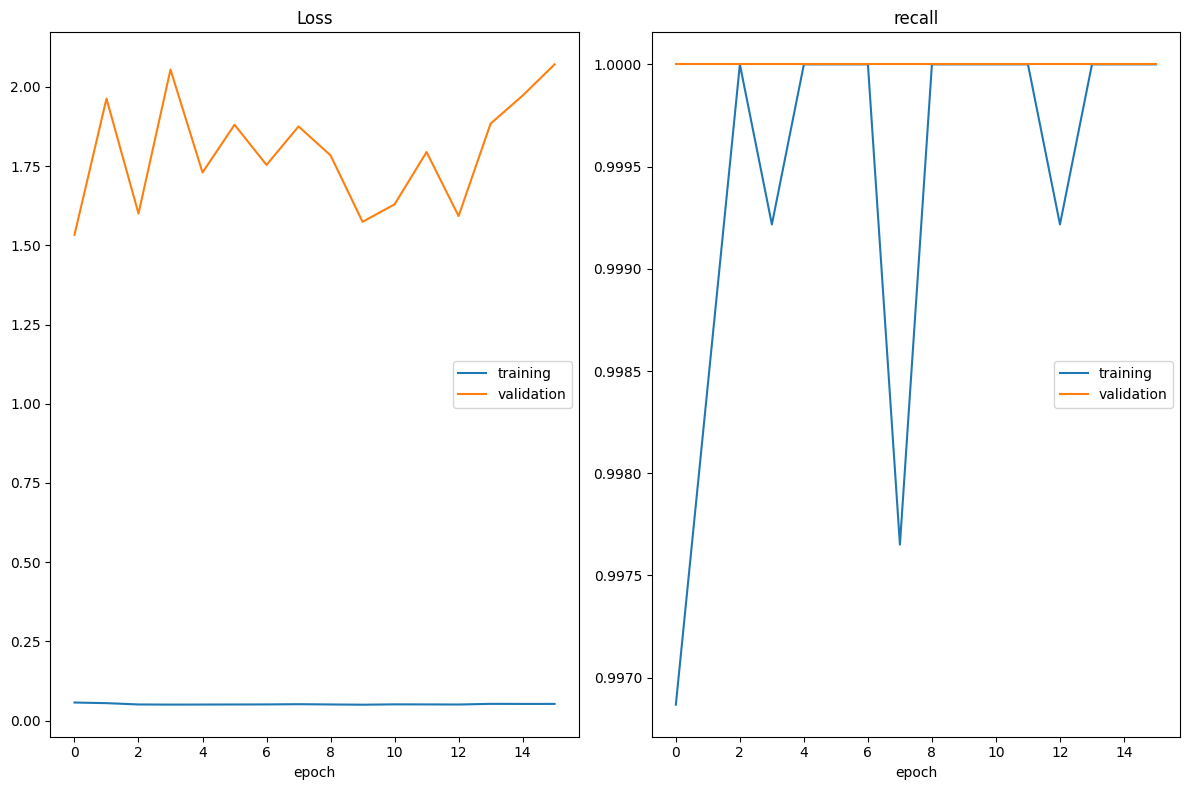

Loss
	training         	 (min:    0.050, max:    0.057, cur:    0.053)
	validation       	 (min:    1.533, max:    2.071, cur:    2.071)
recall
	training         	 (min:    0.997, max:    1.000, cur:    1.000)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
Restoring model weights from the end of the best epoch: 1.
197/197 [==============================] - 2s 10ms/step - loss: 0.0530 - recall: 1.0000 - val_loss: 2.0710 - val_recall: 1.0000
Epoch 16: early stopping


In [97]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping


# In each minibatch during the training, 0.2 of the nuerons will set to be = 0, it helps to redcue the overfitting potential 
tf.random.set_seed(42)
model_Optuna_Recall = Sequential(
    [
        Input(shape= X_train.shape[1]),  # Number of unputs [feature]
        Dense(input_layer_units, activation="relu"),
        Dropout(input_layer_dropout),
        Dense(hidden_layer_units_0, activation="relu"),
        Dropout(dropout_0),
        Dense(hidden_layer_units_1, activation="relu"),
        Dropout(dropout_1),
        Dense(hidden_layer_units_2, activation="relu"),
        Dropout(dropout_2),
        Dense(hidden_layer_units_3, activation="relu"),
        Dropout(dropout_3),
        Dense(hidden_layer_units_4, activation="relu"),
        Dropout(dropout_4),
        Dense(hidden_layer_units_5, activation="relu"),
        Dropout(dropout_5),
        Dense(units=1, activation='sigmoid'),  #  1 neuron and Sigmoid because it is a bianry classification problem
    ]
)

# # neg = y.value_counts()[0]
# # pos = y.value_counts()[1]
# # total = neg + pos

# # # Scaling by total/2 helps keep the loss to a similar magnitude.
# # # The sum of the weights of all examples stays the same.
# # weight_for_0 = (1 / neg) * (total / 2.0)
# # weight_for_1 = (1 / pos) * (total / 2.0)

# # class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))


# Complie
model_Optuna_Recall.compile(optimizer=Adam(learning_rate=learning_rate),
                     loss='binary_crossentropy',
                     metrics="Recall")

#  live training loss plot 
from livelossplot import PlotLossesKeras

# Stop training when a monitored metric has stopped improving.
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True
)



# We are readt to fit the data
model_Optuna_Recall.fit(
    x=X_train, y=y_train, validation_split=0.1, batch_size=32, epochs=1000, verbose=1,  # 1000 epoch since there is early stopping
    class_weight={0: w0, 1: w1},    
    callbacks=[PlotLossesKeras(), early_stop]  # We add the erarly stop
    
)

# Since this is without early stopping, we will just use 500 epoch

In [99]:
eval_metric(model_Optuna_Recall, X_train, y_train, X_test, y_test)

94/94 [==============================] - 0s 2ms/step
Test_Set
[[ 116 2273]
 [   5  606]]
              precision    recall  f1-score   support

           0       0.96      0.05      0.09      2389
           1       0.21      0.99      0.35       611

    accuracy                           0.24      3000
   macro avg       0.58      0.52      0.22      3000
weighted avg       0.81      0.24      0.14      3000


Train_Set
[[ 245 5329]
 [  11 1415]]
              precision    recall  f1-score   support

           0       0.96      0.04      0.08      5574
           1       0.21      0.99      0.35      1426

    accuracy                           0.24      7000
   macro avg       0.58      0.52      0.22      7000
weighted avg       0.80      0.24      0.14      7000



94/94 [==============================] - 0s 2ms/step


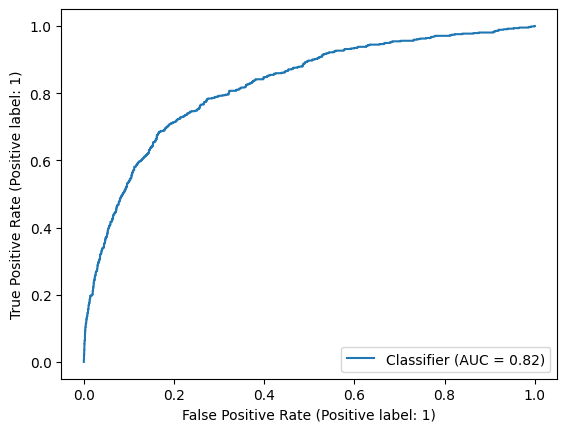

In [177]:
# ROC curve as the question satted, even though it is clearly imbalanced which means Precsion Vs Recall curve is better
y_pred_proba = model_Optuna_Recall.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

**It almost predicted everyting as class 1**

---------------------

## Optuna with PrecisionAtRecall

In [164]:
#trial_metric =  Recall(class_id=1)
trial_metric =  tf.keras.metrics.PrecisionAtRecall(0.7)
batch_size = 32

def create_model(trial):
    trial_metric =  tf.keras.metrics.PrecisionAtRecall(0.7)


    
    # Some hyperparameters we want to optimize
    first_hidden_layer = trial.suggest_int("input_layer_units", 8, 420)
    first_hidden_layer_dropout = trial.suggest_float("input_layer_dropout", 0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1.3e-1)
    optimizer = trial.suggest_categorical("optimizer", [Adam, Adadelta, RMSprop, Nadam])

    
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(first_hidden_layer, input_dim=X_train.shape[1], activation="relu"))
    
    # you can add the hidden layers automatically, see the example below:
    hidden_layers = trial.suggest_int("hidden_layers", 2, 6, log=True)
    for i in range(hidden_layers):
      hidden_layer_units = "hidden_layer_units_" + str(i)
      hidden_layer_units = trial.suggest_int(hidden_layer_units, 4, 128, log=True)
      dropout= "dropout_" + str(i)
      dropout = trial.suggest_float(dropout, 0, 0.5)
      
      model.add(Dense(hidden_layer_units, activation="relu"))
      model.add(Dropout(dropout))
    
    # we decided to use one neuron with sigmoid func in the output layer
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
      loss="binary_crossentropy",
      optimizer=optimizer(learning_rate=learning_rate),
      metrics=[trial_metric],
    )
    return model



def objective(trial):
    early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True
)
    batch_size = 32
    model = create_model(trial)
    w0 = trial.suggest_loguniform("w0", 0.00001, 500)
    w1 = trial.suggest_loguniform("w1", 0.0001, 5000)
    model.fit(
        X_train,
        y_train,
        validation_split=0.1,
        batch_size=batch_size,
        epochs=100,
        callbacks=[early_stop],
        class_weight={0: w0, 1: w1},
        verbose=0)
    
    
    score = model.evaluate(X_test, y_test, verbose=0)[1]
    return score

In [165]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
study.best_params

[I 2023-10-30 17:29:13,429] A new study created in memory with name: no-name-d1db78bc-d96e-4f4d-9253-79bd7f468d8a


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 17:29:48,630] Trial 0 finished with value: 0.2048354595899582 and parameters: {'input_layer_units': 12, 'input_layer_dropout': 0.4724855366194911, 'learning_rate': 0.0011042152225820365, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 11, 'dropout_0': 0.4554373650544816, 'hidden_layer_units_1': 108, 'dropout_1': 0.39243395655057856, 'hidden_layer_units_2': 12, 'dropout_2': 0.37541664970567507, 'hidden_layer_units_3': 88, 'dropout_3': 0.17246615913114466, 'w0': 0.00024964357566579354, 'w1': 2269.402252694062}. Best is trial 0 with value: 0.2048354595899582.


Restoring model weights from the end of the best epoch: 23.
Epoch 38: early stopping


[I 2023-10-30 17:30:28,108] Trial 1 finished with value: 0.5714285969734192 and parameters: {'input_layer_units': 258, 'input_layer_dropout': 0.018023683629440845, 'learning_rate': 0.00022836431282834084, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 84, 'dropout_0': 0.3513436219317261, 'hidden_layer_units_1': 109, 'dropout_1': 0.3767885148005536, 'w0': 0.0012358976530057774, 'w1': 0.0027435054876386996}. Best is trial 1 with value: 0.5714285969734192.


Restoring model weights from the end of the best epoch: 47.
Epoch 62: early stopping


[I 2023-10-30 17:31:33,235] Trial 2 finished with value: 0.5661375522613525 and parameters: {'input_layer_units': 268, 'input_layer_dropout': 0.03702798847799488, 'learning_rate': 6.125113678027266e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 100, 'dropout_0': 0.1869087959613408, 'hidden_layer_units_1': 29, 'dropout_1': 0.20335349385347334, 'w0': 0.0025971038617818806, 'w1': 0.013272029943380571}. Best is trial 1 with value: 0.5714285969734192.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 17:32:08,543] Trial 3 finished with value: 0.20366667211055756 and parameters: {'input_layer_units': 213, 'input_layer_dropout': 0.006561772291182211, 'learning_rate': 0.09206987519154915, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 5, 'dropout_0': 0.3398459722028141, 'hidden_layer_units_1': 69, 'dropout_1': 0.36528538002981126, 'hidden_layer_units_2': 17, 'dropout_2': 0.09172090185024695, 'hidden_layer_units_3': 7, 'dropout_3': 0.013109466933961422, 'w0': 1.873566775187225e-05, 'w1': 2403.239346963512}. Best is trial 1 with value: 0.5714285969734192.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 17:32:36,165] Trial 4 finished with value: 0.3512461185455322 and parameters: {'input_layer_units': 233, 'input_layer_dropout': 0.13320809460043714, 'learning_rate': 2.234115443647894e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 7, 'dropout_0': 0.06137712538740403, 'hidden_layer_units_1': 16, 'dropout_1': 0.0957404120198238, 'w0': 0.7191309382774352, 'w1': 4980.345258119752}. Best is trial 1 with value: 0.5714285969734192.


Restoring model weights from the end of the best epoch: 25.
Epoch 40: early stopping


[I 2023-10-30 17:33:33,050] Trial 5 finished with value: 0.20366667211055756 and parameters: {'input_layer_units': 98, 'input_layer_dropout': 0.3613118075955478, 'learning_rate': 4.7230343858886806e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 3, 'hidden_layer_units_0': 4, 'dropout_0': 0.4253484724312746, 'hidden_layer_units_1': 7, 'dropout_1': 0.18495064928544136, 'hidden_layer_units_2': 13, 'dropout_2': 0.04563952987907799, 'w0': 0.00817494242343398, 'w1': 0.0006739182868450142}. Best is trial 1 with value: 0.5714285969734192.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 17:34:23,036] Trial 6 finished with value: 0.5149343013763428 and parameters: {'input_layer_units': 208, 'input_layer_dropout': 0.4023127024545951, 'learning_rate': 0.03265063036285281, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 60, 'dropout_0': 0.014414158163975954, 'hidden_layer_units_1': 124, 'dropout_1': 0.2468010170682572, 'w0': 0.06958357709936427, 'w1': 0.013776899257090799}. Best is trial 1 with value: 0.5714285969734192.


Restoring model weights from the end of the best epoch: 34.
Epoch 49: early stopping


[I 2023-10-30 17:35:25,273] Trial 7 finished with value: 0.20366667211055756 and parameters: {'input_layer_units': 73, 'input_layer_dropout': 0.010777594225747755, 'learning_rate': 2.0281937355597006e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 2, 'hidden_layer_units_0': 4, 'dropout_0': 0.2350069123533376, 'hidden_layer_units_1': 18, 'dropout_1': 0.06076109415053865, 'w0': 41.20547146326119, 'w1': 0.12721901697014978}. Best is trial 1 with value: 0.5714285969734192.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 17:35:51,590] Trial 8 finished with value: 0.20366667211055756 and parameters: {'input_layer_units': 394, 'input_layer_dropout': 0.033388712096012296, 'learning_rate': 0.004704357034425792, 'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'hidden_layers': 2, 'hidden_layer_units_0': 11, 'dropout_0': 0.40552454449798, 'hidden_layer_units_1': 52, 'dropout_1': 0.49149968254256016, 'w0': 263.4274432052539, 'w1': 0.0001643776934652015}. Best is trial 1 with value: 0.5714285969734192.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 17:36:17,159] Trial 9 finished with value: 0.20366667211055756 and parameters: {'input_layer_units': 133, 'input_layer_dropout': 0.1608212651469999, 'learning_rate': 0.11199571546755602, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 4, 'hidden_layer_units_0': 100, 'dropout_0': 0.08904904659097818, 'hidden_layer_units_1': 9, 'dropout_1': 0.4914025179265637, 'hidden_layer_units_2': 4, 'dropout_2': 0.24539414334793563, 'hidden_layer_units_3': 18, 'dropout_3': 0.03272737630744371, 'w0': 0.6847206269968106, 'w1': 301.04358817168304}. Best is trial 1 with value: 0.5714285969734192.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 17:36:39,367] Trial 10 finished with value: 0.27071473002433777 and parameters: {'input_layer_units': 362, 'input_layer_dropout': 0.2542639457401067, 'learning_rate': 0.00029435674037367243, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 39, 'dropout_0': 0.3099097269234229, 'hidden_layer_units_1': 4, 'dropout_1': 0.3302796687624953, 'hidden_layer_units_2': 118, 'dropout_2': 0.47829360144132066, 'hidden_layer_units_3': 5, 'dropout_3': 0.44530723262872923, 'hidden_layer_units_4': 10, 'dropout_4': 0.16666301581053403, 'hidden_layer_units_5': 29, 'dropout_5': 0.2677865486763028, 'w0': 1.7056674190174998e-05, 'w1': 6.856572955181351}. Best is trial 1 with value: 0.5714285969734192.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 17:37:27,331] Trial 11 finished with value: 0.560052216053009 and parameters: {'input_layer_units': 303, 'input_layer_dropout': 0.10509307554174219, 'learning_rate': 0.00013853751531300846, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 122, 'dropout_0': 0.20423421106836018, 'hidden_layer_units_1': 40, 'dropout_1': 0.16974672661036352, 'w0': 0.0017224747392008226, 'w1': 0.004519545810771545}. Best is trial 1 with value: 0.5714285969734192.


Restoring model weights from the end of the best epoch: 48.
Epoch 63: early stopping


[I 2023-10-30 17:38:38,975] Trial 12 finished with value: 0.5283950567245483 and parameters: {'input_layer_units': 301, 'input_layer_dropout': 0.08546248712137511, 'learning_rate': 0.00011651650740104386, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 41, 'dropout_0': 0.17897313251868496, 'hidden_layer_units_1': 31, 'dropout_1': 0.29274460480581743, 'hidden_layer_units_2': 112, 'dropout_2': 0.22784420279352835, 'w0': 0.0008486470571144161, 'w1': 0.0603097222256838}. Best is trial 1 with value: 0.5714285969734192.


Restoring model weights from the end of the best epoch: 8.
Epoch 23: early stopping


[I 2023-10-30 17:39:04,299] Trial 13 finished with value: 0.5798657536506653 and parameters: {'input_layer_units': 285, 'input_layer_dropout': 0.19185420764608357, 'learning_rate': 0.0006382838581299656, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 75, 'dropout_0': 0.31635558707553557, 'hidden_layer_units_1': 74, 'dropout_1': 0.01612506363756744, 'w0': 0.0058574022338427015, 'w1': 0.004809438542285177}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 34.
Epoch 49: early stopping


[I 2023-10-30 17:39:59,725] Trial 14 finished with value: 0.5119726061820984 and parameters: {'input_layer_units': 341, 'input_layer_dropout': 0.20020475221128545, 'learning_rate': 0.0005354427808285401, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 26, 'dropout_0': 0.3240096656083622, 'hidden_layer_units_1': 72, 'dropout_1': 0.10080709015583518, 'hidden_layer_units_2': 42, 'dropout_2': 0.47278834649854923, 'w0': 0.02780161544396904, 'w1': 0.001117090349639415}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 17:40:17,702] Trial 15 finished with value: 0.21245266497135162 and parameters: {'input_layer_units': 171, 'input_layer_dropout': 0.2309654609629495, 'learning_rate': 0.003677971460371092, 'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'hidden_layers': 2, 'hidden_layer_units_0': 63, 'dropout_0': 0.48088545702878, 'hidden_layer_units_1': 127, 'dropout_1': 0.0017165028348740466, 'w0': 0.00016972379297955386, 'w1': 0.6886330128561876}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 17:40:39,177] Trial 16 finished with value: 0.20380254089832306 and parameters: {'input_layer_units': 420, 'input_layer_dropout': 0.28949817571717734, 'learning_rate': 1.0184303340553616e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 71, 'dropout_0': 0.3702267582992327, 'hidden_layer_units_1': 71, 'dropout_1': 0.40748386696343797, 'hidden_layer_units_2': 4, 'dropout_2': 0.12987655510852317, 'w0': 0.01256594573095532, 'w1': 0.00020756210413273553}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 26.
Epoch 41: early stopping


[I 2023-10-30 17:41:20,277] Trial 17 finished with value: 0.20366667211055756 and parameters: {'input_layer_units': 270, 'input_layer_dropout': 0.16237974155371449, 'learning_rate': 0.0003733740131184248, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 126, 'dropout_0': 0.28343854060006846, 'hidden_layer_units_1': 86, 'dropout_1': 0.27383213578833804, 'w0': 0.2590845844612146, 'w1': 0.0018965151343650834}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 17:42:20,907] Trial 18 finished with value: 0.5245097875595093 and parameters: {'input_layer_units': 180, 'input_layer_dropout': 0.07461502198292641, 'learning_rate': 0.0012197350728350344, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 6, 'hidden_layer_units_0': 40, 'dropout_0': 0.3784001942590453, 'hidden_layer_units_1': 50, 'dropout_1': 0.013022317041142924, 'hidden_layer_units_2': 43, 'dropout_2': 0.01815160641377367, 'hidden_layer_units_3': 116, 'dropout_3': 0.45946264582790375, 'hidden_layer_units_4': 110, 'dropout_4': 0.4972233251524145, 'hidden_layer_units_5': 4, 'dropout_5': 0.006594771056101956, 'w0': 0.00012830418945632206, 'w1': 0.009152413115061254}. Best is trial 13 with value: 0.5798657536506653.
[I 2023-10-30 17:44:15,800] Trial 19 finished with value: 0.20380254089832306 and parameters: {'input_layer_units': 261, 'input_layer_dropout': 0.11344674257031007, 'learning_rate': 0.0001331206734423832, 'optimizer': <class 'keras

Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-10-30 17:44:35,588] Trial 20 finished with value: 0.5594771504402161 and parameters: {'input_layer_units': 341, 'input_layer_dropout': 0.06649342442797426, 'learning_rate': 0.0026629667640455305, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 70, 'dropout_0': 0.3687023349341778, 'hidden_layer_units_1': 57, 'dropout_1': 0.21333578086034077, 'w0': 0.0440931829043542, 'w1': 0.051274628609008235}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 17:45:22,570] Trial 21 finished with value: 0.5744966268539429 and parameters: {'input_layer_units': 288, 'input_layer_dropout': 0.03981556216797265, 'learning_rate': 8.225074563121841e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 88, 'dropout_0': 0.23911974827490373, 'hidden_layer_units_1': 29, 'dropout_1': 0.23439517968812815, 'w0': 0.0033999824179928965, 'w1': 0.007918103849123101}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 17:45:54,453] Trial 22 finished with value: 0.5641361474990845 and parameters: {'input_layer_units': 314, 'input_layer_dropout': 0.00016135650445606858, 'learning_rate': 0.00018460462041338448, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 88, 'dropout_0': 0.2565066863081449, 'hidden_layer_units_1': 40, 'dropout_1': 0.3233930637249849, 'w0': 0.009331802402470004, 'w1': 0.002098520391416373}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 17:46:20,961] Trial 23 finished with value: 0.5773889422416687 and parameters: {'input_layer_units': 252, 'input_layer_dropout': 0.05222285756580575, 'learning_rate': 0.0006127939194312344, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 51, 'dropout_0': 0.325026864724936, 'hidden_layer_units_1': 86, 'dropout_1': 0.24185044942061562, 'w0': 0.0007205231832373179, 'w1': 0.0012633893609077479}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 17:46:49,656] Trial 24 finished with value: 0.5569947957992554 and parameters: {'input_layer_units': 235, 'input_layer_dropout': 0.06011691214338061, 'learning_rate': 0.0005996999392476009, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 59, 'dropout_0': 0.3173601450855959, 'hidden_layer_units_1': 84, 'dropout_1': 0.22936033518954538, 'hidden_layer_units_2': 29, 'dropout_2': 0.1568525060051002, 'w0': 0.0005328840635196015, 'w1': 0.0007096047716945573}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 17:47:07,202] Trial 25 finished with value: 0.22782152891159058 and parameters: {'input_layer_units': 297, 'input_layer_dropout': 0.15282060412282067, 'learning_rate': 7.86932930891543e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 48, 'dropout_0': 0.2435205022557323, 'hidden_layer_units_1': 26, 'dropout_1': 0.15094735384414215, 'w0': 6.686743518590013e-05, 'w1': 0.021475545289260427}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 39.
Epoch 54: early stopping


[I 2023-10-30 17:48:16,362] Trial 26 finished with value: 0.514976978302002 and parameters: {'input_layer_units': 176, 'input_layer_dropout': 0.11102190835496327, 'learning_rate': 0.0008856077413271333, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 30, 'dropout_0': 0.29009803292672554, 'hidden_layer_units_1': 43, 'dropout_1': 0.24133296237460242, 'hidden_layer_units_2': 7, 'dropout_2': 0.005391153466853094, 'hidden_layer_units_3': 32, 'dropout_3': 0.3055638289475306, 'hidden_layer_units_4': 6, 'dropout_4': 0.005181871888179479, 'w0': 0.00046849454046585096, 'w1': 0.18272393580906043}. Best is trial 13 with value: 0.5798657536506653.
[I 2023-10-30 17:50:10,079] Trial 27 finished with value: 0.20366667211055756 and parameters: {'input_layer_units': 373, 'input_layer_dropout': 0.05878201009306108, 'learning_rate': 0.00028262254979426936, 'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'hidden_layers': 3,

Restoring model weights from the end of the best epoch: 11.
Epoch 26: early stopping


[I 2023-10-30 17:50:52,594] Trial 28 finished with value: 0.5407779216766357 and parameters: {'input_layer_units': 332, 'input_layer_dropout': 0.18845611875055374, 'learning_rate': 0.0017594596444674955, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 5, 'hidden_layer_units_0': 76, 'dropout_0': 0.1560816416273022, 'hidden_layer_units_1': 76, 'dropout_1': 0.19710548187407534, 'hidden_layer_units_2': 23, 'dropout_2': 0.31596239670922344, 'hidden_layer_units_3': 13, 'dropout_3': 0.2701380256120886, 'hidden_layer_units_4': 37, 'dropout_4': 0.49068931536625066, 'w0': 0.0007032841647958906, 'w1': 0.0004981076298561804}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 26.
Epoch 41: early stopping


[I 2023-10-30 17:52:02,263] Trial 29 finished with value: 0.5580182671546936 and parameters: {'input_layer_units': 12, 'input_layer_dropout': 0.09045508870529743, 'learning_rate': 0.0007957642667069109, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 30, 'dropout_0': 0.44726912944365055, 'hidden_layer_units_1': 103, 'dropout_1': 0.27195420112842444, 'w0': 0.0002498156736160953, 'w1': 0.00010519524981432782}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 17:52:55,587] Trial 30 finished with value: 0.4903954863548279 and parameters: {'input_layer_units': 281, 'input_layer_dropout': 0.13572895084757136, 'learning_rate': 0.0003784925125258457, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 103, 'dropout_0': 0.3152487850158191, 'hidden_layer_units_1': 35, 'dropout_1': 0.054556677334383574, 'hidden_layer_units_2': 79, 'dropout_2': 0.07169818760172636, 'hidden_layer_units_3': 4, 'dropout_3': 0.15166573950812126, 'w0': 5.682739353828182e-05, 'w1': 0.004675983344182504}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 23.
Epoch 38: early stopping


[I 2023-10-30 17:53:37,109] Trial 31 finished with value: 0.5483460426330566 and parameters: {'input_layer_units': 237, 'input_layer_dropout': 0.038824961208492624, 'learning_rate': 0.00019975783618953106, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 85, 'dropout_0': 0.3410247585458863, 'hidden_layer_units_1': 104, 'dropout_1': 0.2434917423753307, 'w0': 0.0014340720095368572, 'w1': 0.0018404703000294443}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 36.
Epoch 51: early stopping


[I 2023-10-30 17:54:29,805] Trial 32 finished with value: 0.5779569745063782 and parameters: {'input_layer_units': 267, 'input_layer_dropout': 0.030055791336350987, 'learning_rate': 8.601097854820012e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 79, 'dropout_0': 0.35246604087480604, 'hidden_layer_units_1': 104, 'dropout_1': 0.21142858002325954, 'w0': 0.0024857552272187036, 'w1': 0.0028048246809992254}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 40.
Epoch 55: early stopping


[I 2023-10-30 17:55:27,514] Trial 33 finished with value: 0.5613576769828796 and parameters: {'input_layer_units': 239, 'input_layer_dropout': 0.03984567374665612, 'learning_rate': 6.919832301010399e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 81, 'dropout_0': 0.3479507010352968, 'hidden_layer_units_1': 87, 'dropout_1': 0.2154069871728147, 'w0': 0.0018747813677708217, 'w1': 0.00040533639576231063}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 65.
Epoch 80: early stopping


[I 2023-10-30 17:56:49,171] Trial 34 finished with value: 0.560052216053009 and parameters: {'input_layer_units': 201, 'input_layer_dropout': 0.03904593645729283, 'learning_rate': 4.1719287404172074e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 54, 'dropout_0': 0.26763854275137433, 'hidden_layer_units_1': 60, 'dropout_1': 0.17644862765006186, 'w0': 0.01726740433718834, 'w1': 0.023513572463683692}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 23.
Epoch 38: early stopping


[I 2023-10-30 17:57:29,213] Trial 35 finished with value: 0.5565669536590576 and parameters: {'input_layer_units': 281, 'input_layer_dropout': 0.08917826131203506, 'learning_rate': 9.71280512860287e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 101, 'dropout_0': 0.2921642965852447, 'hidden_layer_units_1': 127, 'dropout_1': 0.11052503737916913, 'w0': 0.003402258893677415, 'w1': 0.004194872330508585}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 17:58:32,092] Trial 36 finished with value: 0.5578673481941223 and parameters: {'input_layer_units': 252, 'input_layer_dropout': 0.003817730223842186, 'learning_rate': 0.00020194390491629018, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 4, 'hidden_layer_units_0': 72, 'dropout_0': 0.22557526322287222, 'hidden_layer_units_1': 48, 'dropout_1': 0.19802203698590048, 'hidden_layer_units_2': 30, 'dropout_2': 0.4106925063199053, 'hidden_layer_units_3': 42, 'dropout_3': 0.3762584403087526, 'w0': 0.005861440217053224, 'w1': 0.0013621632553553942}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 58.
Epoch 73: early stopping


[I 2023-10-30 17:59:52,951] Trial 37 finished with value: 0.5466156005859375 and parameters: {'input_layer_units': 319, 'input_layer_dropout': 0.06483864366253021, 'learning_rate': 3.68401218104026e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 61, 'dropout_0': 0.3897821703790828, 'hidden_layer_units_1': 67, 'dropout_1': 0.21815148127223882, 'hidden_layer_units_2': 65, 'dropout_2': 0.29166666872650926, 'w0': 0.028550037547710013, 'w1': 0.014069014385052904}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 64.
Epoch 79: early stopping


[I 2023-10-30 18:01:31,184] Trial 38 finished with value: 0.5549871921539307 and parameters: {'input_layer_units': 216, 'input_layer_dropout': 0.028655025763138862, 'learning_rate': 6.712541257793237e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 2, 'hidden_layer_units_0': 127, 'dropout_0': 0.35051029032001874, 'hidden_layer_units_1': 100, 'dropout_1': 0.17301151373749593, 'w0': 0.0003792726773664703, 'w1': 0.00039533654975960273}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 14.
Epoch 29: early stopping


[I 2023-10-30 18:02:19,794] Trial 39 finished with value: 0.5467171669006348 and parameters: {'input_layer_units': 285, 'input_layer_dropout': 0.12602072580103324, 'learning_rate': 0.0005667068781486787, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 17, 'dropout_0': 0.4368957037192147, 'hidden_layer_units_1': 23, 'dropout_1': 0.26087187224935027, 'w0': 0.007542337675456904, 'w1': 0.007490502558781007}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 18:02:39,330] Trial 40 finished with value: 0.20380888879299164 and parameters: {'input_layer_units': 156, 'input_layer_dropout': 0.09334810795105174, 'learning_rate': 2.829487225890336e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 94, 'dropout_0': 0.41534395949995806, 'hidden_layer_units_1': 57, 'dropout_1': 0.11641050293476245, 'hidden_layer_units_2': 17, 'dropout_2': 0.19906568043537648, 'w0': 0.1162709587564829, 'w1': 0.0023613180075057138}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 37.
Epoch 52: early stopping


[I 2023-10-30 18:03:35,729] Trial 41 finished with value: 0.5549805760383606 and parameters: {'input_layer_units': 256, 'input_layer_dropout': 0.02724398911416364, 'learning_rate': 5.388311675992521e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 81, 'dropout_0': 0.35452786976122, 'hidden_layer_units_1': 111, 'dropout_1': 0.30343482157200896, 'w0': 0.0010514664681015296, 'w1': 0.0009725736918723447}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 18.
Epoch 33: early stopping


[I 2023-10-30 18:04:09,696] Trial 42 finished with value: 0.5797297358512878 and parameters: {'input_layer_units': 215, 'input_layer_dropout': 0.014316419728839402, 'learning_rate': 0.00024053031405038073, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 105, 'dropout_0': 0.3261290508486403, 'hidden_layer_units_1': 83, 'dropout_1': 0.36946300862244597, 'w0': 0.0017063814230076566, 'w1': 0.00317455592863007}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 23.
Epoch 38: early stopping


[I 2023-10-30 18:04:49,970] Trial 43 finished with value: 0.5580182671546936 and parameters: {'input_layer_units': 211, 'input_layer_dropout': 0.005765834254210577, 'learning_rate': 0.00014512934953543082, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 107, 'dropout_0': 0.328219426842009, 'hidden_layer_units_1': 79, 'dropout_1': 0.35906312517659905, 'w0': 0.002780186508775263, 'w1': 0.0029859772482723258}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 18:05:37,002] Trial 44 finished with value: 0.5572916865348816 and parameters: {'input_layer_units': 194, 'input_layer_dropout': 0.05640717625397728, 'learning_rate': 0.00029238138658686764, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 67, 'dropout_0': 0.3025142585286655, 'hidden_layer_units_1': 87, 'dropout_1': 0.2502689316105947, 'w0': 0.0014772003243934293, 'w1': 0.00863712113978604}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 18:05:57,510] Trial 45 finished with value: 0.20366667211055756 and parameters: {'input_layer_units': 135, 'input_layer_dropout': 0.025463972847142538, 'learning_rate': 9.752299426731185e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 5, 'hidden_layer_units_0': 90, 'dropout_0': 0.2702112897107149, 'hidden_layer_units_1': 68, 'dropout_1': 0.22787919471090587, 'hidden_layer_units_2': 9, 'dropout_2': 0.26861623059292616, 'hidden_layer_units_3': 12, 'dropout_3': 0.3557858201460491, 'hidden_layer_units_4': 4, 'dropout_4': 0.2719983361593653, 'w0': 0.015823326068983738, 'w1': 0.0008404660235244875}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 22.
Epoch 37: early stopping


[I 2023-10-30 18:06:56,005] Trial 46 finished with value: 0.5329192280769348 and parameters: {'input_layer_units': 229, 'input_layer_dropout': 0.04963335555421755, 'learning_rate': 0.0004557802104467661, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'hidden_layers': 4, 'hidden_layer_units_0': 112, 'dropout_0': 0.33249828543625537, 'hidden_layer_units_1': 115, 'dropout_1': 0.29471544991921933, 'hidden_layer_units_2': 5, 'dropout_2': 0.11073573418477056, 'hidden_layer_units_3': 56, 'dropout_3': 0.48067528855340175, 'w0': 0.004764984742000386, 'w1': 0.028590388409039512}. Best is trial 13 with value: 0.5798657536506653.
[I 2023-10-30 18:08:41,814] Trial 47 finished with value: 0.2172284573316574 and parameters: {'input_layer_units': 269, 'input_layer_dropout': 0.07843493673630764, 'learning_rate': 0.00023702065455747566, 'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'hidden_layers': 2, 'hidden_layer_units_0': 55, 'dropout_0': 0.30196053474

Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 18:09:29,631] Trial 48 finished with value: 0.5473145842552185 and parameters: {'input_layer_units': 360, 'input_layer_dropout': 0.021523564211717, 'learning_rate': 0.00011346867698490991, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 2, 'hidden_layer_units_0': 77, 'dropout_0': 0.38321382239375334, 'hidden_layer_units_1': 94, 'dropout_1': 0.08095608736156312, 'w0': 0.00026907494485015185, 'w1': 0.003789691812282536}. Best is trial 13 with value: 0.5798657536506653.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 18:09:57,990] Trial 49 finished with value: 0.5584415793418884 and parameters: {'input_layer_units': 248, 'input_layer_dropout': 0.10531120294058588, 'learning_rate': 0.0013283220860895145, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'hidden_layers': 3, 'hidden_layer_units_0': 113, 'dropout_0': 0.25468659095570945, 'hidden_layer_units_1': 77, 'dropout_1': 0.270471490365673, 'hidden_layer_units_2': 11, 'dropout_2': 0.22159218382568957, 'w0': 0.0028064640124633067, 'w1': 0.013137553522934223}. Best is trial 13 with value: 0.5798657536506653.


{'input_layer_units': 285,
 'input_layer_dropout': 0.19185420764608357,
 'learning_rate': 0.0006382838581299656,
 'optimizer': keras.optimizers.optimizer_v2.adam.Adam,
 'hidden_layers': 2,
 'hidden_layer_units_0': 75,
 'dropout_0': 0.31635558707553557,
 'hidden_layer_units_1': 74,
 'dropout_1': 0.01612506363756744,
 'w0': 0.0058574022338427015,
 'w1': 0.004809438542285177}

In [170]:
# build model with optuna parameters
hidden_layers = study.best_params["hidden_layers"]
input_layer_units = study.best_params["input_layer_units"]
input_layer_dropout = study.best_params["input_layer_dropout"]

optimizer = study.best_params["optimizer"]

hidden_layer_units_0 = study.best_params["hidden_layer_units_0"]
hidden_layer_units_1 = study.best_params["hidden_layer_units_1"]

dropout_0 = study.best_params["dropout_0"]
dropout_1 = study.best_params["dropout_1"]

learning_rate = study.best_params["learning_rate"]
w0 = study.best_params["w0"]
w1 = study.best_params["w1"]



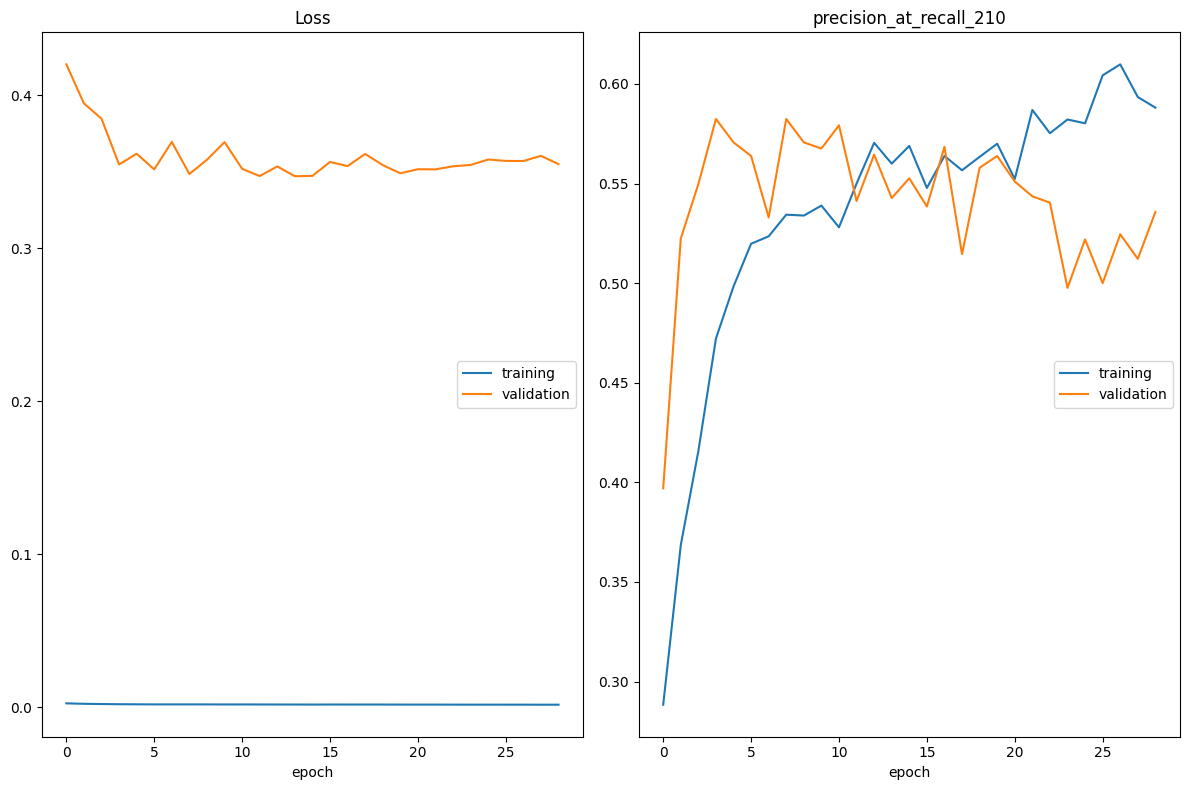

Loss
	training         	 (min:    0.002, max:    0.002, cur:    0.002)
	validation       	 (min:    0.347, max:    0.420, cur:    0.355)
precision_at_recall_210
	training         	 (min:    0.288, max:    0.610, cur:    0.588)
	validation       	 (min:    0.397, max:    0.582, cur:    0.536)
Restoring model weights from the end of the best epoch: 14.
197/197 [==============================] - 2s 8ms/step - loss: 0.0016 - precision_at_recall_210: 0.5881 - val_loss: 0.3550 - val_precision_at_recall_210: 0.5357
Epoch 29: early stopping


In [171]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping


tf.random.set_seed(42)
model_Optuna_PrecisionAtRecall = Sequential(
    [
        Input(shape= X_train.shape[1]),  # Number of unputs [feature]
        Dense(input_layer_units, activation="relu"),
        Dropout(input_layer_dropout),
        Dense(hidden_layer_units_0, activation="relu"),
        Dropout(dropout_0),
        Dense(hidden_layer_units_1, activation="relu"),
        Dropout(dropout_1),
        Dense(units=1, activation='sigmoid'),  #  1 neuron and Sigmoid because it is a bianry classification problem
    ]
)

# # neg = y.value_counts()[0]
# # pos = y.value_counts()[1]
# # total = neg + pos

# # # Scaling by total/2 helps keep the loss to a similar magnitude.
# # # The sum of the weights of all examples stays the same.
# # weight_for_0 = (1 / neg) * (total / 2.0)
# # weight_for_1 = (1 / pos) * (total / 2.0)

# # class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))


# Complie
b.compile(optimizer=optimizer(learning_rate=learning_rate),
                     loss='binary_crossentropy',
                     metrics=tf.keras.metrics.PrecisionAtRecall(0.7))

#  live training loss plot 
from livelossplot import PlotLossesKeras

# Stop training when a monitored metric has stopped improving.
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True
)



# We are readt to fit the data
model_Optuna_PrecisionAtRecall.fit(
    x=X_train, y=y_train, validation_split=0.1, batch_size=32, epochs=1000, verbose=1,  # 1000 epoch since there is early stopping
    class_weight={0: w0, 1: w1},    
    callbacks=[PlotLossesKeras(), early_stop]  # We add the erarly stop
    
)

# Since this is without early stopping, we will just use 500 epoch

In [172]:
eval_metric(model_Optuna_PrecisionAtRecall, X_train, y_train, X_test, y_test)

94/94 [==============================] - 0s 1ms/step
Test_Set
[[2319   70]
 [ 319  292]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2389
           1       0.81      0.48      0.60       611

    accuracy                           0.87      3000
   macro avg       0.84      0.72      0.76      3000
weighted avg       0.86      0.87      0.86      3000


Train_Set
[[5416  158]
 [ 752  674]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      5574
           1       0.81      0.47      0.60      1426

    accuracy                           0.87      7000
   macro avg       0.84      0.72      0.76      7000
weighted avg       0.86      0.87      0.86      7000



---------------------

## Optinas with SensitivityAtSpecificity

In [130]:
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam


#trial_metric =  Recall(class_id=1)
trial_metric =  tf.keras.metrics.SensitivityAtSpecificity(0.7)
batch_size = 32

def create_model(trial):
    #trial_metric =  Recall(class_id=1)
    trial_metric =  tf.keras.metrics.SensitivityAtSpecificity(0.7)
    optimizer = trial.suggest_categorical("optimizer", [Adam, Adadelta, RMSprop, Nadam])


    
    # Some hyperparameters we want to optimize
    first_hidden_layer = trial.suggest_int("input_layer_units", 8, 420)
    first_hidden_layer_dropout = trial.suggest_float("input_layer_dropout", 0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1.3e-1)
    
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(first_hidden_layer, input_dim=X_train.shape[1], activation="relu"))
    
    # you can add the hidden layers automatically, see the example below:
    hidden_layers = trial.suggest_int("hidden_layers", 2, 6, log=True)
    for i in range(hidden_layers):
      hidden_layer_units = "hidden_layer_units_" + str(i)
      hidden_layer_units = trial.suggest_int(hidden_layer_units, 4, 128, log=True)
      dropout= "dropout_" + str(i)
      dropout = trial.suggest_float(dropout, 0, 0.5)
      
      model.add(Dense(hidden_layer_units, activation="relu"))
      model.add(Dropout(dropout))
    
    # we decided to use one neuron with sigmoid func in the output layer
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
      loss="binary_crossentropy",
        optimizer=optimizer(learning_rate=learning_rate),
      metrics=[trial_metric],
    )
    return model



def objective(trial):
    early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True
)
    batch_size = 32
    model = create_model(trial)
    w0 = trial.suggest_loguniform("w0", 0.00001, 500)
    w1 = trial.suggest_loguniform("w1", 0.01, 5000)
    model.fit(
        X_train,
        y_train,
        validation_split=0.1,
        batch_size=batch_size,
        epochs=100,
        callbacks=[early_stop],
        class_weight={0: w0, 1: w1},
        verbose=0)
    
    
    score = model.evaluate(X_test, y_test, verbose=0)[1]
    return score

In [131]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
study.best_params

[I 2023-10-30 11:05:20,063] A new study created in memory with name: no-name-a9394c33-5311-4075-8469-ba85a3bf1bdc


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 11:05:44,702] Trial 0 finished with value: 0.2569558024406433 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'input_layer_units': 203, 'input_layer_dropout': 0.1539204330513983, 'learning_rate': 0.0007550707794124291, 'hidden_layers': 5, 'hidden_layer_units_0': 7, 'dropout_0': 0.15368680238887233, 'hidden_layer_units_1': 46, 'dropout_1': 0.4842731350220968, 'hidden_layer_units_2': 10, 'dropout_2': 0.32585125619560285, 'hidden_layer_units_3': 23, 'dropout_3': 0.21745150005939123, 'hidden_layer_units_4': 25, 'dropout_4': 0.3296242162605719, 'w0': 290.799004787914, 'w1': 1429.4826212897121}. Best is trial 0 with value: 0.2569558024406433.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 11:06:04,019] Trial 1 finished with value: 0.22913256287574768 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'input_layer_units': 165, 'input_layer_dropout': 0.059826321834604235, 'learning_rate': 1.1287227077228896e-05, 'hidden_layers': 2, 'hidden_layer_units_0': 18, 'dropout_0': 0.07195759332592566, 'hidden_layer_units_1': 14, 'dropout_1': 0.33220522446192857, 'w0': 0.020278324023328197, 'w1': 8.995830351952428}. Best is trial 0 with value: 0.2569558024406433.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 11:06:23,175] Trial 2 finished with value: 0.0 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'input_layer_units': 239, 'input_layer_dropout': 0.16181313477886233, 'learning_rate': 0.0001950217911224488, 'hidden_layers': 3, 'hidden_layer_units_0': 23, 'dropout_0': 0.004843273707619777, 'hidden_layer_units_1': 4, 'dropout_1': 0.2500714080486895, 'hidden_layer_units_2': 54, 'dropout_2': 0.1521426360663251, 'w0': 8.326615319917602, 'w1': 348.23604793662145}. Best is trial 0 with value: 0.2569558024406433.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 11:06:52,163] Trial 3 finished with value: 0.46644845604896545 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'input_layer_units': 145, 'input_layer_dropout': 0.4710084716330877, 'learning_rate': 2.1629833172566247e-05, 'hidden_layers': 2, 'hidden_layer_units_0': 30, 'dropout_0': 0.0450483416835718, 'hidden_layer_units_1': 25, 'dropout_1': 0.028715664924909012, 'w0': 0.0063235051635853225, 'w1': 192.08910545528093}. Best is trial 3 with value: 0.46644845604896545.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 11:07:21,487] Trial 4 finished with value: 0.3158756196498871 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 365, 'input_layer_dropout': 0.15726117475151585, 'learning_rate': 5.6084628078522466e-05, 'hidden_layers': 5, 'hidden_layer_units_0': 13, 'dropout_0': 0.4074702301949387, 'hidden_layer_units_1': 108, 'dropout_1': 0.29987717228460253, 'hidden_layer_units_2': 30, 'dropout_2': 0.4983685054536213, 'hidden_layer_units_3': 4, 'dropout_3': 0.41528689149653963, 'hidden_layer_units_4': 7, 'dropout_4': 0.44417454247332355, 'w0': 0.0009827249583722036, 'w1': 10.648425899363957}. Best is trial 3 with value: 0.46644845604896545.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 11:08:12,448] Trial 5 finished with value: 0.8330605626106262 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'input_layer_units': 221, 'input_layer_dropout': 0.10078727573367852, 'learning_rate': 0.00012305911046386463, 'hidden_layers': 3, 'hidden_layer_units_0': 5, 'dropout_0': 0.02537427418115773, 'hidden_layer_units_1': 15, 'dropout_1': 0.0055885810815206605, 'hidden_layer_units_2': 23, 'dropout_2': 0.10894151313206912, 'w0': 0.12394524189090741, 'w1': 1.0796484837180822}. Best is trial 5 with value: 0.8330605626106262.
[I 2023-10-30 11:10:18,090] Trial 6 finished with value: 0.27495908737182617 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'input_layer_units': 36, 'input_layer_dropout': 0.2821498627253301, 'learning_rate': 0.00015754185240254197, 'hidden_layers': 4, 'hidden_layer_units_0': 5, 'dropout_0': 0.004207325344094792, 'hidden_layer_units_1': 13, 'dropout_1': 0.0982865729631548, 'hidd

Restoring model weights from the end of the best epoch: 55.
Epoch 70: early stopping


[I 2023-10-30 11:11:38,009] Trial 7 finished with value: 0.0 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'input_layer_units': 149, 'input_layer_dropout': 0.2742440963873912, 'learning_rate': 0.0025629549824358723, 'hidden_layers': 3, 'hidden_layer_units_0': 6, 'dropout_0': 0.27021697726980254, 'hidden_layer_units_1': 10, 'dropout_1': 0.11495203353805283, 'hidden_layer_units_2': 15, 'dropout_2': 0.32282481387739714, 'w0': 0.004570870496954321, 'w1': 12.923971707003426}. Best is trial 5 with value: 0.8330605626106262.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 11:11:56,310] Trial 8 finished with value: 0.486088365316391 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'input_layer_units': 295, 'input_layer_dropout': 0.3568731918762212, 'learning_rate': 0.00018823440676779082, 'hidden_layers': 2, 'hidden_layer_units_0': 10, 'dropout_0': 0.034042904172956745, 'hidden_layer_units_1': 46, 'dropout_1': 0.31218409461292057, 'w0': 0.000373270369540391, 'w1': 2.9841193034501714}. Best is trial 5 with value: 0.8330605626106262.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 11:12:15,942] Trial 9 finished with value: 0.18166939914226532 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'input_layer_units': 410, 'input_layer_dropout': 0.09884137331270465, 'learning_rate': 4.614850470096664e-05, 'hidden_layers': 3, 'hidden_layer_units_0': 121, 'dropout_0': 0.07562088882368984, 'hidden_layer_units_1': 124, 'dropout_1': 0.0002394629730463893, 'hidden_layer_units_2': 37, 'dropout_2': 0.30919502441747393, 'w0': 0.0012056042915501671, 'w1': 0.3343095907908485}. Best is trial 5 with value: 0.8330605626106262.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 11:12:40,222] Trial 10 finished with value: 0.0 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'input_layer_units': 48, 'input_layer_dropout': 0.022140133443692145, 'learning_rate': 0.04054381607573469, 'hidden_layers': 6, 'hidden_layer_units_0': 4, 'dropout_0': 0.18425929764435284, 'hidden_layer_units_1': 6, 'dropout_1': 0.15714408671827954, 'hidden_layer_units_2': 128, 'dropout_2': 0.008490363621978192, 'hidden_layer_units_3': 115, 'dropout_3': 0.009563022746460426, 'hidden_layer_units_4': 124, 'dropout_4': 0.001637081507153304, 'hidden_layer_units_5': 46, 'dropout_5': 0.03404473801786423, 'w0': 1.7751815075345677e-05, 'w1': 0.013097526379447512}. Best is trial 5 with value: 0.8330605626106262.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 11:13:16,323] Trial 11 finished with value: 0.8477904796600342 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 295, 'input_layer_dropout': 0.40571315018905896, 'learning_rate': 0.0006003355293793236, 'hidden_layers': 2, 'hidden_layer_units_0': 11, 'dropout_0': 0.11902355712577803, 'hidden_layer_units_1': 34, 'dropout_1': 0.21143449648972032, 'w0': 0.4294606265019668, 'w1': 0.9145196491580156}. Best is trial 11 with value: 0.8477904796600342.


Restoring model weights from the end of the best epoch: 22.
Epoch 37: early stopping


[I 2023-10-30 11:14:06,501] Trial 12 finished with value: 0.8183305859565735 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 301, 'input_layer_dropout': 0.493440447742167, 'learning_rate': 0.0013353878103426714, 'hidden_layers': 2, 'hidden_layer_units_0': 4, 'dropout_0': 0.15253298773418683, 'hidden_layer_units_1': 25, 'dropout_1': 0.1962556907400032, 'w0': 0.14736159064771365, 'w1': 0.40901409009101203}. Best is trial 11 with value: 0.8477904796600342.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 11:14:50,425] Trial 13 finished with value: 0.8117839694023132 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 273, 'input_layer_dropout': 0.39106727431999555, 'learning_rate': 0.0038390494081999064, 'hidden_layers': 3, 'hidden_layer_units_0': 9, 'dropout_0': 0.11422656654599256, 'hidden_layer_units_1': 37, 'dropout_1': 0.0644023997973261, 'hidden_layer_units_2': 6, 'dropout_2': 0.11617068082039093, 'w0': 0.3355260284661268, 'w1': 0.03199707972817156}. Best is trial 11 with value: 0.8477904796600342.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 11:15:56,860] Trial 14 finished with value: 0.8363338708877563 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'input_layer_units': 344, 'input_layer_dropout': 0.19179065898900105, 'learning_rate': 0.0006252739177418508, 'hidden_layers': 4, 'hidden_layer_units_0': 8, 'dropout_0': 0.23047429330285507, 'hidden_layer_units_1': 18, 'dropout_1': 0.008862479892302811, 'hidden_layer_units_2': 4, 'dropout_2': 0.028116895899505473, 'hidden_layer_units_3': 4, 'dropout_3': 0.48507294886381064, 'w0': 2.8099919636142845, 'w1': 1.5717720073420838}. Best is trial 11 with value: 0.8477904796600342.


Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping


[I 2023-10-30 11:16:33,285] Trial 15 finished with value: 0.5417348742485046 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'input_layer_units': 376, 'input_layer_dropout': 0.23317099420528223, 'learning_rate': 0.0005834038368324789, 'hidden_layers': 4, 'hidden_layer_units_0': 15, 'dropout_0': 0.24216352721207612, 'hidden_layer_units_1': 23, 'dropout_1': 0.15570529027470648, 'hidden_layer_units_2': 4, 'dropout_2': 0.009767955043213032, 'hidden_layer_units_3': 4, 'dropout_3': 0.47759698496016584, 'w0': 5.087483708832114, 'w1': 0.09439151915823549}. Best is trial 11 with value: 0.8477904796600342.


Restoring model weights from the end of the best epoch: 14.
Epoch 29: early stopping


[I 2023-10-30 11:17:37,113] Trial 16 finished with value: 0.8265138864517212 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'input_layer_units': 343, 'input_layer_dropout': 0.3503849717695056, 'learning_rate': 0.008107213551670614, 'hidden_layers': 4, 'hidden_layer_units_0': 10, 'dropout_0': 0.2528063344141733, 'hidden_layer_units_1': 67, 'dropout_1': 0.098121824517749, 'hidden_layer_units_2': 5, 'dropout_2': 0.2207542349915023, 'hidden_layer_units_3': 8, 'dropout_3': 0.4813437378309255, 'w0': 2.7349575338455065, 'w1': 2.1575189008260964}. Best is trial 11 with value: 0.8477904796600342.


Restoring model weights from the end of the best epoch: 38.
Epoch 53: early stopping


[I 2023-10-30 11:19:09,113] Trial 17 finished with value: 0.8166939616203308 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'input_layer_units': 326, 'input_layer_dropout': 0.2162820789940875, 'learning_rate': 0.00042079051388009054, 'hidden_layers': 2, 'hidden_layer_units_0': 8, 'dropout_0': 0.31856304400598345, 'hidden_layer_units_1': 33, 'dropout_1': 0.057671685579574486, 'w0': 56.42051147964393, 'w1': 39.914409293505315}. Best is trial 11 with value: 0.8477904796600342.


Restoring model weights from the end of the best epoch: 23.
Epoch 38: early stopping


[I 2023-10-30 11:20:10,126] Trial 18 finished with value: 0.8396071791648865 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 404, 'input_layer_dropout': 0.41806441200785993, 'learning_rate': 0.0015631774230236177, 'hidden_layers': 4, 'hidden_layer_units_0': 29, 'dropout_0': 0.4814323866496814, 'hidden_layer_units_1': 9, 'dropout_1': 0.20222406632278972, 'hidden_layer_units_2': 4, 'dropout_2': 0.05203516044055051, 'hidden_layer_units_3': 10, 'dropout_3': 0.3633184714378063, 'w0': 2.3365628515933765, 'w1': 1.1153439250972852}. Best is trial 11 with value: 0.8477904796600342.


Restoring model weights from the end of the best epoch: 6.
Epoch 21: early stopping


[I 2023-10-30 11:20:50,443] Trial 19 finished with value: 0.0 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 414, 'input_layer_dropout': 0.4401963556452551, 'learning_rate': 0.01375031522299263, 'hidden_layers': 6, 'hidden_layer_units_0': 34, 'dropout_0': 0.4951910675569921, 'hidden_layer_units_1': 9, 'dropout_1': 0.24094133643989138, 'hidden_layer_units_2': 8, 'dropout_2': 0.19687461538608367, 'hidden_layer_units_3': 11, 'dropout_3': 0.3501580524917834, 'hidden_layer_units_4': 4, 'dropout_4': 0.13000511120579836, 'hidden_layer_units_5': 4, 'dropout_5': 0.49307402772111375, 'w0': 35.831716856704546, 'w1': 0.15042522005583076}. Best is trial 11 with value: 0.8477904796600342.


Restoring model weights from the end of the best epoch: 11.
Epoch 26: early stopping


[I 2023-10-30 11:21:25,544] Trial 20 finished with value: 0.8510638475418091 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 267, 'input_layer_dropout': 0.41998668520771354, 'learning_rate': 0.0018393168414099768, 'hidden_layers': 2, 'hidden_layer_units_0': 44, 'dropout_0': 0.34582198448676016, 'hidden_layer_units_1': 8, 'dropout_1': 0.21933907289255386, 'w0': 0.9042959702402334, 'w1': 0.7806567062653854}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 10.
Epoch 25: early stopping


[I 2023-10-30 11:21:58,481] Trial 21 finished with value: 0.8297872543334961 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 253, 'input_layer_dropout': 0.4341637366157558, 'learning_rate': 0.001749293324371992, 'hidden_layers': 2, 'hidden_layer_units_0': 46, 'dropout_0': 0.3544133514370546, 'hidden_layer_units_1': 7, 'dropout_1': 0.20978107842276975, 'w0': 0.8618453207558396, 'w1': 1.3195775635149187}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 22.
Epoch 37: early stopping


[I 2023-10-30 11:22:47,412] Trial 22 finished with value: 0.8003273606300354 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 185, 'input_layer_dropout': 0.4073932350506151, 'learning_rate': 0.0037411755759126546, 'hidden_layers': 2, 'hidden_layer_units_0': 53, 'dropout_0': 0.49956160870508787, 'hidden_layer_units_1': 4, 'dropout_1': 0.17137488138811136, 'w0': 0.04779043139707167, 'w1': 0.6374618847717638}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 11:23:45,184] Trial 23 finished with value: 0.7954173684120178 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 93, 'input_layer_dropout': 0.33192427305743283, 'learning_rate': 0.0013178457998881273, 'hidden_layers': 2, 'hidden_layer_units_0': 21, 'dropout_0': 0.4283465899891377, 'hidden_layer_units_1': 7, 'dropout_1': 0.25046213105470394, 'w0': 0.781128663968946, 'w1': 4.118501212463029}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 8.
Epoch 23: early stopping


[I 2023-10-30 11:24:19,706] Trial 24 finished with value: 0.8216039538383484 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 294, 'input_layer_dropout': 0.4949404049974769, 'learning_rate': 0.006510666688811653, 'hidden_layers': 3, 'hidden_layer_units_0': 13, 'dropout_0': 0.31196261467905145, 'hidden_layer_units_1': 11, 'dropout_1': 0.22114980249186073, 'hidden_layer_units_2': 14, 'dropout_2': 0.09647568383974625, 'w0': 0.06851002041366813, 'w1': 0.06728603444356158}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 11:25:12,150] Trial 25 finished with value: 0.777414083480835 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 386, 'input_layer_dropout': 0.3857651202414835, 'learning_rate': 0.0003978275531388959, 'hidden_layers': 5, 'hidden_layer_units_0': 26, 'dropout_0': 0.39610207792193997, 'hidden_layer_units_1': 17, 'dropout_1': 0.26775420182739734, 'hidden_layer_units_2': 6, 'dropout_2': 0.06238890166251097, 'hidden_layer_units_3': 12, 'dropout_3': 0.34404660180485847, 'hidden_layer_units_4': 127, 'dropout_4': 0.49677921102997613, 'w0': 12.233459913762209, 'w1': 0.44755381800209765}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 17.
Epoch 32: early stopping


[I 2023-10-30 11:26:04,576] Trial 26 finished with value: 0.8330605626106262 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 259, 'input_layer_dropout': 0.4434721275704529, 'learning_rate': 0.001119167262032995, 'hidden_layers': 4, 'hidden_layer_units_0': 38, 'dropout_0': 0.4641014160002329, 'hidden_layer_units_1': 20, 'dropout_1': 0.1894446139706295, 'hidden_layer_units_2': 4, 'dropout_2': 0.16530559896774882, 'hidden_layer_units_3': 42, 'dropout_3': 0.15849718189853002, 'w0': 0.9891928865919087, 'w1': 0.7806100129842343}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 11.
Epoch 26: early stopping


[I 2023-10-30 11:26:38,970] Trial 27 finished with value: 0.8363338708877563 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 314, 'input_layer_dropout': 0.31873758374612304, 'learning_rate': 0.002535250596322362, 'hidden_layers': 2, 'hidden_layer_units_0': 64, 'dropout_0': 0.3680495854757466, 'hidden_layer_units_1': 12, 'dropout_1': 0.14934173560259273, 'w0': 0.17270267545139287, 'w1': 0.16291747666689876}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 7.
Epoch 22: early stopping


[I 2023-10-30 11:27:11,043] Trial 28 finished with value: 0.7855973839759827 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 106, 'input_layer_dropout': 0.41002581719609854, 'learning_rate': 0.016770104528461092, 'hidden_layers': 3, 'hidden_layer_units_0': 18, 'dropout_0': 0.4440722783755763, 'hidden_layer_units_1': 9, 'dropout_1': 0.2061862670445317, 'hidden_layer_units_2': 7, 'dropout_2': 0.07207596912068286, 'w0': 1.8776997148498864, 'w1': 4.573625782421714}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 38.
Epoch 53: early stopping


[I 2023-10-30 11:28:50,063] Trial 29 finished with value: 0.0 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 218, 'input_layer_dropout': 0.4607951676901155, 'learning_rate': 0.0008073259707519404, 'hidden_layers': 5, 'hidden_layer_units_0': 26, 'dropout_0': 0.46910608325908637, 'hidden_layer_units_1': 5, 'dropout_1': 0.35049541987486943, 'hidden_layer_units_2': 14, 'dropout_2': 0.2588985224292032, 'hidden_layer_units_3': 15, 'dropout_3': 0.32997323067124723, 'hidden_layer_units_4': 20, 'dropout_4': 0.2483903060361881, 'w0': 229.29498103467895, 'w1': 0.05847657501943283}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 40.
Epoch 55: early stopping


[I 2023-10-30 11:30:39,088] Trial 30 finished with value: 0.8101472854614258 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 359, 'input_layer_dropout': 0.3792911413279049, 'learning_rate': 0.0003341473460179724, 'hidden_layers': 6, 'hidden_layer_units_0': 38, 'dropout_0': 0.3805161486265354, 'hidden_layer_units_1': 8, 'dropout_1': 0.4069341639086129, 'hidden_layer_units_2': 9, 'dropout_2': 0.06515504693399703, 'hidden_layer_units_3': 7, 'dropout_3': 0.16156862019234144, 'hidden_layer_units_4': 39, 'dropout_4': 0.012723539258225391, 'hidden_layer_units_5': 123, 'dropout_5': 0.2546866689648996, 'w0': 0.325415860825058, 'w1': 0.870102315279144}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 9.
Epoch 24: early stopping


[I 2023-10-30 11:31:32,919] Trial 31 finished with value: 0.8297872543334961 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'input_layer_units': 337, 'input_layer_dropout': 0.42520542540958267, 'learning_rate': 0.0006252975338888383, 'hidden_layers': 4, 'hidden_layer_units_0': 7, 'dropout_0': 0.21258982909662713, 'hidden_layer_units_1': 18, 'dropout_1': 0.14601227367708952, 'hidden_layer_units_2': 4, 'dropout_2': 0.014301238498104218, 'hidden_layer_units_3': 5, 'dropout_3': 0.49696267386921633, 'w0': 2.5272280215213523, 'w1': 1.7433426173345967}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 11:32:38,347] Trial 32 finished with value: 0.8297872543334961 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'input_layer_units': 384, 'input_layer_dropout': 0.3072827525264875, 'learning_rate': 0.000896150533753037, 'hidden_layers': 4, 'hidden_layer_units_0': 12, 'dropout_0': 0.15668324308961448, 'hidden_layer_units_1': 13, 'dropout_1': 0.12698996628966813, 'hidden_layer_units_2': 5, 'dropout_2': 0.04408657572891306, 'hidden_layer_units_3': 7, 'dropout_3': 0.4146110536413321, 'w0': 17.101306139206617, 'w1': 2.031645233691158}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 11:33:42,732] Trial 33 finished with value: 0.8117839694023132 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'input_layer_units': 287, 'input_layer_dropout': 0.38116338216239687, 'learning_rate': 0.0018963874481543659, 'hidden_layers': 4, 'hidden_layer_units_0': 17, 'dropout_0': 0.3291939086899786, 'hidden_layer_units_1': 16, 'dropout_1': 0.18237550624562948, 'hidden_layer_units_2': 6, 'dropout_2': 0.11181622403218583, 'hidden_layer_units_3': 4, 'dropout_3': 0.419487538275397, 'w0': 6.0131012571225515, 'w1': 0.3465925257529714}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 11:35:30,611] Trial 34 finished with value: 0.8232405781745911 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'input_layer_units': 347, 'input_layer_dropout': 0.455195649129124, 'learning_rate': 0.00027547748101032347, 'hidden_layers': 5, 'hidden_layer_units_0': 21, 'dropout_0': 0.29051185114805234, 'hidden_layer_units_1': 11, 'dropout_1': 0.27053532022671023, 'hidden_layer_units_2': 4, 'dropout_2': 0.0016455628364648867, 'hidden_layer_units_3': 6, 'dropout_3': 0.3090503001655807, 'hidden_layer_units_4': 9, 'dropout_4': 0.2543684632254309, 'w0': 1.1148457734543382, 'w1': 6.53531600240193}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 15.
Epoch 30: early stopping


[I 2023-10-30 11:36:12,969] Trial 35 finished with value: 0.8363338708877563 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'input_layer_units': 397, 'input_layer_dropout': 0.1864148517436373, 'learning_rate': 0.0008363200158973516, 'hidden_layers': 2, 'hidden_layer_units_0': 7, 'dropout_0': 0.3388815814736929, 'hidden_layer_units_1': 21, 'dropout_1': 0.22074857641685172, 'w0': 3.2676338790725223, 'w1': 0.9454821552724929}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 27.
Epoch 42: early stopping


[I 2023-10-30 11:37:14,479] Trial 36 finished with value: 0.0 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 239, 'input_layer_dropout': 0.34930837044194407, 'learning_rate': 0.0005608470622124208, 'hidden_layers': 3, 'hidden_layer_units_0': 29, 'dropout_0': 0.41453143522350866, 'hidden_layer_units_1': 29, 'dropout_1': 0.0663652111475733, 'hidden_layer_units_2': 11, 'dropout_2': 0.05508596825898412, 'w0': 0.34929268630609045, 'w1': 3454.058478090182}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 11:37:37,445] Trial 37 finished with value: 0.2536824941635132 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'input_layer_units': 311, 'input_layer_dropout': 0.46947844632648483, 'learning_rate': 0.00011130632654562483, 'hidden_layers': 5, 'hidden_layer_units_0': 16, 'dropout_0': 0.3891114929666084, 'hidden_layer_units_1': 13, 'dropout_1': 0.036210694530200344, 'hidden_layer_units_2': 7, 'dropout_2': 0.1491937316482477, 'hidden_layer_units_3': 9, 'dropout_3': 0.4237929459273981, 'hidden_layer_units_4': 59, 'dropout_4': 0.38856914171614965, 'w0': 0.03427462049176121, 'w1': 0.21448850384955973}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 13.
Epoch 28: early stopping


[I 2023-10-30 11:38:24,441] Trial 38 finished with value: 0.8183305859565735 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'input_layer_units': 354, 'input_layer_dropout': 0.2654660189724556, 'learning_rate': 0.0016543632199147095, 'hidden_layers': 4, 'hidden_layer_units_0': 11, 'dropout_0': 0.29653076403019163, 'hidden_layer_units_1': 15, 'dropout_1': 0.13050809028710295, 'hidden_layer_units_2': 5, 'dropout_2': 0.02881865632179233, 'hidden_layer_units_3': 6, 'dropout_3': 0.39372712438509716, 'w0': 6.023000656523554, 'w1': 14.080472362700966}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping


[I 2023-10-30 11:39:16,060] Trial 39 finished with value: 0.8379705548286438 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'input_layer_units': 204, 'input_layer_dropout': 0.41447225225224615, 'learning_rate': 0.0002330929170507447, 'hidden_layers': 3, 'hidden_layer_units_0': 14, 'dropout_0': 0.35231251985578715, 'hidden_layer_units_1': 10, 'dropout_1': 0.10744261440588643, 'hidden_layer_units_2': 12, 'dropout_2': 0.09926363000271354, 'w0': 1.424686696010873, 'w1': 2.7632564809420934}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 11:39:35,887] Trial 40 finished with value: 0.28805238008499146 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'input_layer_units': 199, 'input_layer_dropout': 0.4254600382263512, 'learning_rate': 0.0002669272835665958, 'hidden_layers': 3, 'hidden_layer_units_0': 14, 'dropout_0': 0.3623192436192253, 'hidden_layer_units_1': 9, 'dropout_1': 0.1824498198247801, 'hidden_layer_units_2': 12, 'dropout_2': 0.08698280014815582, 'w0': 0.15270694305633206, 'w1': 3.2986063653157993}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 14.
Epoch 29: early stopping


[I 2023-10-30 11:40:09,024] Trial 41 finished with value: 0.8216039538383484 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'input_layer_units': 176, 'input_layer_dropout': 0.4143517540927929, 'learning_rate': 0.0005226162299104998, 'hidden_layers': 2, 'hidden_layer_units_0': 12, 'dropout_0': 0.4215290793670475, 'hidden_layer_units_1': 11, 'dropout_1': 0.0937404491895516, 'w0': 1.5174811595402151, 'w1': 0.6067646687311039}. Best is trial 20 with value: 0.8510638475418091.
[I 2023-10-30 11:42:04,907] Trial 42 finished with value: 0.8199672698974609 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'input_layer_units': 236, 'input_layer_dropout': 0.30119704043006734, 'learning_rate': 0.00017795487065451032, 'hidden_layers': 3, 'hidden_layer_units_0': 9, 'dropout_0': 0.28162743694608705, 'hidden_layer_units_1': 5, 'dropout_1': 0.11403825073740326, 'hidden_layer_units_2': 8, 'dropout_2': 0.045839627951550665, 'w0': 0.53193550

Restoring model weights from the end of the best epoch: 6.
Epoch 21: early stopping


[I 2023-10-30 11:42:31,342] Trial 43 finished with value: 0.8412438631057739 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'input_layer_units': 284, 'input_layer_dropout': 0.36256755451794853, 'learning_rate': 0.0009990894580365704, 'hidden_layers': 4, 'hidden_layer_units_0': 20, 'dropout_0': 0.21866280649263253, 'hidden_layer_units_1': 19, 'dropout_1': 0.01826717690844351, 'hidden_layer_units_2': 9, 'dropout_2': 0.1305395887671738, 'hidden_layer_units_3': 14, 'dropout_3': 0.4591541214351168, 'w0': 2.232980016917994, 'w1': 1.6380570362435307}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 8.
Epoch 23: early stopping


[I 2023-10-30 11:42:58,507] Trial 44 finished with value: 0.8363338708877563 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'input_layer_units': 155, 'input_layer_dropout': 0.3638341087228932, 'learning_rate': 0.0010725707507448629, 'hidden_layers': 3, 'hidden_layer_units_0': 19, 'dropout_0': 0.3447961316214082, 'hidden_layer_units_1': 15, 'dropout_1': 0.08841819647544127, 'hidden_layer_units_2': 10, 'dropout_2': 0.14392705760834584, 'w0': 12.032661575972087, 'w1': 1.9943813327346072}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 11:43:21,230] Trial 45 finished with value: 0.0 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'input_layer_units': 275, 'input_layer_dropout': 0.40252627930381807, 'learning_rate': 0.0002826617083843623, 'hidden_layers': 6, 'hidden_layer_units_0': 24, 'dropout_0': 0.26808260714102833, 'hidden_layer_units_1': 27, 'dropout_1': 0.03980710884732119, 'hidden_layer_units_2': 18, 'dropout_2': 0.128173082339815, 'hidden_layer_units_3': 17, 'dropout_3': 0.3713638018952276, 'hidden_layer_units_4': 12, 'dropout_4': 0.14347415991788798, 'hidden_layer_units_5': 7, 'dropout_5': 0.014632293002002639, 'w0': 0.0174187570024531, 'w1': 1.069532737237618}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 58.
Epoch 73: early stopping


[I 2023-10-30 11:44:43,023] Trial 46 finished with value: 0.8265138864517212 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'input_layer_units': 120, 'input_layer_dropout': 0.37200304712970755, 'learning_rate': 0.00010018286317004775, 'hidden_layers': 2, 'hidden_layer_units_0': 21, 'dropout_0': 0.3058584663584645, 'hidden_layer_units_1': 22, 'dropout_1': 0.17806638390104385, 'w0': 0.3800975679869816, 'w1': 0.3385083956695883}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 20.
Epoch 35: early stopping


[I 2023-10-30 11:45:24,870] Trial 47 finished with value: 0.844517171382904 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'input_layer_units': 203, 'input_layer_dropout': 0.4791110710566976, 'learning_rate': 0.0031279181175706, 'hidden_layers': 4, 'hidden_layer_units_0': 15, 'dropout_0': 0.37921581503189883, 'hidden_layer_units_1': 10, 'dropout_1': 0.16089418343756023, 'hidden_layer_units_2': 9, 'dropout_2': 0.0882829270070535, 'hidden_layer_units_3': 10, 'dropout_3': 0.443012449966783, 'w0': 1.3267427838579493, 'w1': 3.366183707098529}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


[I 2023-10-30 11:45:47,122] Trial 48 finished with value: 0.09001636505126953 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'input_layer_units': 255, 'input_layer_dropout': 0.48954813856814283, 'learning_rate': 0.0024228972807335144, 'hidden_layers': 5, 'hidden_layer_units_0': 17, 'dropout_0': 0.3991601171658691, 'hidden_layer_units_1': 14, 'dropout_1': 0.2290235115938259, 'hidden_layer_units_2': 21, 'dropout_2': 0.17240736614516977, 'hidden_layer_units_3': 11, 'dropout_3': 0.4672520160306075, 'hidden_layer_units_4': 4, 'dropout_4': 0.36685590424855374, 'w0': 0.08525479024893388, 'w1': 12.329545291777842}. Best is trial 20 with value: 0.8510638475418091.


Restoring model weights from the end of the best epoch: 26.
Epoch 41: early stopping


[I 2023-10-30 11:46:36,956] Trial 49 finished with value: 0.8183305859565735 and parameters: {'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'input_layer_units': 276, 'input_layer_dropout': 0.475156208964162, 'learning_rate': 0.0037041786540554125, 'hidden_layers': 4, 'hidden_layer_units_0': 29, 'dropout_0': 0.3775596677233, 'hidden_layer_units_1': 7, 'dropout_1': 0.20258267870258315, 'hidden_layer_units_2': 9, 'dropout_2': 0.09315545047784371, 'hidden_layer_units_3': 16, 'dropout_3': 0.44003766824196594, 'w0': 4.5993525872665195, 'w1': 0.5484742133333271}. Best is trial 20 with value: 0.8510638475418091.


{'optimizer': keras.optimizers.optimizer_v2.rmsprop.RMSprop,
 'input_layer_units': 267,
 'input_layer_dropout': 0.41998668520771354,
 'learning_rate': 0.0018393168414099768,
 'hidden_layers': 2,
 'hidden_layer_units_0': 44,
 'dropout_0': 0.34582198448676016,
 'hidden_layer_units_1': 8,
 'dropout_1': 0.21933907289255386,
 'w0': 0.9042959702402334,
 'w1': 0.7806567062653854}

In [132]:
# build model with optuna parameters
optimizer = study.best_params["optimizer"]
hidden_layers = study.best_params["hidden_layers"]
input_layer_units = study.best_params["input_layer_units"]
input_layer_dropout = study.best_params["input_layer_dropout"]

hidden_layer_units_0 = study.best_params["hidden_layer_units_0"]
hidden_layer_units_1 = study.best_params["hidden_layer_units_1"]

dropout_0 = study.best_params["dropout_0"]
dropout_1 = study.best_params["dropout_1"]

learning_rate = study.best_params["learning_rate"]
w0 = study.best_params["w0"]
w1 = study.best_params["w1"]

optimizer

keras.optimizers.optimizer_v2.rmsprop.RMSprop

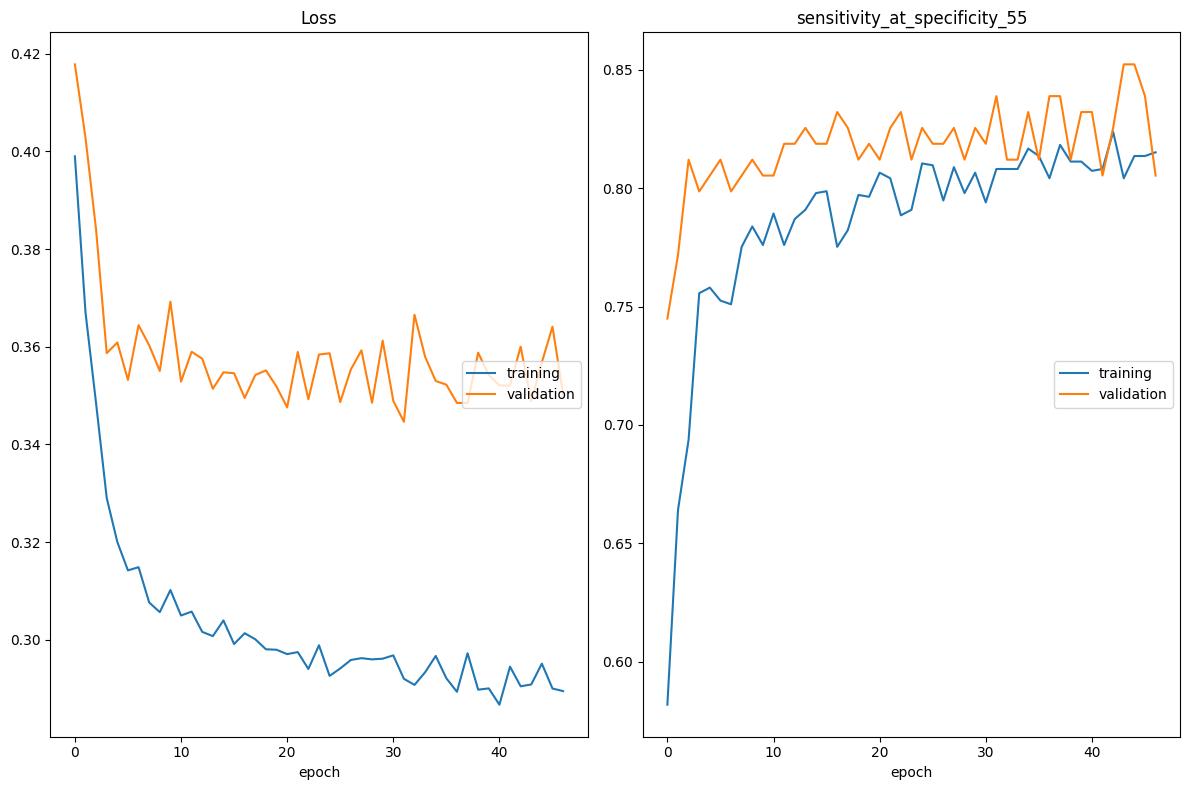

Loss
	training         	 (min:    0.287, max:    0.399, cur:    0.290)
	validation       	 (min:    0.345, max:    0.418, cur:    0.350)
sensitivity_at_specificity_55
	training         	 (min:    0.582, max:    0.824, cur:    0.815)
	validation       	 (min:    0.745, max:    0.852, cur:    0.805)
Restoring model weights from the end of the best epoch: 32.
197/197 [==============================] - 2s 10ms/step - loss: 0.2895 - sensitivity_at_specificity_55: 0.8152 - val_loss: 0.3504 - val_sensitivity_at_specificity_55: 0.8054
Epoch 47: early stopping


In [133]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping


# In each minibatch during the training, 0.2 of the nuerons will set to be = 0, it helps to redcue the overfitting potential 
tf.random.set_seed(42)
model_Optuna_SensitivityAtSpecificity = Sequential(
    [
        Input(shape= X_train.shape[1]),  # Number of unputs [feature]
        Dense(input_layer_units, activation="relu"),
        Dropout(input_layer_dropout),
        Dense(hidden_layer_units_0, activation="relu"),
        Dropout(dropout_0),
        Dense(hidden_layer_units_1, activation="relu"),
        Dropout(dropout_1),
        Dense(units=1, activation='sigmoid'),  #  1 neuron and Sigmoid because it is a bianry classification problem
    ]
)

# # neg = y.value_counts()[0]
# # pos = y.value_counts()[1]
# # total = neg + pos

# # # Scaling by total/2 helps keep the loss to a similar magnitude.
# # # The sum of the weights of all examples stays the same.
# # weight_for_0 = (1 / neg) * (total / 2.0)
# # weight_for_1 = (1 / pos) * (total / 2.0)

# # class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))


# Complie
model_Optuna_SensitivityAtSpecificity.compile(optimizer=optimizer(learning_rate=learning_rate),
                     loss='binary_crossentropy',
                     metrics=tf.keras.metrics.SensitivityAtSpecificity(0.7))

#  live training loss plot 
from livelossplot import PlotLossesKeras

# Stop training when a monitored metric has stopped improving.
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True
)



# We are readt to fit the data
model_Optuna_SensitivityAtSpecificity.fit(
    x=X_train, y=y_train, validation_split=0.1, batch_size=32, epochs=1000, verbose=1,  # 1000 epoch since there is early stopping
    class_weight={0: w0, 1: w1},    
    callbacks=[PlotLossesKeras(), early_stop]  # We add the erarly stop
    
)

# Since this is without early stopping, we will just use 500 epoch

In [135]:
eval_metric(model_Optuna_SensitivityAtSpecificity, X_train, y_train, X_test, y_test)

94/94 [==============================] - 0s 2ms/step
Test_Set
[[2322   67]
 [ 325  286]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2389
           1       0.81      0.47      0.59       611

    accuracy                           0.87      3000
   macro avg       0.84      0.72      0.76      3000
weighted avg       0.86      0.87      0.86      3000


Train_Set
[[5433  141]
 [ 785  641]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      5574
           1       0.82      0.45      0.58      1426

    accuracy                           0.87      7000
   macro avg       0.85      0.71      0.75      7000
weighted avg       0.86      0.87      0.85      7000



# Final Model and Model Deployment

In [178]:
import pickle
# remember that pipe_model has the fitted encoding and srobust scaling
# so we willl save ti then use it to transform the inferenc eobservation
pickle.dump(pipe_model, open("transform_bank", "wb"))

In [180]:
# Save the model
model_Optuna_PrecisionAtRecall.save("model_bank.h5")

## Prediction

In [194]:
# Get a random observation
single_customer = df.drop("Exited", axis=1).iloc[200:201, :]
single_customer

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
200,850,Spain,Male,30,2,141040.01,1,1,1,5978.2


In [195]:
# Transform it based on the saved transformer
transform_bank = pickle.load(open("transform_bank", "rb"))
single_customer = transform_bank.transform(single_customer)
single_customer

array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.44852941, -0.61538462, -0.6       ,  0.32832012,  0.        ,
         0.        ,  0.        , -0.95495076]])

In [196]:
# Uee the saved model to predcit
from tensorflow.keras.models import load_model
model_bank = load_model("model_bank.h5")
(model_bank.predict(single_customer) > 0.5).astype("int32")

1/1 [==============================] - 0s 64ms/step


array([[0]])

In [197]:
# See the real value
df["Exited"].iloc[0]

1

## Comclusion

For thes tested observatio nabove, It is class 1 but was predicted as 1 becuase it is the most frequent class, and this is the problem of all the models. As stated eariler, predicting all observations by the most frequent class wil give us around 80% accuracy, so 87% is better but not very good result. Therfroe, more methods for imbalanced data should be done, like Oversampling techniques. 

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___